In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from tqdm import tqdm

###  DATA READING

In [17]:
with open('X_train.txt', 'r') as file:
    content = file.read()
    traindata_str = np.array([content.split()])
    traindata = traindata_str.astype(float)
    traindata = np.reshape(traindata, (7352,561) )
with open('y_train.txt', 'r') as file2:
    content2 = file2.read()
    trainlabel_str = np.array([content2.split()])
    trainlabel = trainlabel_str.astype(float)
    trainlabel = np.reshape(trainlabel, (7352,1))
with open('X_test.txt', 'r') as file3:
    content3 = file3.read()
    testdata_str = np.array([content3.split()])
    testdata = testdata_str.astype(float)
    testdata = np.reshape(testdata, (2947,561) )
with open('y_test.txt', 'r') as file4:
    content4 = file4.read()
    testlabel_str = np.array([content4.split()])
    testlabel = testlabel_str.astype(float)
    testlabel = np.reshape(testlabel, (2947,1) )

# Shuffle Data

In [22]:
per = np.random.permutation(traindata.shape[0])
shuffled_train_data_array = traindata
shuffled_train_label_array = trainlabel
for old, new in enumerate(per):
    shuffled_train_data_array[new,:] = traindata[old,:]
    shuffled_train_label_array[new,:] = trainlabel[old,:]

In [23]:
traindata=shuffled_train_data_array
trainlabel=shuffled_train_label_array


# HAR CLASS

In [5]:
class HAR:
    
    def __init__(self,hidden_size_1,hidden_size_2,learning_coef,batch_size,momentum):
        
        self.H1_weight = np.random.uniform(-0.01, 0.01, size=(hidden_size_1, 561))
        self.H2_weight = np.random.uniform(-0.01, 0.01, size=(hidden_size_2, hidden_size_1))
        self.O_weight = np.random.uniform(-0.01, 0.01, size=(6, hidden_size_2))
        self.learning_coef = learning_coef
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.batch_size= batch_size
        self.feedbackh1 = np.zeros((hidden_size_1, 561))
        self.feedbackh2 = np.zeros((hidden_size_2, hidden_size_1))
        self.feedbackO = np.zeros((6, hidden_size_2))
        self.momentum=momentum
        
        return
    
    def Softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=-1, keepdims=True)

    def Relu(self,x):
        return np.maximum(0,x)
    
    def Relu_derivative(self,x):
        return np.where(x > 0, 1, 0)
    
    
    
    def forward(self,data,label):
        Epsilon= 1e-15
        self.v_1 = np.dot(data,self.H1_weight.T)
        self.o_1 = self.Relu(self.v_1)
        self.v_2 = np.dot(self.o_1,self.H2_weight.T)
        self.o_2 = self.Relu(self.v_2)
        self.v_3 = np.dot(self.o_2,self.O_weight.T)
        self.o_3 = self.Softmax(self.v_3)
        
        cross_entropy_loss= -np.sum(label*np.log(self.o_3+ Epsilon))
        
        avarage_loss=np.mean(cross_entropy_loss)
        return avarage_loss
        
    def gradient_calculation(self,data,label):
        v3grad = self.o_3 -label
        outgrad = np.dot(v3grad.T,self.o_2)
        v2grad = np.dot(v3grad,self.O_weight)
        hidden2grad = np.dot((v2grad*self.Relu_derivative(self.o_2)).T, self.o_1)
        v1grad = np.dot(v2grad*self.Relu_derivative(self.o_2), self.H2_weight)
        hidden1grad = np.dot((v1grad*self.Relu_derivative(self.o_1)).T, data)
        
        
        return outgrad,hidden2grad,hidden1grad
    
    def train(self,traindata,trainlabel,epochs):
        start = time.time()
        data=traindata[:len(traindata)-750]
        label=trainlabel[:len(trainlabel)-750]
        validationdata=traindata[len(traindata)-750:]
        validationlabel=trainlabel[len(trainlabel)-750:]
        
        train_error=np.zeros((epochs,1))
        valid_error=np.zeros((epochs,1))
        
        earlystopilk=float('inf')
        hatalimiti=10
        hatagüncel=0
        
        for epoch in range(epochs):
            train_error_epoch=0
            val_error_epoch=0
            
            with tqdm(total=len(data) // self.batch_size, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
                for idx in range(int(len(data) / self.batch_size)):
                    data_idx = data[self.batch_size * idx: self.batch_size * (idx + 1)]
                    label_idx = label[self.batch_size * idx: self.batch_size * (idx + 1)]
                    one_hot_array = [[1 if i == idx-1 else 0 for i in range(6)] for idx in label_idx]
                    one_hot_vector = np.array(one_hot_array)
                    loss = self.forward(data_idx, one_hot_vector)
                    train_error_epoch += loss / len(data)
                    outgrad, hidden2grad, hidden1grad = self.gradient_calculation(data_idx, one_hot_vector)
                    self.O_weight -= self.learning_coef * (self.momentum * self.feedbackO + outgrad) / self.batch_size
                    self.feedbackO = outgrad
                    self.H2_weight -= self.learning_coef * (self.momentum * self.feedbackh2 + hidden2grad) / self.batch_size
                    self.feedbackh2 = hidden2grad
                    self.H1_weight -= self.learning_coef * (self.momentum * self.feedbackh1 + hidden1grad) / self.batch_size
                    self.feedbackh1 = hidden1grad

                    pbar.update(1)  # Update progress bar
                
            for idx in range(int(len(validationdata)/self.batch_size)):
                data_idx=validationdata[self.batch_size*idx:self.batch_size*(idx+1)]
                label_idx=validationlabel[self.batch_size*idx:self.batch_size*(idx+1)]
                one_hot_array = [[1 if i == idx-1 else 0 for i in range(6)] for idx in label_idx]
                one_hot_vector = np.array(one_hot_array)
                loss= self.forward(data_idx, one_hot_vector)
                val_error_epoch+= loss/ len(validationdata)
                
            train_error[epoch]= train_error_epoch
            valid_error[epoch]= val_error_epoch
            
            if val_error_epoch < earlystopilk:
                earlystopilk= val_error_epoch
                hatagüncel=0
            else:
                hatagüncel+=1
            
            if hatagüncel >= hatalimiti:
                print("Training Stopped")
                break
            
            print("Epoch: ", epoch+1)
            print("Train error: {:.9f}".format(train_error_epoch))
            print("Validation Error: {:.9f}".format(val_error_epoch))
            sys.stdout.flush()
            
        plt.plot(train_error , label='Training Error')
        plt.plot(valid_error , label='Validation Error')

        # Add axis titles
        plt.xlabel('# of Epochs')
        plt.ylabel('Loss')
        plt.show()
        print("Training complete.")
        stop = time.time()
        print("CPU Time: ", stop - start, "s")
        training_error_list = train_error.tolist()
        validation_error_list = valid_error.tolist()
        for i in range(epoch+1):
            train_error_formatted = "{:.15f}".format(training_error_list[i][0])
            valid_error_formatted = "{:.15f}".format(validation_error_list[i][0])
            print(f"Epoch {i+1}, Training Error: {train_error_formatted}, Validation Error: {valid_error_formatted}")
        return
    
    def test_accuracy(self, test_data, test_labels):
        total_accuracy = 0
        misclassified_counts = {i: 0 for i in range(1, 7)}  # Assuming class labels are 1-6

        for i in range(len(test_data) // self.batch_size):
            data_idx = test_data[self.batch_size * i: self.batch_size * (i + 1)]
            label_idx = test_labels[self.batch_size * i: self.batch_size * (i + 1)]
            one_hot_array = [[1 if i == idx-1 else 0 for i in range(6)] for idx in label_idx]
            one_hot_vector = np.array(one_hot_array)
            loss = self.forward(data_idx,one_hot_array)
            predicted_labels=self.o_3
            true_labels = np.argmax(one_hot_vector, axis=1)
            batch_predictions = np.argmax(predicted_labels, axis=1)

            correct_predictions = np.sum(batch_predictions == true_labels)
            batch_accuracy = correct_predictions / len(true_labels)
            total_accuracy += batch_accuracy

            # Update misclassification counts
            for label, prediction in zip(true_labels, batch_predictions):
                if label != prediction:
                    misclassified_counts[label + 1] += 1  # Adjusting index for 1-6 range

        # Calculate overall accuracy
        overall_accuracy = total_accuracy / (len(test_data) // self.batch_size)
        print(f"Test Accuracy: {overall_accuracy * 100:.2f}%")

        # Print misclassification counts
        for label, count in misclassified_counts.items():
            print(f"Class {label}: {count} misclassifications")
        
        classes = list(misclassified_counts.keys())
        counts = [misclassified_counts[c] for c in classes]

        plt.bar(classes, counts, color='skyblue')
        plt.xlabel('Class Label')
        plt.ylabel('Number of Misclassifications')
        plt.title('Misclassifications per Class')
        plt.xticks(classes)
        plt.show()
        
        return

### Case 1

##### n= 0.001 N1= 300 N2= 100 momentum= 0 batch= 0

In [6]:
Case1= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.001,batch_size=1,momentum=0.0)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:23<00:00, 275.92batch/s]


Epoch:  1
Train error: 1.790028903
Validation Error: 1.782464078


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 298.69batch/s]


Epoch:  2
Train error: 1.483270927
Validation Error: 1.118601163


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.11batch/s]


Epoch:  3
Train error: 0.925808876
Validation Error: 0.737209101


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:23<00:00, 280.01batch/s]


Epoch:  4
Train error: 0.674479911
Validation Error: 0.605286267


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:24<00:00, 270.00batch/s]


Epoch:  5
Train error: 0.572940271
Validation Error: 0.521810364


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:24<00:00, 266.53batch/s]


Epoch:  6
Train error: 0.503798898
Validation Error: 0.465374796


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 325.62batch/s]


Epoch:  7
Train error: 0.452830964
Validation Error: 0.419396167


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.46batch/s]


Epoch:  8
Train error: 0.402633907
Validation Error: 0.363960594


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 324.70batch/s]


Epoch:  9
Train error: 0.325415444
Validation Error: 0.285524125


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.82batch/s]


Epoch:  10
Train error: 0.226503149
Validation Error: 0.230233007


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 380.31batch/s]


Epoch:  11
Train error: 0.176775276
Validation Error: 0.215725731


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 381.04batch/s]


Epoch:  12
Train error: 0.153980607
Validation Error: 0.208113828


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 351.94batch/s]


Epoch:  13
Train error: 0.138952290
Validation Error: 0.203080956


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 293.71batch/s]


Epoch:  14
Train error: 0.127766625
Validation Error: 0.198522985


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.91batch/s]


Epoch:  15
Train error: 0.118769962
Validation Error: 0.192622149


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.66batch/s]


Epoch:  16
Train error: 0.111331819
Validation Error: 0.188803966


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 354.06batch/s]


Epoch:  17
Train error: 0.104951523
Validation Error: 0.184716823


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 373.77batch/s]


Epoch:  18
Train error: 0.099572422
Validation Error: 0.180245064


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.05batch/s]


Epoch:  19
Train error: 0.094976676
Validation Error: 0.177660686


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.98batch/s]


Epoch:  20
Train error: 0.090790696
Validation Error: 0.175185566


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 375.05batch/s]


Epoch:  21
Train error: 0.087026610
Validation Error: 0.173519439


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.30batch/s]


Epoch:  22
Train error: 0.083875866
Validation Error: 0.170000337


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 353.76batch/s]


Epoch:  23
Train error: 0.080872267
Validation Error: 0.169186387


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 376.93batch/s]


Epoch:  24
Train error: 0.078288225
Validation Error: 0.167422842


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 355.16batch/s]


Epoch:  25
Train error: 0.075855051
Validation Error: 0.163772067


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 375.17batch/s]


Epoch:  26
Train error: 0.073426083
Validation Error: 0.162781482


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 377.85batch/s]


Epoch:  27
Train error: 0.071439635
Validation Error: 0.160217687


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.30batch/s]


Epoch:  28
Train error: 0.069579139
Validation Error: 0.159286454


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.44batch/s]


Epoch:  29
Train error: 0.067761612
Validation Error: 0.156489835


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.72batch/s]


Epoch:  30
Train error: 0.066137134
Validation Error: 0.155468150


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.39batch/s]


Epoch:  31
Train error: 0.064618517
Validation Error: 0.151270485


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.16batch/s]


Epoch:  32
Train error: 0.063085620
Validation Error: 0.146400508


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 376.19batch/s]


Epoch:  33
Train error: 0.061855060
Validation Error: 0.144611188


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.22batch/s]


Epoch:  34
Train error: 0.060575936
Validation Error: 0.139162881


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 355.59batch/s]


Epoch:  35
Train error: 0.059406628
Validation Error: 0.134810463


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.06batch/s]


Epoch:  36
Train error: 0.058270785
Validation Error: 0.132746454


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.46batch/s]


Epoch:  37
Train error: 0.057131492
Validation Error: 0.127619858


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.14batch/s]


Epoch:  38
Train error: 0.056220839
Validation Error: 0.125907876


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.91batch/s]


Epoch:  39
Train error: 0.055192115
Validation Error: 0.120980167


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.16batch/s]


Epoch:  40
Train error: 0.054366275
Validation Error: 0.116329908


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.74batch/s]


Epoch:  41
Train error: 0.053540634
Validation Error: 0.112825395


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.65batch/s]


Epoch:  42
Train error: 0.052524898
Validation Error: 0.109627709


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.47batch/s]


Epoch:  43
Train error: 0.051939982
Validation Error: 0.106553545


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.45batch/s]


Epoch:  44
Train error: 0.051070422
Validation Error: 0.105320063


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 294.12batch/s]


Epoch:  45
Train error: 0.050172060
Validation Error: 0.100613515


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 321.53batch/s]


Epoch:  46
Train error: 0.049468603
Validation Error: 0.097452962


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 349.78batch/s]


Epoch:  47
Train error: 0.048793813
Validation Error: 0.096597977


Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 309.34batch/s]


Epoch:  48
Train error: 0.048041491
Validation Error: 0.092272933


Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.14batch/s]


Epoch:  49
Train error: 0.047345929
Validation Error: 0.097737677


Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 357.99batch/s]


Epoch:  50
Train error: 0.046727028
Validation Error: 0.092717990


Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 314.80batch/s]


Epoch:  51
Train error: 0.045977557
Validation Error: 0.091565962


Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 320.16batch/s]


Epoch:  52
Train error: 0.045388219
Validation Error: 0.090358404


Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.26batch/s]


Epoch:  53
Train error: 0.044788497
Validation Error: 0.086551642


Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 352.85batch/s]


Epoch:  54
Train error: 0.044076054
Validation Error: 0.084253071


Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 359.62batch/s]


Epoch:  55
Train error: 0.043508300
Validation Error: 0.082028767


Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 373.96batch/s]


Epoch:  56
Train error: 0.042940507
Validation Error: 0.081852804


Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.21batch/s]


Epoch:  57
Train error: 0.042493675
Validation Error: 0.077883848


Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.99batch/s]


Epoch:  58
Train error: 0.041770449
Validation Error: 0.074716101


Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.13batch/s]


Epoch:  59
Train error: 0.041313906
Validation Error: 0.075002884


Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.93batch/s]


Epoch:  60
Train error: 0.040666590
Validation Error: 0.072864386


Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.06batch/s]


Epoch:  61
Train error: 0.040333663
Validation Error: 0.069964503


Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.27batch/s]


Epoch:  62
Train error: 0.039763119
Validation Error: 0.071120917


Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.39batch/s]


Epoch:  63
Train error: 0.039379212
Validation Error: 0.069465630


Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.87batch/s]


Epoch:  64
Train error: 0.038804318
Validation Error: 0.069114087


Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.94batch/s]


Epoch:  65
Train error: 0.038362397
Validation Error: 0.066672202


Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.62batch/s]


Epoch:  66
Train error: 0.037907745
Validation Error: 0.063927806


Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.13batch/s]


Epoch:  67
Train error: 0.037382058
Validation Error: 0.065212871


Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.35batch/s]


Epoch:  68
Train error: 0.036905241
Validation Error: 0.062361425


Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.45batch/s]


Epoch:  69
Train error: 0.036506441
Validation Error: 0.061743656


Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 327.02batch/s]


Epoch:  70
Train error: 0.035994143
Validation Error: 0.060133757


Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.87batch/s]


Epoch:  71
Train error: 0.035752495
Validation Error: 0.057794924


Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.70batch/s]


Epoch:  72
Train error: 0.035182558
Validation Error: 0.056562307


Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 358.43batch/s]


Epoch:  73
Train error: 0.034875798
Validation Error: 0.056058475


Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.30batch/s]


Epoch:  74
Train error: 0.034303342
Validation Error: 0.053784935


Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.09batch/s]


Epoch:  75
Train error: 0.034113208
Validation Error: 0.052662406


Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.23batch/s]


Epoch:  76
Train error: 0.033446594
Validation Error: 0.051856435


Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 356.63batch/s]


Epoch:  77
Train error: 0.033279666
Validation Error: 0.049911911


Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.14batch/s]


Epoch:  78
Train error: 0.032491018
Validation Error: 0.050079920


Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.85batch/s]


Epoch:  79
Train error: 0.032086435
Validation Error: 0.049270379


Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.67batch/s]


Epoch:  80
Train error: 0.031993192
Validation Error: 0.047020824


Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.40batch/s]


Epoch:  81
Train error: 0.031488068
Validation Error: 0.047355651


Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.68batch/s]


Epoch:  82
Train error: 0.030950572
Validation Error: 0.045412426


Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.57batch/s]


Epoch:  83
Train error: 0.030761464
Validation Error: 0.043982799


Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.56batch/s]


Epoch:  84
Train error: 0.030252960
Validation Error: 0.043817703


Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.97batch/s]


Epoch:  85
Train error: 0.029997829
Validation Error: 0.044421538


Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.38batch/s]


Epoch:  86
Train error: 0.029449916
Validation Error: 0.041629510


Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.44batch/s]


Epoch:  87
Train error: 0.029291115
Validation Error: 0.040880206


Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.42batch/s]


Epoch:  88
Train error: 0.028797624
Validation Error: 0.040620733


Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.35batch/s]


Epoch:  89
Train error: 0.028931022
Validation Error: 0.038545683


Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.63batch/s]


Epoch:  90
Train error: 0.028193368
Validation Error: 0.038794352


Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.54batch/s]


Epoch:  91
Train error: 0.027820639
Validation Error: 0.038263833


Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.68batch/s]


Epoch:  92
Train error: 0.027586866
Validation Error: 0.037766851


Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.35batch/s]


Epoch:  93
Train error: 0.027204230
Validation Error: 0.036213776


Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.22batch/s]


Epoch:  94
Train error: 0.027071143
Validation Error: 0.035747089


Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.09batch/s]


Epoch:  95
Train error: 0.026723816
Validation Error: 0.034762650


Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.74batch/s]


Epoch:  96
Train error: 0.026346365
Validation Error: 0.034179164


Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.22batch/s]


Epoch:  97
Train error: 0.026346514
Validation Error: 0.033950813


Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 358.00batch/s]


Epoch:  98
Train error: 0.025797765
Validation Error: 0.031805334


Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.67batch/s]


Epoch:  99
Train error: 0.025227562
Validation Error: 0.032573939


Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.68batch/s]


Epoch:  100
Train error: 0.024452517
Validation Error: 0.032461513


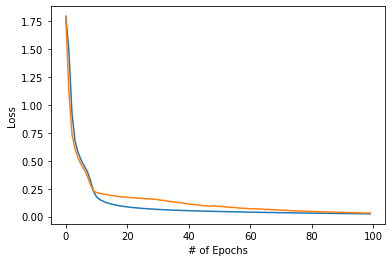

Training complete.
CPU Time:  1881.4666435718536 s
Epoch 1, Training Error: 1.790028902604369, Validation Error: 1.782464078415015
Epoch 2, Training Error: 1.483270927307859, Validation Error: 1.118601162602545
Epoch 3, Training Error: 0.925808875648689, Validation Error: 0.737209101407334
Epoch 4, Training Error: 0.674479910841441, Validation Error: 0.605286267465845
Epoch 5, Training Error: 0.572940270825204, Validation Error: 0.521810363582317
Epoch 6, Training Error: 0.503798898380773, Validation Error: 0.465374796359630
Epoch 7, Training Error: 0.452830964238901, Validation Error: 0.419396166696643
Epoch 8, Training Error: 0.402633907290762, Validation Error: 0.363960593922322
Epoch 9, Training Error: 0.325415444004328, Validation Error: 0.285524124915289
Epoch 10, Training Error: 0.226503148527499, Validation Error: 0.230233006813106
Epoch 11, Training Error: 0.176775275928216, Validation Error: 0.215725730810104
Epoch 12, Training Error: 0.153980606698686, Validation Error: 0.20

In [7]:
Case1.train(traindata,trainlabel,100)

Test Accuracy: 92.67%
Class 1: 12 misclassifications
Class 2: 47 misclassifications
Class 3: 31 misclassifications
Class 4: 82 misclassifications
Class 5: 17 misclassifications
Class 6: 27 misclassifications


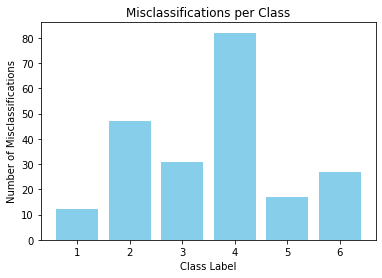

In [8]:
Case1.test_accuracy(testdata,testlabel)

Test Accuracy: 99.37%
Class 1: 0 misclassifications
Class 2: 0 misclassifications
Class 3: 0 misclassifications
Class 4: 36 misclassifications
Class 5: 10 misclassifications
Class 6: 0 misclassifications


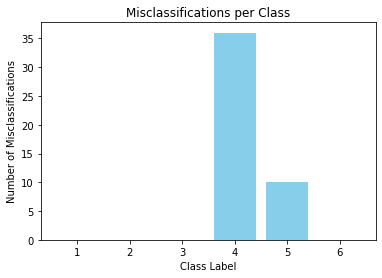

In [9]:
Case1.test_accuracy(traindata,trainlabel)

### Case 2 

##### n= 0.001 N1= 300 N2= 100 momentum= 0 batch= 50

In [10]:
Case2= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.001,batch_size=50,momentum=0.0)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.90batch/s]

Epoch:  1
Train error: 1.791223503
Validation Error: 1.791735403



Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.77batch/s]

Epoch:  2
Train error: 1.791202779
Validation Error: 1.791713738



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]

Epoch:  3
Train error: 1.791181717
Validation Error: 1.791691592



Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.41batch/s]


Epoch:  4
Train error: 1.791160317
Validation Error: 1.791669126


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 218.23batch/s]

Epoch:  5
Train error: 1.791138548
Validation Error: 1.791646284



Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.88batch/s]

Epoch:  6
Train error: 1.791116498
Validation Error: 1.791623223



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.11batch/s]

Epoch:  7
Train error: 1.791094310
Validation Error: 1.791599995



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.66batch/s]

Epoch:  8
Train error: 1.791071773
Validation Error: 1.791576250



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.58batch/s]

Epoch:  9
Train error: 1.791048646
Validation Error: 1.791551759



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.78batch/s]

Epoch:  10
Train error: 1.791024743
Validation Error: 1.791526393



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.93batch/s]

Epoch:  11
Train error: 1.790999980
Validation Error: 1.791500126



Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.78batch/s]

Epoch:  12
Train error: 1.790974320
Validation Error: 1.791472839



Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.25batch/s]

Epoch:  13
Train error: 1.790947553
Validation Error: 1.791444242



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  14
Train error: 1.790919455
Validation Error: 1.791414081



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.92batch/s]

Epoch:  15
Train error: 1.790889795
Validation Error: 1.791382111



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.25batch/s]

Epoch:  16
Train error: 1.790858290
Validation Error: 1.791348134



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.33batch/s]

Epoch:  17
Train error: 1.790824696
Validation Error: 1.791311860



Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]


Epoch:  18
Train error: 1.790788826
Validation Error: 1.791273120


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.34batch/s]

Epoch:  19
Train error: 1.790750465
Validation Error: 1.791231667



Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 224.19batch/s]

Epoch:  20
Train error: 1.790709351
Validation Error: 1.791187202



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  21
Train error: 1.790665197
Validation Error: 1.791139335



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.24batch/s]

Epoch:  22
Train error: 1.790617663
Validation Error: 1.791087753



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.59batch/s]


Epoch:  23
Train error: 1.790566427
Validation Error: 1.791032079


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.34batch/s]

Epoch:  24
Train error: 1.790511108
Validation Error: 1.790971947



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.24batch/s]

Epoch:  25
Train error: 1.790451267
Validation Error: 1.790906825



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 227.50batch/s]

Epoch:  26
Train error: 1.790386372
Validation Error: 1.790836003



Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.48batch/s]


Epoch:  27
Train error: 1.790315734
Validation Error: 1.790758785


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.23batch/s]

Epoch:  28
Train error: 1.790238601
Validation Error: 1.790674357



Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.61batch/s]

Epoch:  29
Train error: 1.790154124
Validation Error: 1.790581751



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  30
Train error: 1.790061322
Validation Error: 1.790479887



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.39batch/s]

Epoch:  31
Train error: 1.789959074
Validation Error: 1.790367506



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.93batch/s]

Epoch:  32
Train error: 1.789846054
Validation Error: 1.790243168



Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  33
Train error: 1.789720781
Validation Error: 1.790105190



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 208.04batch/s]

Epoch:  34
Train error: 1.789581503
Validation Error: 1.789951597



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.77batch/s]


Epoch:  35
Train error: 1.789426237
Validation Error: 1.789780112


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]


Epoch:  36
Train error: 1.789252567
Validation Error: 1.789588041


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.17batch/s]

Epoch:  37
Train error: 1.789057623
Validation Error: 1.789372185



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.02batch/s]

Epoch:  38
Train error: 1.788837993
Validation Error: 1.789128618



Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]


Epoch:  39
Train error: 1.788589631
Validation Error: 1.788852726


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.60batch/s]

Epoch:  40
Train error: 1.788307641
Validation Error: 1.788538915



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.22batch/s]

Epoch:  41
Train error: 1.787986084
Validation Error: 1.788180399



Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.94batch/s]


Epoch:  42
Train error: 1.787617844
Validation Error: 1.787769121


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.31batch/s]

Epoch:  43
Train error: 1.787194488
Validation Error: 1.787295445



Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 227.36batch/s]

Epoch:  44
Train error: 1.786705607
Validation Error: 1.786747378



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.45batch/s]

Epoch:  45
Train error: 1.786138274
Validation Error: 1.786109918



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.38batch/s]

Epoch:  46
Train error: 1.785476380
Validation Error: 1.785364330



Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.39batch/s]

Epoch:  47
Train error: 1.784699750
Validation Error: 1.784487241



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.94batch/s]

Epoch:  48
Train error: 1.783783129
Validation Error: 1.783449146



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.67batch/s]

Epoch:  49
Train error: 1.782694509
Validation Error: 1.782212557



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.22batch/s]

Epoch:  50
Train error: 1.781393029
Validation Error: 1.780729571



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.22batch/s]

Epoch:  51
Train error: 1.779826625
Validation Error: 1.778939284



Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.56batch/s]

Epoch:  52
Train error: 1.777928892
Validation Error: 1.776763606



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  53
Train error: 1.775614458
Validation Error: 1.774102207



Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.22batch/s]

Epoch:  54
Train error: 1.772773887
Validation Error: 1.770826897



Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.90batch/s]

Epoch:  55
Train error: 1.769268058
Validation Error: 1.766775986



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.87batch/s]


Epoch:  56
Train error: 1.764922840
Validation Error: 1.761748606


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.04batch/s]

Epoch:  57
Train error: 1.759524703
Validation Error: 1.755502813



Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.86batch/s]


Epoch:  58
Train error: 1.752823080
Validation Error: 1.747763701


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 184.59batch/s]


Epoch:  59
Train error: 1.744543444
Validation Error: 1.738242979


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.37batch/s]


Epoch:  60
Train error: 1.734416697
Validation Error: 1.726685607


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.57batch/s]

Epoch:  61
Train error: 1.722232380
Validation Error: 1.712933652



Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.72batch/s]

Epoch:  62
Train error: 1.707899039
Validation Error: 1.696984407



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.72batch/s]

Epoch:  63
Train error: 1.691479800
Validation Error: 1.679003650



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.91batch/s]


Epoch:  64
Train error: 1.673164267
Validation Error: 1.659251163


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.64batch/s]

Epoch:  65
Train error: 1.653179515
Validation Error: 1.637986278



Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.44batch/s]

Epoch:  66
Train error: 1.631808928
Validation Error: 1.615629769



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.58batch/s]

Epoch:  67
Train error: 1.609725624
Validation Error: 1.593165879



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.34batch/s]

Epoch:  68
Train error: 1.587879664
Validation Error: 1.571511127



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.79batch/s]

Epoch:  69
Train error: 1.567245101
Validation Error: 1.551380435



Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.85batch/s]

Epoch:  70
Train error: 1.548540458
Validation Error: 1.533319401



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.21batch/s]

Epoch:  71
Train error: 1.532023152
Validation Error: 1.517342679



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.72batch/s]

Epoch:  72
Train error: 1.517533837
Validation Error: 1.503396434



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.42batch/s]

Epoch:  73
Train error: 1.504967616
Validation Error: 1.491339408



Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 222.13batch/s]

Epoch:  74
Train error: 1.494227131
Validation Error: 1.480998449



Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.60batch/s]

Epoch:  75
Train error: 1.485130991
Validation Error: 1.472208480



Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.39batch/s]

Epoch:  76
Train error: 1.477377694
Validation Error: 1.464712706



Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  77
Train error: 1.470689721
Validation Error: 1.458223086



Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.64batch/s]

Epoch:  78
Train error: 1.464826268
Validation Error: 1.452470038



Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.42batch/s]

Epoch:  79
Train error: 1.459543086
Validation Error: 1.447235266



Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.56batch/s]


Epoch:  80
Train error: 1.454631879
Validation Error: 1.442334838


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.45batch/s]

Epoch:  81
Train error: 1.449921589
Validation Error: 1.437609287



Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.56batch/s]

Epoch:  82
Train error: 1.445249971
Validation Error: 1.432888025



Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.71batch/s]

Epoch:  83
Train error: 1.440435432
Validation Error: 1.427973642



Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.52batch/s]

Epoch:  84
Train error: 1.435283025
Validation Error: 1.422644623



Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.51batch/s]

Epoch:  85
Train error: 1.429570677
Validation Error: 1.416635749



Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.34batch/s]

Epoch:  86
Train error: 1.423034409
Validation Error: 1.409633169



Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.35batch/s]


Epoch:  87
Train error: 1.415331466
Validation Error: 1.401245376


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 219.53batch/s]

Epoch:  88
Train error: 1.406020640
Validation Error: 1.390993209



Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.36batch/s]

Epoch:  89
Train error: 1.394577810
Validation Error: 1.378307470



Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.62batch/s]

Epoch:  90
Train error: 1.380358853
Validation Error: 1.362521057



Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.57batch/s]

Epoch:  91
Train error: 1.362724474
Validation Error: 1.343060455



Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.76batch/s]

Epoch:  92
Train error: 1.341257113
Validation Error: 1.319720745



Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 219.54batch/s]

Epoch:  93
Train error: 1.316114158
Validation Error: 1.293082216



Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.38batch/s]

Epoch:  94
Train error: 1.288403192
Validation Error: 1.264779058



Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.77batch/s]


Epoch:  95
Train error: 1.260166842
Validation Error: 1.237159192


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 197.80batch/s]

Epoch:  96
Train error: 1.233704603
Validation Error: 1.212363071



Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 211.23batch/s]

Epoch:  97
Train error: 1.210592790
Validation Error: 1.191466481



Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.76batch/s]

Epoch:  98
Train error: 1.191285028
Validation Error: 1.174521565



Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.35batch/s]

Epoch:  99
Train error: 1.175456500
Validation Error: 1.160980533



Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.36batch/s]

Epoch:  100
Train error: 1.162481232
Validation Error: 1.150091402


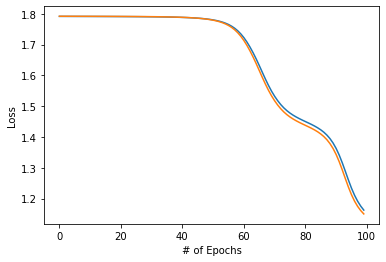

Training complete.
CPU Time:  66.1738350391388 s
Epoch 1, Training Error: 1.791223503356455, Validation Error: 1.791735402555658
Epoch 2, Training Error: 1.791202778755907, Validation Error: 1.791713738008357
Epoch 3, Training Error: 1.791181716756312, Validation Error: 1.791691592088967
Epoch 4, Training Error: 1.791160316807444, Validation Error: 1.791669126169668
Epoch 5, Training Error: 1.791138548167004, Validation Error: 1.791646283824891
Epoch 6, Training Error: 1.791116498138208, Validation Error: 1.791623222830106
Epoch 7, Training Error: 1.791094309840048, Validation Error: 1.791599994829375
Epoch 8, Training Error: 1.791071772925838, Validation Error: 1.791576250031945
Epoch 9, Training Error: 1.791048645893163, Validation Error: 1.791551758805509
Epoch 10, Training Error: 1.791024743342253, Validation Error: 1.791526393283218
Epoch 11, Training Error: 1.790999980484909, Validation Error: 1.791500126178411
Epoch 12, Training Error: 1.790974320294213, Validation Error: 1.7914

In [11]:
Case2.train(traindata,trainlabel,100)

Test Accuracy: 42.21%
Class 1: 0 misclassifications
Class 2: 441 misclassifications
Class 3: 403 misclassifications
Class 4: 491 misclassifications
Class 5: 268 misclassifications
Class 6: 73 misclassifications


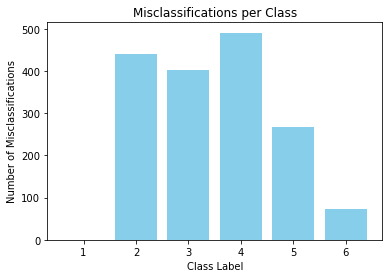

In [12]:
Case2.test_accuracy(testdata,testlabel)

Test Accuracy: 40.76%
Class 1: 0 misclassifications
Class 2: 1103 misclassifications
Class 3: 1042 misclassifications
Class 4: 1217 misclassifications
Class 5: 760 misclassifications
Class 6: 232 misclassifications


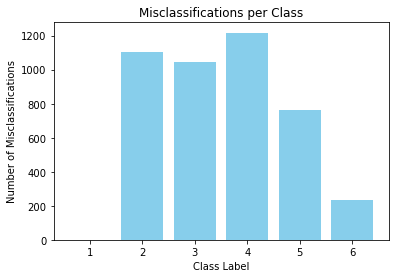

In [13]:
Case2.test_accuracy(traindata,trainlabel)

### Case 3

##### n= 0.001 N1= 300 N2= 100 momentum= 0.9 batch= 0

In [14]:
Case3= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.001,batch_size=1,momentum=0.9)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.93batch/s]


Epoch:  1
Train error: 1.657673900
Validation Error: 1.304932646


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 380.64batch/s]


Epoch:  2
Train error: 0.922079154
Validation Error: 0.700525868


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.59batch/s]


Epoch:  3
Train error: 0.623506051
Validation Error: 0.539615225


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 380.89batch/s]


Epoch:  4
Train error: 0.505597379
Validation Error: 0.444159381


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.38batch/s]


Epoch:  5
Train error: 0.420640293
Validation Error: 0.379307707


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.87batch/s]


Epoch:  6
Train error: 0.335939212
Validation Error: 0.345729575


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.36batch/s]


Epoch:  7
Train error: 0.261770717
Validation Error: 0.277994187


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.43batch/s]


Epoch:  8
Train error: 0.191196660
Validation Error: 0.230649610


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.41batch/s]


Epoch:  9
Train error: 0.153461447
Validation Error: 0.229894121


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.50batch/s]


Epoch:  10
Train error: 0.132916708
Validation Error: 0.224998652


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.15batch/s]


Epoch:  11
Train error: 0.119106587
Validation Error: 0.219012727


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 376.52batch/s]


Epoch:  12
Train error: 0.108691732
Validation Error: 0.210433965


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.82batch/s]


Epoch:  13
Train error: 0.100698908
Validation Error: 0.208747601


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.21batch/s]


Epoch:  14
Train error: 0.094224696
Validation Error: 0.206736777


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.07batch/s]


Epoch:  15
Train error: 0.089202610
Validation Error: 0.199892785


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.59batch/s]


Epoch:  16
Train error: 0.084691055
Validation Error: 0.196951728


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.81batch/s]


Epoch:  17
Train error: 0.080469542
Validation Error: 0.193117838


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.51batch/s]


Epoch:  18
Train error: 0.077211390
Validation Error: 0.190884021


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 376.83batch/s]


Epoch:  19
Train error: 0.074080884
Validation Error: 0.188915536


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.69batch/s]


Epoch:  20
Train error: 0.071280764
Validation Error: 0.186334444


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 379.26batch/s]


Epoch:  21
Train error: 0.068576300
Validation Error: 0.184871971


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 352.41batch/s]


Epoch:  22
Train error: 0.066315932
Validation Error: 0.180324841


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 379.31batch/s]


Epoch:  23
Train error: 0.064419569
Validation Error: 0.168569537


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.17batch/s]


Epoch:  24
Train error: 0.062619113
Validation Error: 0.161876126


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.00batch/s]


Epoch:  25
Train error: 0.060877043
Validation Error: 0.162363391


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 381.04batch/s]


Epoch:  26
Train error: 0.059061882
Validation Error: 0.152720346


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 354.36batch/s]


Epoch:  27
Train error: 0.057431232
Validation Error: 0.148024409


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 379.46batch/s]


Epoch:  28
Train error: 0.056173156
Validation Error: 0.138237397


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.40batch/s]


Epoch:  29
Train error: 0.054474840
Validation Error: 0.134596189


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.39batch/s]


Epoch:  30
Train error: 0.053250066
Validation Error: 0.136926384


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 377.46batch/s]


Epoch:  31
Train error: 0.051915447
Validation Error: 0.122345782


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 357.77batch/s]


Epoch:  32
Train error: 0.050531748
Validation Error: 0.128048187


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 378.80batch/s]


Epoch:  33
Train error: 0.049622546
Validation Error: 0.123690415


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.00batch/s]


Epoch:  34
Train error: 0.048634796
Validation Error: 0.111263309


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.17batch/s]


Epoch:  35
Train error: 0.047273772
Validation Error: 0.115766593


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.92batch/s]


Epoch:  36
Train error: 0.046487588
Validation Error: 0.101814356


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.72batch/s]


Epoch:  37
Train error: 0.045049709
Validation Error: 0.094952846


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 378.58batch/s]


Epoch:  38
Train error: 0.044807319
Validation Error: 0.083957647


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.05batch/s]


Epoch:  39
Train error: 0.043504239
Validation Error: 0.104549267


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.75batch/s]


Epoch:  40
Train error: 0.042749100
Validation Error: 0.084653687


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.67batch/s]


Epoch:  41
Train error: 0.041854695
Validation Error: 0.079831870


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 359.84batch/s]


Epoch:  42
Train error: 0.041500217
Validation Error: 0.081026336


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.97batch/s]


Epoch:  43
Train error: 0.040235771
Validation Error: 0.066233937


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 356.71batch/s]


Epoch:  44
Train error: 0.039028893
Validation Error: 0.070448940


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 376.03batch/s]


Epoch:  45
Train error: 0.038948353
Validation Error: 0.069610311


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 359.23batch/s]


Epoch:  46
Train error: 0.037888198
Validation Error: 0.057606691


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.74batch/s]


Epoch:  47
Train error: 0.036446482
Validation Error: 0.060151416


Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 355.66batch/s]


Epoch:  48
Train error: 0.037295136
Validation Error: 0.069961184


Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 377.76batch/s]


Epoch:  49
Train error: 0.035115430
Validation Error: 0.060417856


Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.21batch/s]


Epoch:  50
Train error: 0.034913620
Validation Error: 0.059099912


Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.32batch/s]


Epoch:  51
Train error: 0.034208685
Validation Error: 0.061415052


Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.25batch/s]


Epoch:  52
Train error: 0.033435891
Validation Error: 0.086569998


Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.66batch/s]


Epoch:  53
Train error: 0.033013313
Validation Error: 0.057373119


Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 312.81batch/s]


Epoch:  54
Train error: 0.032979779
Validation Error: 0.061554719


Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 308.29batch/s]


Epoch:  55
Train error: 0.031469013
Validation Error: 0.047319318


Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.32batch/s]


Epoch:  56
Train error: 0.030784205
Validation Error: 0.067492269


Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.61batch/s]


Epoch:  57
Train error: 0.030230114
Validation Error: 0.063917658


Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 292.95batch/s]


Epoch:  58
Train error: 0.030058149
Validation Error: 0.045799030


Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 301.81batch/s]


Epoch:  59
Train error: 0.028713214
Validation Error: 0.045264132


Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 295.88batch/s]


Epoch:  60
Train error: 0.028708460
Validation Error: 0.065986154


Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:23<00:00, 280.68batch/s]


Epoch:  61
Train error: 0.027826256
Validation Error: 0.037603154


Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 326.00batch/s]


Epoch:  62
Train error: 0.026302386
Validation Error: 0.035018609


Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 295.96batch/s]


Epoch:  63
Train error: 0.024699916
Validation Error: 0.041185174


Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 322.82batch/s]


Epoch:  64
Train error: 0.026679342
Validation Error: 0.122004906


Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 357.74batch/s]


Epoch:  65
Train error: 0.025798550
Validation Error: 0.036370681


Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.77batch/s]


Epoch:  66
Train error: 0.025351606
Validation Error: 0.050289037


Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 317.62batch/s]


Epoch:  67
Train error: 0.024199173
Validation Error: 0.040086422


Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 311.76batch/s]


Epoch:  68
Train error: 0.023278261
Validation Error: 0.035191739


Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 317.06batch/s]


Epoch:  69
Train error: 0.022467649
Validation Error: 0.039738739


Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.10batch/s]


Epoch:  70
Train error: 0.024592493
Validation Error: 0.230404335


Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 353.70batch/s]


Epoch:  71
Train error: 0.022080841
Validation Error: 0.033506411


Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.99batch/s]


Epoch:  72
Train error: 0.020846746
Validation Error: 0.032402775


Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.23batch/s]


Epoch:  73
Train error: 0.022804998
Validation Error: 0.039565985


Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 375.15batch/s]


Epoch:  74
Train error: 0.020851887
Validation Error: 0.031419240


Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 347.33batch/s]


Epoch:  75
Train error: 0.023739349
Validation Error: 0.033400825


Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.73batch/s]


Epoch:  76
Train error: 0.021156826
Validation Error: 0.030805036


Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.80batch/s]


Epoch:  77
Train error: 0.021243149
Validation Error: 0.027462143


Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 373.48batch/s]


Epoch:  78
Train error: 0.018897270
Validation Error: 0.030162891


Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.28batch/s]


Epoch:  79
Train error: 0.020237310
Validation Error: 0.028513515


Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 376.82batch/s]


Epoch:  80
Train error: 0.018564829
Validation Error: 0.035669645


Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.32batch/s]


Epoch:  81
Train error: 0.017346974
Validation Error: 0.033261283


Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.80batch/s]


Epoch:  82
Train error: 0.019744849
Validation Error: 0.071873198


Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.87batch/s]


Epoch:  83
Train error: 0.019310399
Validation Error: 0.035209151


Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 357.36batch/s]


Epoch:  84
Train error: 0.017516178
Validation Error: 0.027785659


Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.99batch/s]


Epoch:  85
Train error: 0.019778776
Validation Error: 0.048180379


Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.51batch/s]


Epoch:  86
Train error: 0.016527757
Validation Error: 0.031041326


Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 315.64batch/s]


Training Stopped


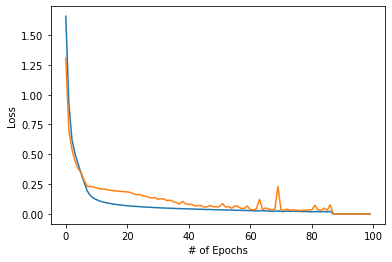

Training complete.
CPU Time:  1631.539638519287 s
Epoch 1, Training Error: 1.657673899849655, Validation Error: 1.304932646113590
Epoch 2, Training Error: 0.922079153540132, Validation Error: 0.700525868490366
Epoch 3, Training Error: 0.623506050500622, Validation Error: 0.539615224818442
Epoch 4, Training Error: 0.505597378920213, Validation Error: 0.444159380616087
Epoch 5, Training Error: 0.420640293270705, Validation Error: 0.379307706906649
Epoch 6, Training Error: 0.335939212350975, Validation Error: 0.345729574828715
Epoch 7, Training Error: 0.261770716749309, Validation Error: 0.277994186676722
Epoch 8, Training Error: 0.191196660232686, Validation Error: 0.230649609664968
Epoch 9, Training Error: 0.153461447179481, Validation Error: 0.229894120525051
Epoch 10, Training Error: 0.132916707503748, Validation Error: 0.224998651870982
Epoch 11, Training Error: 0.119106587291665, Validation Error: 0.219012727423002
Epoch 12, Training Error: 0.108691732106792, Validation Error: 0.210

In [15]:
Case3.train(traindata,trainlabel,100)

Test Accuracy: 91.04%
Class 1: 7 misclassifications
Class 2: 62 misclassifications
Class 3: 27 misclassifications
Class 4: 137 misclassifications
Class 5: 5 misclassifications
Class 6: 26 misclassifications


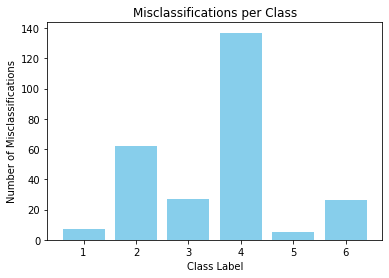

In [16]:
Case3.test_accuracy(testdata,testlabel)

Test Accuracy: 98.20%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 130 misclassifications
Class 5: 0 misclassifications
Class 6: 0 misclassifications


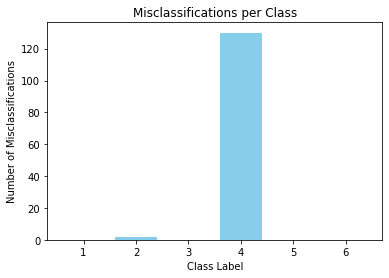

In [17]:
Case3.test_accuracy(traindata,trainlabel)

### Case 4

##### n= 0.001 N1= 300 N2= 100 momentum= 0.9 batch= 50

In [18]:
Case4= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.001,batch_size=50,momentum=0.9)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.48batch/s]

Epoch:  1
Train error: 1.791125265
Validation Error: 1.791626928



Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.07batch/s]

Epoch:  2
Train error: 1.791075377
Validation Error: 1.791573536



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.04batch/s]

Epoch:  3
Train error: 1.791023235
Validation Error: 1.791517234



Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.73batch/s]

Epoch:  4
Train error: 1.790967792
Validation Error: 1.791456706



Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 220.47batch/s]


Epoch:  5
Train error: 1.790907651
Validation Error: 1.791390186


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.36batch/s]

Epoch:  6
Train error: 1.790841192
Validation Error: 1.791316122



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 208.89batch/s]

Epoch:  7
Train error: 1.790766962
Validation Error: 1.791233082



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 187.15batch/s]

Epoch:  8
Train error: 1.790683168
Validation Error: 1.791138871



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.37batch/s]

Epoch:  9
Train error: 1.790587367
Validation Error: 1.791030722



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.76batch/s]

Epoch:  10
Train error: 1.790476623
Validation Error: 1.790905108



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]


Epoch:  11
Train error: 1.790347203
Validation Error: 1.790757514


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.23batch/s]

Epoch:  12
Train error: 1.790194276
Validation Error: 1.790582662



Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.74batch/s]

Epoch:  13
Train error: 1.790012130
Validation Error: 1.790373696



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.18batch/s]

Epoch:  14
Train error: 1.789793150
Validation Error: 1.790121343



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]


Epoch:  15
Train error: 1.789526710
Validation Error: 1.789812558


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.71batch/s]

Epoch:  16
Train error: 1.789198347
Validation Error: 1.789429739



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.77batch/s]

Epoch:  17
Train error: 1.788788158
Validation Error: 1.788948542



Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.83batch/s]

Epoch:  18
Train error: 1.788268517
Validation Error: 1.788335085



Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.94batch/s]


Epoch:  19
Train error: 1.787600437
Validation Error: 1.787540776


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.60batch/s]

Epoch:  20
Train error: 1.786727442
Validation Error: 1.786494592



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  21
Train error: 1.785565554
Validation Error: 1.785090086



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.58batch/s]

Epoch:  22
Train error: 1.783988083
Validation Error: 1.783165172



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]

Epoch:  23
Train error: 1.781799677
Validation Error: 1.780466957



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 219.58batch/s]

Epoch:  24
Train error: 1.778692367
Validation Error: 1.776593154



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.02batch/s]

Epoch:  25
Train error: 1.774173674
Validation Error: 1.770900459



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.76batch/s]


Epoch:  26
Train error: 1.767458435
Validation Error: 1.762370840


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.06batch/s]

Epoch:  27
Train error: 1.757334056
Validation Error: 1.749482220



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.19batch/s]

Epoch:  28
Train error: 1.742110424
Validation Error: 1.730301207



Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 217.40batch/s]

Epoch:  29
Train error: 1.719983066
Validation Error: 1.703252933



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.96batch/s]

Epoch:  30
Train error: 1.690096870
Validation Error: 1.668466177



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.61batch/s]

Epoch:  31
Train error: 1.653302372
Validation Error: 1.627728011



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.60batch/s]

Epoch:  32
Train error: 1.612119558
Validation Error: 1.585224952



Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]

Epoch:  33
Train error: 1.571849137
Validation Error: 1.546800685



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.15batch/s]

Epoch:  34
Train error: 1.537837994
Validation Error: 1.515742419



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.39batch/s]

Epoch:  35
Train error: 1.511353658
Validation Error: 1.492049508



Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 219.15batch/s]

Epoch:  36
Train error: 1.491689876
Validation Error: 1.474663966



Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.60batch/s]

Epoch:  37
Train error: 1.477477470
Validation Error: 1.462007045



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.44batch/s]


Epoch:  38
Train error: 1.466939827
Validation Error: 1.452459866


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.42batch/s]

Epoch:  39
Train error: 1.458718657
Validation Error: 1.444850552



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 177.36batch/s]

Epoch:  40
Train error: 1.451774001
Validation Error: 1.438258641



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.18batch/s]


Epoch:  41
Train error: 1.445327235
Validation Error: 1.431938154


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.35batch/s]

Epoch:  42
Train error: 1.438680132
Validation Error: 1.425087298



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.53batch/s]

Epoch:  43
Train error: 1.431090921
Validation Error: 1.416761148



Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 199.81batch/s]

Epoch:  44
Train error: 1.421409329
Validation Error: 1.405553414



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.93batch/s]

Epoch:  45
Train error: 1.407739499
Validation Error: 1.389119680



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.89batch/s]


Epoch:  46
Train error: 1.387088382
Validation Error: 1.363863415


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 180.92batch/s]

Epoch:  47
Train error: 1.355361347
Validation Error: 1.325608154



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.92batch/s]

Epoch:  48
Train error: 1.309960131
Validation Error: 1.274571263



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 204.56batch/s]

Epoch:  49
Train error: 1.256510133
Validation Error: 1.221987301



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.99batch/s]

Epoch:  50
Train error: 1.208829953
Validation Error: 1.181286743



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.38batch/s]

Epoch:  51
Train error: 1.174383943
Validation Error: 1.154058043



Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.94batch/s]

Epoch:  52
Train error: 1.150713134
Validation Error: 1.135791127



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.15batch/s]

Epoch:  53
Train error: 1.133674632
Validation Error: 1.122493731



Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.37batch/s]

Epoch:  54
Train error: 1.120398685
Validation Error: 1.111688051



Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.47batch/s]

Epoch:  55
Train error: 1.109050610
Validation Error: 1.101964029



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 206.09batch/s]

Epoch:  56
Train error: 1.098466993
Validation Error: 1.092466355



Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.38batch/s]


Epoch:  57
Train error: 1.087862732
Validation Error: 1.082599023


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.22batch/s]

Epoch:  58
Train error: 1.076669108
Validation Error: 1.071877164



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.36batch/s]

Epoch:  59
Train error: 1.064425540
Validation Error: 1.059879685



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.86batch/s]

Epoch:  60
Train error: 1.050758226
Validation Error: 1.046244419



Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.68batch/s]

Epoch:  61
Train error: 1.035391447
Validation Error: 1.030708723



Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.36batch/s]

Epoch:  62
Train error: 1.018154963
Validation Error: 1.013106762



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 177.87batch/s]

Epoch:  63
Train error: 0.999022025
Validation Error: 0.993433038



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.41batch/s]

Epoch:  64
Train error: 0.978149790
Validation Error: 0.971908327



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.38batch/s]

Epoch:  65
Train error: 0.955923498
Validation Error: 0.948972318



Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.37batch/s]

Epoch:  66
Train error: 0.932890077
Validation Error: 0.925208865



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.26batch/s]

Epoch:  67
Train error: 0.909698244
Validation Error: 0.901340928



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.17batch/s]

Epoch:  68
Train error: 0.886999933
Validation Error: 0.877991100



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]


Epoch:  69
Train error: 0.865362621
Validation Error: 0.855756565


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.27batch/s]

Epoch:  70
Train error: 0.845158835
Validation Error: 0.834990358



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.71batch/s]

Epoch:  71
Train error: 0.826607453
Validation Error: 0.815956468



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 216.64batch/s]

Epoch:  72
Train error: 0.809757053
Validation Error: 0.798633402



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.34batch/s]

Epoch:  73
Train error: 0.794500675
Validation Error: 0.782951998



Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.43batch/s]

Epoch:  74
Train error: 0.780723860
Validation Error: 0.768814931



Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]

Epoch:  75
Train error: 0.768285090
Validation Error: 0.756069877



Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.35batch/s]

Epoch:  76
Train error: 0.756992323
Validation Error: 0.744531122



Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.79batch/s]

Epoch:  77
Train error: 0.746695548
Validation Error: 0.734055769



Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]

Epoch:  78
Train error: 0.737229215
Validation Error: 0.724474160



Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 204.14batch/s]

Epoch:  79
Train error: 0.728479320
Validation Error: 0.715691591



Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.18batch/s]

Epoch:  80
Train error: 0.720315530
Validation Error: 0.707550192



Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.43batch/s]

Epoch:  81
Train error: 0.712668652
Validation Error: 0.699984845



Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 220.54batch/s]

Epoch:  82
Train error: 0.705453268
Validation Error: 0.692903210



Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.51batch/s]

Epoch:  83
Train error: 0.698615892
Validation Error: 0.686224140



Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]


Epoch:  84
Train error: 0.692095172
Validation Error: 0.679909116


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.33batch/s]

Epoch:  85
Train error: 0.685847848
Validation Error: 0.673885757



Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.33batch/s]

Epoch:  86
Train error: 0.679840880
Validation Error: 0.668120853



Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.76batch/s]

Epoch:  87
Train error: 0.674042774
Validation Error: 0.662588291



Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.22batch/s]

Epoch:  88
Train error: 0.668439446
Validation Error: 0.657253361



Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.91batch/s]


Epoch:  89
Train error: 0.662991633
Validation Error: 0.652066818


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  90
Train error: 0.657664631
Validation Error: 0.647015960



Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  91
Train error: 0.652451407
Validation Error: 0.642089551



Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.35batch/s]

Epoch:  92
Train error: 0.647347500
Validation Error: 0.637269789



Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 220.83batch/s]

Epoch:  93
Train error: 0.642349789
Validation Error: 0.632564426



Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.57batch/s]

Epoch:  94
Train error: 0.637453432
Validation Error: 0.627956964



Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.21batch/s]

Epoch:  95
Train error: 0.632644833
Validation Error: 0.623429773



Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.16batch/s]

Epoch:  96
Train error: 0.627907999
Validation Error: 0.618959954



Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.86batch/s]

Epoch:  97
Train error: 0.623234918
Validation Error: 0.614567875



Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.08batch/s]

Epoch:  98
Train error: 0.618626664
Validation Error: 0.610226091



Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.18batch/s]

Epoch:  99
Train error: 0.614079856
Validation Error: 0.605950010



Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.90batch/s]


Epoch:  100
Train error: 0.609590871
Validation Error: 0.601727164


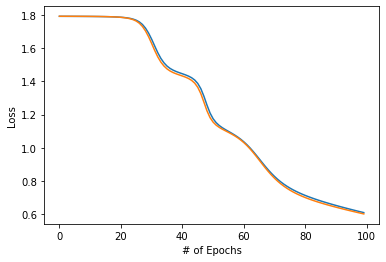

Training complete.
CPU Time:  68.06456851959229 s
Epoch 1, Training Error: 1.791125265120222, Validation Error: 1.791626927533104
Epoch 2, Training Error: 1.791075377175067, Validation Error: 1.791573536078555
Epoch 3, Training Error: 1.791023234739899, Validation Error: 1.791517234194364
Epoch 4, Training Error: 1.790967791520027, Validation Error: 1.791456706018840
Epoch 5, Training Error: 1.790907651153842, Validation Error: 1.791390186176586
Epoch 6, Training Error: 1.790841192464312, Validation Error: 1.791316122115651
Epoch 7, Training Error: 1.790766961951301, Validation Error: 1.791233081599728
Epoch 8, Training Error: 1.790683167865387, Validation Error: 1.791138871278260
Epoch 9, Training Error: 1.790587366968605, Validation Error: 1.791030721553611
Epoch 10, Training Error: 1.790476622501798, Validation Error: 1.790905107699293
Epoch 11, Training Error: 1.790347203054544, Validation Error: 1.790757513756885
Epoch 12, Training Error: 1.790194276132722, Validation Error: 1.790

In [19]:
Case4.train(traindata,trainlabel,100)

Test Accuracy: 71.17%
Class 1: 254 misclassifications
Class 2: 147 misclassifications
Class 3: 161 misclassifications
Class 4: 199 misclassifications
Class 5: 56 misclassifications
Class 6: 19 misclassifications


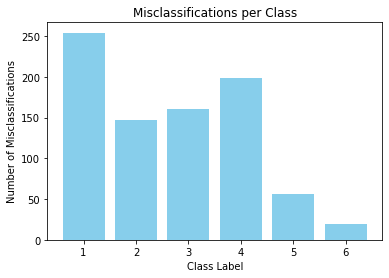

In [20]:
Case4.test_accuracy(testdata,testlabel)

Test Accuracy: 74.53%
Class 1: 513 misclassifications
Class 2: 511 misclassifications
Class 3: 194 misclassifications
Class 4: 506 misclassifications
Class 5: 144 misclassifications
Class 6: 4 misclassifications


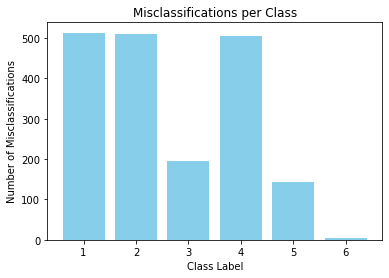

In [21]:
Case4.test_accuracy(traindata,trainlabel)

### Case 5

##### n= 0.001 N1= 300 N2= 200 momentum= 0 batch= 0

In [22]:
Case5= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.001,batch_size=1,momentum=0.0)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.54batch/s]


Epoch:  1
Train error: 1.778318218
Validation Error: 1.668036615


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.29batch/s]


Epoch:  2
Train error: 1.323977016
Validation Error: 1.064557232


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.52batch/s]


Epoch:  3
Train error: 0.855356185
Validation Error: 0.707581334


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 327.24batch/s]


Epoch:  4
Train error: 0.654397420
Validation Error: 0.589211201


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.49batch/s]


Epoch:  5
Train error: 0.558407559
Validation Error: 0.509491564


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.57batch/s]


Epoch:  6
Train error: 0.492364777
Validation Error: 0.455357837


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.55batch/s]


Epoch:  7
Train error: 0.441806871
Validation Error: 0.408586700


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 347.07batch/s]


Epoch:  8
Train error: 0.387491194
Validation Error: 0.351708087


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.97batch/s]


Epoch:  9
Train error: 0.295991025
Validation Error: 0.266367240


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.61batch/s]


Epoch:  10
Train error: 0.203100530
Validation Error: 0.224315559


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.27batch/s]


Epoch:  11
Train error: 0.164997095
Validation Error: 0.214625210


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.62batch/s]


Epoch:  12
Train error: 0.145352972
Validation Error: 0.208577788


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.18batch/s]


Epoch:  13
Train error: 0.131859448
Validation Error: 0.203001420


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.18batch/s]


Epoch:  14
Train error: 0.121546190
Validation Error: 0.196530734


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.51batch/s]


Epoch:  15
Train error: 0.113361749
Validation Error: 0.191761279


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.52batch/s]


Epoch:  16
Train error: 0.106580076
Validation Error: 0.187334308


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.27batch/s]


Epoch:  17
Train error: 0.100904726
Validation Error: 0.181769232


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.85batch/s]


Epoch:  18
Train error: 0.095864299
Validation Error: 0.180012831


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.95batch/s]


Epoch:  19
Train error: 0.091370761
Validation Error: 0.177292406


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.27batch/s]


Epoch:  20
Train error: 0.087653725
Validation Error: 0.175287900


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.68batch/s]


Epoch:  21
Train error: 0.084077803
Validation Error: 0.171116792


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.27batch/s]


Epoch:  22
Train error: 0.080815492
Validation Error: 0.172485339


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.82batch/s]


Epoch:  23
Train error: 0.078148412
Validation Error: 0.170552705


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.56batch/s]


Epoch:  24
Train error: 0.075552977
Validation Error: 0.167697385


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.19batch/s]


Epoch:  25
Train error: 0.073232941
Validation Error: 0.166590442


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.44batch/s]


Epoch:  26
Train error: 0.071111875
Validation Error: 0.162232446


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 347.58batch/s]


Epoch:  27
Train error: 0.069234053
Validation Error: 0.160514197


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.74batch/s]


Epoch:  28
Train error: 0.067335427
Validation Error: 0.156436734


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 349.24batch/s]


Epoch:  29
Train error: 0.065751135
Validation Error: 0.152328062


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.61batch/s]


Epoch:  30
Train error: 0.064217221
Validation Error: 0.151336208


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.60batch/s]


Epoch:  31
Train error: 0.062860973
Validation Error: 0.145354163


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.90batch/s]


Epoch:  32
Train error: 0.061517905
Validation Error: 0.143038599


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.81batch/s]


Epoch:  33
Train error: 0.060201125
Validation Error: 0.139154572


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.95batch/s]


Epoch:  34
Train error: 0.058950500
Validation Error: 0.133908344


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.09batch/s]


Epoch:  35
Train error: 0.057826255
Validation Error: 0.127799457


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.21batch/s]


Epoch:  36
Train error: 0.056675320
Validation Error: 0.124699406


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.82batch/s]


Epoch:  37
Train error: 0.055823096
Validation Error: 0.118794098


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.03batch/s]


Epoch:  38
Train error: 0.054836954
Validation Error: 0.114802823


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.12batch/s]


Epoch:  39
Train error: 0.053878917
Validation Error: 0.113275007


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.81batch/s]


Epoch:  40
Train error: 0.053105344
Validation Error: 0.110915244


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.66batch/s]


Epoch:  41
Train error: 0.052342032
Validation Error: 0.105244641


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.72batch/s]


Epoch:  42
Train error: 0.051378226
Validation Error: 0.105271565


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 347.58batch/s]


Epoch:  43
Train error: 0.050506790
Validation Error: 0.101801735


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.79batch/s]


Epoch:  44
Train error: 0.049909051
Validation Error: 0.094733119


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.08batch/s]


Epoch:  45
Train error: 0.049205449
Validation Error: 0.090965493


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.65batch/s]


Epoch:  46
Train error: 0.048357475
Validation Error: 0.092608939


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.03batch/s]


Epoch:  47
Train error: 0.047667836
Validation Error: 0.089983187


Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.10batch/s]


Epoch:  48
Train error: 0.046886357
Validation Error: 0.087679321


Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.68batch/s]


Epoch:  49
Train error: 0.046333295
Validation Error: 0.082574024


Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 351.00batch/s]


Epoch:  50
Train error: 0.045490141
Validation Error: 0.081285651


Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.82batch/s]


Epoch:  51
Train error: 0.044943944
Validation Error: 0.082041757


Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.91batch/s]


Epoch:  52
Train error: 0.044320345
Validation Error: 0.079700258


Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.03batch/s]


Epoch:  53
Train error: 0.043773042
Validation Error: 0.080163409


Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.93batch/s]


Epoch:  54
Train error: 0.043174536
Validation Error: 0.072399093


Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.96batch/s]


Epoch:  55
Train error: 0.042667825
Validation Error: 0.072490778


Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.16batch/s]


Epoch:  56
Train error: 0.041852760
Validation Error: 0.070495348


Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.75batch/s]


Epoch:  57
Train error: 0.041358432
Validation Error: 0.070711625


Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 324.90batch/s]


Epoch:  58
Train error: 0.040876399
Validation Error: 0.072089691


Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.13batch/s]


Epoch:  59
Train error: 0.040372503
Validation Error: 0.067525995


Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.33batch/s]


Epoch:  60
Train error: 0.039849011
Validation Error: 0.064955484


Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.15batch/s]


Epoch:  61
Train error: 0.039278170
Validation Error: 0.063381335


Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.70batch/s]


Epoch:  62
Train error: 0.038811994
Validation Error: 0.064433147


Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.23batch/s]


Epoch:  63
Train error: 0.038457788
Validation Error: 0.064543667


Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.09batch/s]


Epoch:  64
Train error: 0.038065403
Validation Error: 0.060898621


Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.37batch/s]


Epoch:  65
Train error: 0.037491885
Validation Error: 0.063121733


Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.81batch/s]


Epoch:  66
Train error: 0.036996367
Validation Error: 0.059557538


Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.63batch/s]


Epoch:  67
Train error: 0.036424173
Validation Error: 0.060523586


Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.53batch/s]


Epoch:  68
Train error: 0.036164221
Validation Error: 0.059418602


Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.58batch/s]


Epoch:  69
Train error: 0.035858723
Validation Error: 0.058853945


Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.00batch/s]


Epoch:  70
Train error: 0.035191288
Validation Error: 0.056785231


Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.98batch/s]


Epoch:  71
Train error: 0.034821499
Validation Error: 0.054796717


Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.88batch/s]


Epoch:  72
Train error: 0.034445248
Validation Error: 0.054028092


Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.09batch/s]


Epoch:  73
Train error: 0.033929295
Validation Error: 0.052921246


Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.93batch/s]


Epoch:  74
Train error: 0.033449273
Validation Error: 0.051883796


Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.24batch/s]


Epoch:  75
Train error: 0.033126800
Validation Error: 0.051673696


Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 326.83batch/s]


Epoch:  76
Train error: 0.032914436
Validation Error: 0.050589030


Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.47batch/s]


Epoch:  77
Train error: 0.032532960
Validation Error: 0.050060921


Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.60batch/s]


Epoch:  78
Train error: 0.032041762
Validation Error: 0.049331516


Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 328.94batch/s]


Epoch:  79
Train error: 0.031762786
Validation Error: 0.049233504


Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.69batch/s]


Epoch:  80
Train error: 0.031715048
Validation Error: 0.048611976


Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.49batch/s]


Epoch:  81
Train error: 0.030938168
Validation Error: 0.047665290


Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.19batch/s]


Epoch:  82
Train error: 0.030583375
Validation Error: 0.046108413


Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.77batch/s]


Epoch:  83
Train error: 0.030286748
Validation Error: 0.047332411


Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 347.20batch/s]


Epoch:  84
Train error: 0.030207244
Validation Error: 0.046600448


Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.80batch/s]


Epoch:  85
Train error: 0.029754427
Validation Error: 0.046144080


Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.93batch/s]


Epoch:  86
Train error: 0.029231092
Validation Error: 0.046175513


Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.65batch/s]


Epoch:  87
Train error: 0.028883126
Validation Error: 0.044483002


Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.12batch/s]


Epoch:  88
Train error: 0.028571735
Validation Error: 0.044257510


Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.94batch/s]


Epoch:  89
Train error: 0.028536128
Validation Error: 0.044480836


Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.43batch/s]


Epoch:  90
Train error: 0.027954696
Validation Error: 0.043286507


Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.39batch/s]


Epoch:  91
Train error: 0.027725888
Validation Error: 0.042856750


Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.94batch/s]


Epoch:  92
Train error: 0.027549622
Validation Error: 0.040947771


Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.72batch/s]


Epoch:  93
Train error: 0.027072261
Validation Error: 0.041734767


Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.61batch/s]


Epoch:  94
Train error: 0.027002694
Validation Error: 0.039777529


Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.97batch/s]


Epoch:  95
Train error: 0.026446862
Validation Error: 0.039307866


Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.33batch/s]


Epoch:  96
Train error: 0.025943410
Validation Error: 0.039242616


Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.98batch/s]


Epoch:  97
Train error: 0.025885369
Validation Error: 0.038396453


Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.94batch/s]


Epoch:  98
Train error: 0.025533763
Validation Error: 0.037015791


Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.08batch/s]


Epoch:  99
Train error: 0.024822218
Validation Error: 0.037468767


Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.88batch/s]


Epoch:  100
Train error: 0.024838483
Validation Error: 0.036550013


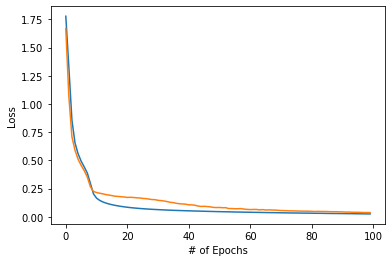

Training complete.
CPU Time:  1958.4989404678345 s
Epoch 1, Training Error: 1.778318218218807, Validation Error: 1.668036614791311
Epoch 2, Training Error: 1.323977015561336, Validation Error: 1.064557232369577
Epoch 3, Training Error: 0.855356185402815, Validation Error: 0.707581333759158
Epoch 4, Training Error: 0.654397419933673, Validation Error: 0.589211201454720
Epoch 5, Training Error: 0.558407559082110, Validation Error: 0.509491563955579
Epoch 6, Training Error: 0.492364777014988, Validation Error: 0.455357837061548
Epoch 7, Training Error: 0.441806871370577, Validation Error: 0.408586699600419
Epoch 8, Training Error: 0.387491194249267, Validation Error: 0.351708086531564
Epoch 9, Training Error: 0.295991025081222, Validation Error: 0.266367239966142
Epoch 10, Training Error: 0.203100530156503, Validation Error: 0.224315558653402
Epoch 11, Training Error: 0.164997094892985, Validation Error: 0.214625209614398
Epoch 12, Training Error: 0.145352972323713, Validation Error: 0.20

In [23]:
Case5.train(traindata,trainlabel,100)

Test Accuracy: 92.94%
Class 1: 10 misclassifications
Class 2: 36 misclassifications
Class 3: 39 misclassifications
Class 4: 80 misclassifications
Class 5: 16 misclassifications
Class 6: 27 misclassifications


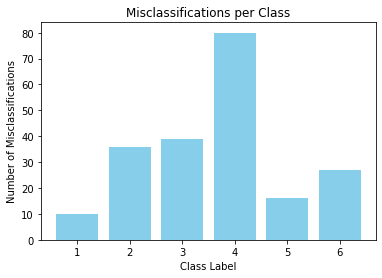

In [24]:
Case5.test_accuracy(testdata,testlabel)

Test Accuracy: 99.40%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 27 misclassifications
Class 5: 15 misclassifications
Class 6: 0 misclassifications


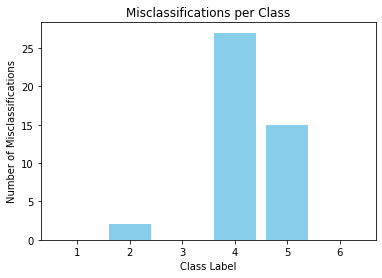

In [25]:
Case5.test_accuracy(traindata,trainlabel)

### Case 6

##### n= 0.001 N1= 300 N2= 200 momentum= 0 batch= 50

In [26]:
Case6= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.001,batch_size=50,momentum=0.0)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.87batch/s]

Epoch:  1
Train error: 1.791195615
Validation Error: 1.791722066



Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 197.51batch/s]

Epoch:  2
Train error: 1.791136231
Validation Error: 1.791661382



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.72batch/s]

Epoch:  3
Train error: 1.791077143
Validation Error: 1.791600866



Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.32batch/s]

Epoch:  4
Train error: 1.791018350
Validation Error: 1.791540647



Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  5
Train error: 1.790959719
Validation Error: 1.791480648



Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.64batch/s]

Epoch:  6
Train error: 1.790900665
Validation Error: 1.791419833



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.75batch/s]

Epoch:  7
Train error: 1.790840705
Validation Error: 1.791358048



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.08batch/s]

Epoch:  8
Train error: 1.790779794
Validation Error: 1.791295259



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.54batch/s]

Epoch:  9
Train error: 1.790717683
Validation Error: 1.791231084



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.35batch/s]

Epoch:  10
Train error: 1.790654047
Validation Error: 1.791165142



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.90batch/s]

Epoch:  11
Train error: 1.790588267
Validation Error: 1.791096745



Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.95batch/s]

Epoch:  12
Train error: 1.790519580
Validation Error: 1.791025207



Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.21batch/s]

Epoch:  13
Train error: 1.790447370
Validation Error: 1.790949892



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.60batch/s]

Epoch:  14
Train error: 1.790371004
Validation Error: 1.790870080



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.22batch/s]

Epoch:  15
Train error: 1.790289800
Validation Error: 1.790784978



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.24batch/s]

Epoch:  16
Train error: 1.790203047
Validation Error: 1.790693672



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  17
Train error: 1.790109885
Validation Error: 1.790595315



Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.23batch/s]

Epoch:  18
Train error: 1.790009170
Validation Error: 1.790488512



Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.23batch/s]

Epoch:  19
Train error: 1.789899425
Validation Error: 1.790371541



Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.21batch/s]

Epoch:  20
Train error: 1.789779035
Validation Error: 1.790242931



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.36batch/s]

Epoch:  21
Train error: 1.789646801
Validation Error: 1.790101610



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.20batch/s]

Epoch:  22
Train error: 1.789501437
Validation Error: 1.789945974



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.43batch/s]

Epoch:  23
Train error: 1.789341252
Validation Error: 1.789773947



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  24
Train error: 1.789163944
Validation Error: 1.789583129



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.36batch/s]

Epoch:  25
Train error: 1.788966921
Validation Error: 1.789370650



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.40batch/s]

Epoch:  26
Train error: 1.788747336
Validation Error: 1.789133414



Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 201.94batch/s]

Epoch:  27
Train error: 1.788501724
Validation Error: 1.788867547



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.44batch/s]

Epoch:  28
Train error: 1.788225763
Validation Error: 1.788568119



Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.12batch/s]

Epoch:  29
Train error: 1.787914195
Validation Error: 1.788229103



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.24batch/s]

Epoch:  30
Train error: 1.787560765
Validation Error: 1.787843517



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.35batch/s]

Epoch:  31
Train error: 1.787158061
Validation Error: 1.787402887



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 202.76batch/s]

Epoch:  32
Train error: 1.786697020
Validation Error: 1.786896826



Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.41batch/s]

Epoch:  33
Train error: 1.786166401
Validation Error: 1.786312555



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.28batch/s]

Epoch:  34
Train error: 1.785552304
Validation Error: 1.785634071



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.92batch/s]

Epoch:  35
Train error: 1.784837207
Validation Error: 1.784840954



Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 192.74batch/s]

Epoch:  36
Train error: 1.783999221
Validation Error: 1.783908381



Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.40batch/s]

Epoch:  37
Train error: 1.783012126
Validation Error: 1.782806530



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  38
Train error: 1.781842849
Validation Error: 1.781496430



Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.23batch/s]

Epoch:  39
Train error: 1.780448137
Validation Error: 1.779927246



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.41batch/s]

Epoch:  40
Train error: 1.778772199
Validation Error: 1.778034030



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.88batch/s]


Epoch:  41
Train error: 1.776743738
Validation Error: 1.775733435


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 170.63batch/s]

Epoch:  42
Train error: 1.774271554
Validation Error: 1.772919221



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.96batch/s]


Epoch:  43
Train error: 1.771239192
Validation Error: 1.769455493


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.26batch/s]

Epoch:  44
Train error: 1.767497881
Validation Error: 1.765169078



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.03batch/s]

Epoch:  45
Train error: 1.762860350
Validation Error: 1.759844654



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.62batch/s]

Epoch:  46
Train error: 1.757096967
Validation Error: 1.753221779



Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.36batch/s]

Epoch:  47
Train error: 1.749936605
Validation Error: 1.745001401



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.20batch/s]

Epoch:  48
Train error: 1.741079855
Validation Error: 1.734869059



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.12batch/s]

Epoch:  49
Train error: 1.730232499
Validation Error: 1.722542367



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.13batch/s]

Epoch:  50
Train error: 1.717161504
Validation Error: 1.707842593



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.35batch/s]

Epoch:  51
Train error: 1.701765327
Validation Error: 1.690762429



Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.65batch/s]

Epoch:  52
Train error: 1.684107955
Validation Error: 1.671471522



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 207.20batch/s]

Epoch:  53
Train error: 1.664393303
Validation Error: 1.650258866



Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 187.12batch/s]


Epoch:  54
Train error: 1.642948992
Validation Error: 1.627547657


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.91batch/s]

Epoch:  55
Train error: 1.620315202
Validation Error: 1.604102204



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.57batch/s]

Epoch:  56
Train error: 1.597330793
Validation Error: 1.580913275



Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.13batch/s]

Epoch:  57
Train error: 1.574950091
Validation Error: 1.558712429



Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.59batch/s]

Epoch:  58
Train error: 1.553990329
Validation Error: 1.538191994



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.26batch/s]

Epoch:  59
Train error: 1.534935740
Validation Error: 1.519640445



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.88batch/s]

Epoch:  60
Train error: 1.517827685
Validation Error: 1.502945994



Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.38batch/s]

Epoch:  61
Train error: 1.502490070
Validation Error: 1.488026151



Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  62
Train error: 1.488779334
Validation Error: 1.474615241



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.27batch/s]

Epoch:  63
Train error: 1.476447189
Validation Error: 1.462434194



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.25batch/s]

Epoch:  64
Train error: 1.465071793
Validation Error: 1.451062466



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.39batch/s]

Epoch:  65
Train error: 1.454181075
Validation Error: 1.440026831



Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.41batch/s]

Epoch:  66
Train error: 1.443278492
Validation Error: 1.428807077



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 187.90batch/s]

Epoch:  67
Train error: 1.431843709
Validation Error: 1.416836943



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.92batch/s]

Epoch:  68
Train error: 1.419256363
Validation Error: 1.403458712



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.40batch/s]

Epoch:  69
Train error: 1.404865282
Validation Error: 1.388014763



Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.24batch/s]

Epoch:  70
Train error: 1.387968860
Validation Error: 1.369838295



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.87batch/s]

Epoch:  71
Train error: 1.367972578
Validation Error: 1.348383466



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.28batch/s]

Epoch:  72
Train error: 1.344583622
Validation Error: 1.323575050



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  73
Train error: 1.318129615
Validation Error: 1.296119259



Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 202.38batch/s]

Epoch:  74
Train error: 1.289804509
Validation Error: 1.267620342



Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.41batch/s]

Epoch:  75
Train error: 1.261529086
Validation Error: 1.240182688



Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.20batch/s]

Epoch:  76
Train error: 1.235275140
Validation Error: 1.215604467



Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.23batch/s]

Epoch:  77
Train error: 1.212322100
Validation Error: 1.194775102



Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.12batch/s]

Epoch:  78
Train error: 1.193010433
Validation Error: 1.177653253



Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.30batch/s]

Epoch:  79
Train error: 1.177008828
Validation Error: 1.163717602



Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.38batch/s]

Epoch:  80
Train error: 1.163739797
Validation Error: 1.152319217



Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.74batch/s]

Epoch:  81
Train error: 1.152611380
Validation Error: 1.142837675



Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.03batch/s]

Epoch:  82
Train error: 1.143120163
Validation Error: 1.134774381



Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.32batch/s]


Epoch:  83
Train error: 1.134865277
Validation Error: 1.127736571


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 188.13batch/s]

Epoch:  84
Train error: 1.127528074
Validation Error: 1.121428895



Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.36batch/s]

Epoch:  85
Train error: 1.120854222
Validation Error: 1.115629308



Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.00batch/s]

Epoch:  86
Train error: 1.114643532
Validation Error: 1.110163664



Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.23batch/s]

Epoch:  87
Train error: 1.108730378
Validation Error: 1.104895734



Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.75batch/s]

Epoch:  88
Train error: 1.102983408
Validation Error: 1.099715973



Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.53batch/s]

Epoch:  89
Train error: 1.097291224
Validation Error: 1.094529502



Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 184.20batch/s]

Epoch:  90
Train error: 1.091556294
Validation Error: 1.089252018



Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.33batch/s]

Epoch:  91
Train error: 1.085696399
Validation Error: 1.083815797



Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.19batch/s]

Epoch:  92
Train error: 1.079638905
Validation Error: 1.078146421



Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.26batch/s]

Epoch:  93
Train error: 1.073315674
Validation Error: 1.072183039



Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.04batch/s]

Epoch:  94
Train error: 1.066667084
Validation Error: 1.065866030



Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.35batch/s]

Epoch:  95
Train error: 1.059636177
Validation Error: 1.059138300



Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.50batch/s]

Epoch:  96
Train error: 1.052172394
Validation Error: 1.051948702



Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.62batch/s]

Epoch:  97
Train error: 1.044230959
Validation Error: 1.044251208



Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.75batch/s]

Epoch:  98
Train error: 1.035779447
Validation Error: 1.036010060



Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.19batch/s]

Epoch:  99
Train error: 1.026795095
Validation Error: 1.027194744



Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 166.62batch/s]

Epoch:  100
Train error: 1.017258911
Validation Error: 1.017792666


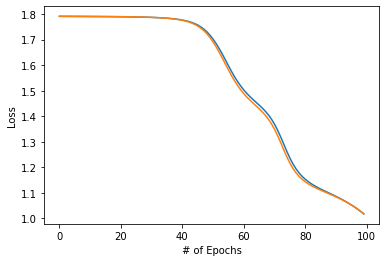

Training complete.
CPU Time:  71.49001002311707 s
Epoch 1, Training Error: 1.791195614807173, Validation Error: 1.791722066087059
Epoch 2, Training Error: 1.791136230876124, Validation Error: 1.791661382107400
Epoch 3, Training Error: 1.791077142582785, Validation Error: 1.791600865718072
Epoch 4, Training Error: 1.791018350317913, Validation Error: 1.791540646696055
Epoch 5, Training Error: 1.790959718692696, Validation Error: 1.791480647666266
Epoch 6, Training Error: 1.790900664719740, Validation Error: 1.791419832782269
Epoch 7, Training Error: 1.790840705157086, Validation Error: 1.791358048058948
Epoch 8, Training Error: 1.790779794008683, Validation Error: 1.791295258644166
Epoch 9, Training Error: 1.790717683358525, Validation Error: 1.791231083509157
Epoch 10, Training Error: 1.790654047248792, Validation Error: 1.791165142164555
Epoch 11, Training Error: 1.790588267262953, Validation Error: 1.791096745118117
Epoch 12, Training Error: 1.790519580233028, Validation Error: 1.791

In [27]:
Case6.train(traindata,trainlabel,100)

Test Accuracy: 52.90%
Class 1: 4 misclassifications
Class 2: 398 misclassifications
Class 3: 403 misclassifications
Class 4: 491 misclassifications
Class 5: 11 misclassifications
Class 6: 59 misclassifications


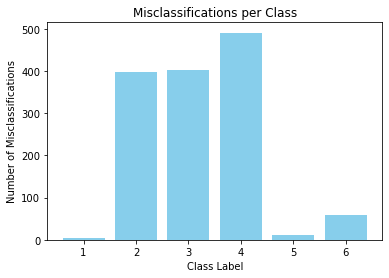

In [28]:
Case6.test_accuracy(testdata,testlabel)

Test Accuracy: 49.69%
Class 1: 32 misclassifications
Class 2: 1073 misclassifications
Class 3: 1042 misclassifications
Class 4: 1217 misclassifications
Class 5: 161 misclassifications
Class 6: 173 misclassifications


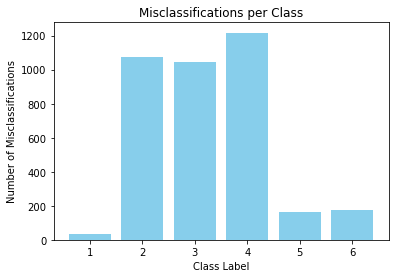

In [29]:
Case6.test_accuracy(traindata,trainlabel)

### Case 7

##### n= 0.001 N1= 300 N2= 200 momentum= 0.9 batch= 0

In [30]:
Case7= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.001,batch_size=1,momentum=0.9)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 314.02batch/s]


Epoch:  1
Train error: 1.591492974
Validation Error: 1.119652283


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 318.81batch/s]


Epoch:  2
Train error: 0.841843669
Validation Error: 0.657971185


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 313.79batch/s]


Epoch:  3
Train error: 0.592378466
Validation Error: 0.511316336


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 313.09batch/s]


Epoch:  4
Train error: 0.478707361
Validation Error: 0.408751810


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 317.83batch/s]


Epoch:  5
Train error: 0.359763122
Validation Error: 0.294373270


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 316.64batch/s]


Epoch:  6
Train error: 0.221486864
Validation Error: 0.232310113


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 310.09batch/s]


Epoch:  7
Train error: 0.169352430
Validation Error: 0.229013331


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 317.09batch/s]


Epoch:  8
Train error: 0.144826630
Validation Error: 0.225896016


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 310.77batch/s]


Epoch:  9
Train error: 0.129167026
Validation Error: 0.223163091


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 313.33batch/s]


Epoch:  10
Train error: 0.117955182
Validation Error: 0.216177183


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.95batch/s]


Epoch:  11
Train error: 0.109088590
Validation Error: 0.208174532


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.63batch/s]


Epoch:  12
Train error: 0.100863208
Validation Error: 0.205582287


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.80batch/s]


Epoch:  13
Train error: 0.094568625
Validation Error: 0.196942507


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.90batch/s]


Epoch:  14
Train error: 0.089591406
Validation Error: 0.193070034


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.20batch/s]


Epoch:  15
Train error: 0.085327814
Validation Error: 0.192331888


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.02batch/s]


Epoch:  16
Train error: 0.081493368
Validation Error: 0.187176539


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.70batch/s]


Epoch:  17
Train error: 0.078014186
Validation Error: 0.182164289


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 347.40batch/s]


Epoch:  18
Train error: 0.075144764
Validation Error: 0.181944030


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.69batch/s]


Epoch:  19
Train error: 0.072646508
Validation Error: 0.178348665


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.95batch/s]


Epoch:  20
Train error: 0.070175066
Validation Error: 0.159436864


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.99batch/s]


Epoch:  21
Train error: 0.067952334
Validation Error: 0.163028881


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.31batch/s]


Epoch:  22
Train error: 0.065658834
Validation Error: 0.157799255


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.68batch/s]


Epoch:  23
Train error: 0.063971718
Validation Error: 0.152115780


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.71batch/s]


Epoch:  24
Train error: 0.061821183
Validation Error: 0.147201153


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.94batch/s]


Epoch:  25
Train error: 0.060778981
Validation Error: 0.139273595


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.78batch/s]


Epoch:  26
Train error: 0.059085719
Validation Error: 0.131249864


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.47batch/s]


Epoch:  27
Train error: 0.057798630
Validation Error: 0.128881086


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.80batch/s]


Epoch:  28
Train error: 0.056478523
Validation Error: 0.118762102


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.95batch/s]


Epoch:  29
Train error: 0.054994258
Validation Error: 0.119664480


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.67batch/s]


Epoch:  30
Train error: 0.053828322
Validation Error: 0.110957250


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.55batch/s]


Epoch:  31
Train error: 0.052423098
Validation Error: 0.117675133


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.87batch/s]


Epoch:  32
Train error: 0.051712777
Validation Error: 0.112940668


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.98batch/s]


Epoch:  33
Train error: 0.050650779
Validation Error: 0.098587616


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.21batch/s]


Epoch:  34
Train error: 0.049192741
Validation Error: 0.095627631


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.61batch/s]


Epoch:  35
Train error: 0.048061763
Validation Error: 0.100589240


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.72batch/s]


Epoch:  36
Train error: 0.047355757
Validation Error: 0.093160433


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.27batch/s]


Epoch:  37
Train error: 0.046174470
Validation Error: 0.095018083


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.02batch/s]


Epoch:  38
Train error: 0.045519999
Validation Error: 0.089981050


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.66batch/s]


Epoch:  39
Train error: 0.044874712
Validation Error: 0.079672950


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.62batch/s]


Epoch:  40
Train error: 0.043701993
Validation Error: 0.073845890


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.66batch/s]


Epoch:  41
Train error: 0.043043204
Validation Error: 0.077829531


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 329.19batch/s]


Epoch:  42
Train error: 0.041405383
Validation Error: 0.068053326


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.66batch/s]


Epoch:  43
Train error: 0.041255632
Validation Error: 0.067512180


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.19batch/s]


Epoch:  44
Train error: 0.040409944
Validation Error: 0.068343440


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.77batch/s]


Epoch:  45
Train error: 0.039764575
Validation Error: 0.065643301


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.07batch/s]


Epoch:  46
Train error: 0.039039951
Validation Error: 0.057994814


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.30batch/s]


Epoch:  47
Train error: 0.037976407
Validation Error: 0.055538142


Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.23batch/s]


Epoch:  48
Train error: 0.037682351
Validation Error: 0.056177377


Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.31batch/s]


Epoch:  49
Train error: 0.036491838
Validation Error: 0.052759102


Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.66batch/s]


Epoch:  50
Train error: 0.036465392
Validation Error: 0.063450616


Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.43batch/s]


Epoch:  51
Train error: 0.035506916
Validation Error: 0.049520491


Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.14batch/s]


Epoch:  52
Train error: 0.034334018
Validation Error: 0.049068620


Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.83batch/s]


Epoch:  53
Train error: 0.034198713
Validation Error: 0.047864425


Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.21batch/s]


Epoch:  54
Train error: 0.033877261
Validation Error: 0.047528025


Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.15batch/s]


Epoch:  55
Train error: 0.033133214
Validation Error: 0.045624533


Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.69batch/s]


Epoch:  56
Train error: 0.032098976
Validation Error: 0.043426388


Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.10batch/s]


Epoch:  57
Train error: 0.031617776
Validation Error: 0.048532686


Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.36batch/s]


Epoch:  58
Train error: 0.031697329
Validation Error: 0.042232314


Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.90batch/s]


Epoch:  59
Train error: 0.029305722
Validation Error: 0.040492702


Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.13batch/s]


Epoch:  60
Train error: 0.029235059
Validation Error: 0.040538039


Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.11batch/s]


Epoch:  61
Train error: 0.027591007
Validation Error: 0.040511812


Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.32batch/s]


Epoch:  62
Train error: 0.027021305
Validation Error: 0.041651278


Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.26batch/s]


Epoch:  63
Train error: 0.028498075
Validation Error: 0.040043302


Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.38batch/s]


Epoch:  64
Train error: 0.026008010
Validation Error: 0.037713163


Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.84batch/s]


Epoch:  65
Train error: 0.024969041
Validation Error: 0.036529261


Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.56batch/s]


Epoch:  66
Train error: 0.025159128
Validation Error: 0.041887706


Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.24batch/s]


Epoch:  67
Train error: 0.025246610
Validation Error: 0.043323505


Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.29batch/s]


Epoch:  68
Train error: 0.023012288
Validation Error: 0.036886730


Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.37batch/s]


Epoch:  69
Train error: 0.024245622
Validation Error: 0.035698340


Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.21batch/s]


Epoch:  70
Train error: 0.023466767
Validation Error: 0.033733890


Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.18batch/s]


Epoch:  71
Train error: 0.024340303
Validation Error: 0.035446733


Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.67batch/s]


Epoch:  72
Train error: 0.022955979
Validation Error: 0.034460528


Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.82batch/s]


Epoch:  73
Train error: 0.021555732
Validation Error: 0.035920696


Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.32batch/s]


Epoch:  74
Train error: 0.022507595
Validation Error: 0.030463273


Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.39batch/s]


Epoch:  75
Train error: 0.021614488
Validation Error: 0.030961378


Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.35batch/s]


Epoch:  76
Train error: 0.018660562
Validation Error: 0.034038011


Epoch 77/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 347.90batch/s]


Epoch:  77
Train error: 0.021106310
Validation Error: 0.029817676


Epoch 78/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 327.25batch/s]


Epoch:  78
Train error: 0.021972110
Validation Error: 0.029166264


Epoch 79/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.65batch/s]


Epoch:  79
Train error: 0.018200896
Validation Error: 0.032056821


Epoch 80/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.02batch/s]


Epoch:  80
Train error: 0.019497047
Validation Error: 0.033501051


Epoch 81/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 329.53batch/s]


Epoch:  81
Train error: 0.017512575
Validation Error: 0.029310612


Epoch 82/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.34batch/s]


Epoch:  82
Train error: 0.018171845
Validation Error: 0.030997414


Epoch 83/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.31batch/s]


Epoch:  83
Train error: 0.018336796
Validation Error: 0.034895840


Epoch 84/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.39batch/s]


Epoch:  84
Train error: 0.017143382
Validation Error: 0.027352017


Epoch 85/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.33batch/s]


Epoch:  85
Train error: 0.022664441
Validation Error: 0.028922133


Epoch 86/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.78batch/s]


Epoch:  86
Train error: 0.016396921
Validation Error: 0.035856554


Epoch 87/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.93batch/s]


Epoch:  87
Train error: 0.017222776
Validation Error: 0.024320743


Epoch 88/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.65batch/s]


Epoch:  88
Train error: 0.016402067
Validation Error: 0.024468759


Epoch 89/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.83batch/s]


Epoch:  89
Train error: 0.018014858
Validation Error: 0.027272196


Epoch 90/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.45batch/s]


Epoch:  90
Train error: 0.015606841
Validation Error: 0.024483579


Epoch 91/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 326.43batch/s]


Epoch:  91
Train error: 0.016313425
Validation Error: 0.026695729


Epoch 92/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.22batch/s]


Epoch:  92
Train error: 0.015712463
Validation Error: 0.025848469


Epoch 93/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.39batch/s]


Epoch:  93
Train error: 0.017991409
Validation Error: 0.033945720


Epoch 94/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.51batch/s]


Epoch:  94
Train error: 0.014318399
Validation Error: 0.021705740


Epoch 95/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.15batch/s]


Epoch:  95
Train error: 0.013945610
Validation Error: 0.032385163


Epoch 96/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.56batch/s]


Epoch:  96
Train error: 0.012740442
Validation Error: 0.026011034


Epoch 97/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 347.51batch/s]


Epoch:  97
Train error: 0.014330182
Validation Error: 0.031987135


Epoch 98/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.21batch/s]


Epoch:  98
Train error: 0.015327602
Validation Error: 0.026704762


Epoch 99/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.44batch/s]


Epoch:  99
Train error: 0.014868270
Validation Error: 0.025134555


Epoch 100/100: 100%|███████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.35batch/s]


Epoch:  100
Train error: 0.012829083
Validation Error: 0.022510311


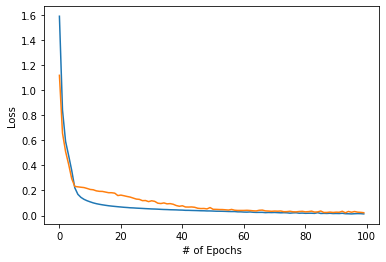

Training complete.
CPU Time:  1976.4955523014069 s
Epoch 1, Training Error: 1.591492973595327, Validation Error: 1.119652282542492
Epoch 2, Training Error: 0.841843668678790, Validation Error: 0.657971184888338
Epoch 3, Training Error: 0.592378466084312, Validation Error: 0.511316335752095
Epoch 4, Training Error: 0.478707361171393, Validation Error: 0.408751810085549
Epoch 5, Training Error: 0.359763121507957, Validation Error: 0.294373270004324
Epoch 6, Training Error: 0.221486863696506, Validation Error: 0.232310113124044
Epoch 7, Training Error: 0.169352429968764, Validation Error: 0.229013330763705
Epoch 8, Training Error: 0.144826630312961, Validation Error: 0.225896016371570
Epoch 9, Training Error: 0.129167025997731, Validation Error: 0.223163091086480
Epoch 10, Training Error: 0.117955181973466, Validation Error: 0.216177183199018
Epoch 11, Training Error: 0.109088590447000, Validation Error: 0.208174531548482
Epoch 12, Training Error: 0.100863208288128, Validation Error: 0.20

In [31]:
Case7.train(traindata,trainlabel,100)

Test Accuracy: 93.52%
Class 1: 6 misclassifications
Class 2: 36 misclassifications
Class 3: 38 misclassifications
Class 4: 66 misclassifications
Class 5: 18 misclassifications
Class 6: 27 misclassifications


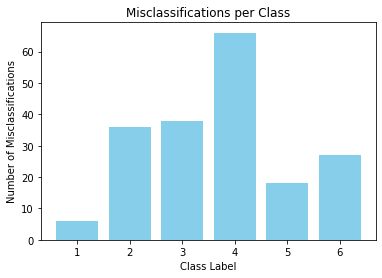

In [32]:
Case7.test_accuracy(testdata,testlabel)

Test Accuracy: 99.70%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 10 misclassifications
Class 5: 10 misclassifications
Class 6: 0 misclassifications


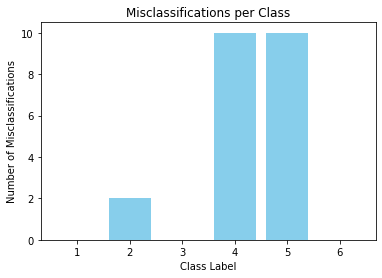

In [33]:
Case7.test_accuracy(traindata,trainlabel)

### Case 8

##### n= 0.001 N1= 300 N2= 200 momentum= 0.9 batch= 50

In [34]:
Case8= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.001,batch_size=50,momentum=0.9)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.34batch/s]

Epoch:  1
Train error: 1.791207165
Validation Error: 1.791721099



Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  2
Train error: 1.791131757
Validation Error: 1.791642838



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.43batch/s]

Epoch:  3
Train error: 1.791054936
Validation Error: 1.791561965



Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.61batch/s]

Epoch:  4
Train error: 1.790974520
Validation Error: 1.791475955



Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.19batch/s]

Epoch:  5
Train error: 1.790888334
Validation Error: 1.791383394



Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.95batch/s]

Epoch:  6
Train error: 1.790795616
Validation Error: 1.791283926



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 161.88batch/s]

Epoch:  7
Train error: 1.790695264
Validation Error: 1.791175243



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.95batch/s]

Epoch:  8
Train error: 1.790584266
Validation Error: 1.791053801



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.94batch/s]

Epoch:  9
Train error: 1.790459084
Validation Error: 1.790915709



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 203.65batch/s]

Epoch:  10
Train error: 1.790315582
Validation Error: 1.790756430



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.03batch/s]

Epoch:  11
Train error: 1.790148997
Validation Error: 1.790571521



Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.77batch/s]


Epoch:  12
Train error: 1.789954396
Validation Error: 1.790354151


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 201.17batch/s]

Epoch:  13
Train error: 1.789723997
Validation Error: 1.790094720



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.93batch/s]

Epoch:  14
Train error: 1.789447326
Validation Error: 1.789781121



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.24batch/s]

Epoch:  15
Train error: 1.789111243
Validation Error: 1.789397745



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.40batch/s]

Epoch:  16
Train error: 1.788697920
Validation Error: 1.788922585



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.29batch/s]

Epoch:  17
Train error: 1.788182148
Validation Error: 1.788324817



Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.93batch/s]

Epoch:  18
Train error: 1.787528526
Validation Error: 1.787560798



Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.22batch/s]

Epoch:  19
Train error: 1.786685802
Validation Error: 1.786566300



Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  20
Train error: 1.785578189
Validation Error: 1.785245819



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.67batch/s]

Epoch:  21
Train error: 1.784091551
Validation Error: 1.783453877



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.23batch/s]

Epoch:  22
Train error: 1.782050762
Validation Error: 1.780965578



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.28batch/s]

Epoch:  23
Train error: 1.779181932
Validation Error: 1.777426039



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.36batch/s]

Epoch:  24
Train error: 1.775050270
Validation Error: 1.772269110



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.14batch/s]

Epoch:  25
Train error: 1.768960681
Validation Error: 1.764589744



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.26batch/s]

Epoch:  26
Train error: 1.759815118
Validation Error: 1.752986550



Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.55batch/s]

Epoch:  27
Train error: 1.745997740
Validation Error: 1.735528945



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.41batch/s]

Epoch:  28
Train error: 1.725550882
Validation Error: 1.710264204



Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 201.64batch/s]

Epoch:  29
Train error: 1.697059388
Validation Error: 1.676567883



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.27batch/s]

Epoch:  30
Train error: 1.660843203
Validation Error: 1.635942551



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.20batch/s]

Epoch:  31
Train error: 1.619169447
Validation Error: 1.592165282



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 187.12batch/s]

Epoch:  32
Train error: 1.576950663
Validation Error: 1.551068071



Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.34batch/s]

Epoch:  33
Train error: 1.539805182
Validation Error: 1.516643505



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.23batch/s]

Epoch:  34
Train error: 1.509814335
Validation Error: 1.489212426



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.28batch/s]

Epoch:  35
Train error: 1.486206180
Validation Error: 1.467655761



Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.22batch/s]

Epoch:  36
Train error: 1.467415863
Validation Error: 1.449883606



Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.42batch/s]

Epoch:  37
Train error: 1.450908802
Validation Error: 1.433364931



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.23batch/s]

Epoch:  38
Train error: 1.434053463
Validation Error: 1.415319910



Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.38batch/s]

Epoch:  39
Train error: 1.413770917
Validation Error: 1.392299015



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.43batch/s]

Epoch:  40
Train error: 1.386213778
Validation Error: 1.360023833



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  41
Train error: 1.347429453
Validation Error: 1.315327469



Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  42
Train error: 1.297350733
Validation Error: 1.262116527



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.53batch/s]

Epoch:  43
Train error: 1.244878136
Validation Error: 1.213108064



Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.39batch/s]

Epoch:  44
Train error: 1.201761675
Validation Error: 1.177117058



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.73batch/s]

Epoch:  45
Train error: 1.171060207
Validation Error: 1.152839999



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.24batch/s]

Epoch:  46
Train error: 1.149440776
Validation Error: 1.135903290



Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.07batch/s]

Epoch:  47
Train error: 1.133368377
Validation Error: 1.123037181



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.32batch/s]

Epoch:  48
Train error: 1.120449030
Validation Error: 1.112283345



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.93batch/s]

Epoch:  49
Train error: 1.109162189
Validation Error: 1.102469764



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.44batch/s]

Epoch:  50
Train error: 1.098496503
Validation Error: 1.092829037



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.17batch/s]

Epoch:  51
Train error: 1.087732855
Validation Error: 1.082782836



Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.95batch/s]

Epoch:  52
Train error: 1.076317225
Validation Error: 1.071850006



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 197.81batch/s]

Epoch:  53
Train error: 1.063799462
Validation Error: 1.059601261



Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.94batch/s]

Epoch:  54
Train error: 1.049800944
Validation Error: 1.045669110



Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.79batch/s]

Epoch:  55
Train error: 1.034020587
Validation Error: 1.029766388



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.94batch/s]

Epoch:  56
Train error: 1.016281645
Validation Error: 1.011715653



Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.65batch/s]

Epoch:  57
Train error: 0.996553602
Validation Error: 0.991526170



Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  58
Train error: 0.975005950
Validation Error: 0.969391551



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.32batch/s]

Epoch:  59
Train error: 0.951992682
Validation Error: 0.945730789



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.86batch/s]


Epoch:  60
Train error: 0.928089714
Validation Error: 0.921143425


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 165.03batch/s]

Epoch:  61
Train error: 0.903984318
Validation Error: 0.896415709



Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.24batch/s]

Epoch:  62
Train error: 0.880376913
Validation Error: 0.872242015



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 203.48batch/s]

Epoch:  63
Train error: 0.857846252
Validation Error: 0.849230716



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.25batch/s]

Epoch:  64
Train error: 0.836827995
Validation Error: 0.827779877



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.43batch/s]

Epoch:  65
Train error: 0.817562462
Validation Error: 0.808141090



Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.93batch/s]

Epoch:  66
Train error: 0.800124553
Validation Error: 0.790383342



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.65batch/s]

Epoch:  67
Train error: 0.784430310
Validation Error: 0.774371971



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.35batch/s]

Epoch:  68
Train error: 0.770312817
Validation Error: 0.760011730



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.93batch/s]


Epoch:  69
Train error: 0.757607986
Validation Error: 0.747095620


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.88batch/s]


Epoch:  70
Train error: 0.746122040
Validation Error: 0.735454697


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.24batch/s]

Epoch:  71
Train error: 0.735675021
Validation Error: 0.724921862



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.24batch/s]

Epoch:  72
Train error: 0.726112102
Validation Error: 0.715341035



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 204.93batch/s]

Epoch:  73
Train error: 0.717296687
Validation Error: 0.706564554



Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.11batch/s]

Epoch:  74
Train error: 0.709117613
Validation Error: 0.698463734



Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 196.51batch/s]

Epoch:  75
Train error: 0.701473927
Validation Error: 0.690936010



Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.68batch/s]

Epoch:  76
Train error: 0.694279207
Validation Error: 0.683891305



Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.11batch/s]

Epoch:  77
Train error: 0.687471357
Validation Error: 0.677258983



Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.35batch/s]

Epoch:  78
Train error: 0.680991205
Validation Error: 0.670977473



Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.40batch/s]

Epoch:  79
Train error: 0.674790945
Validation Error: 0.664998291



Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 201.94batch/s]

Epoch:  80
Train error: 0.668832115
Validation Error: 0.659263159



Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  81
Train error: 0.663082257
Validation Error: 0.653747967



Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.21batch/s]

Epoch:  82
Train error: 0.657516978
Validation Error: 0.648414106



Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.20batch/s]

Epoch:  83
Train error: 0.652112000
Validation Error: 0.643241644



Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.41batch/s]

Epoch:  84
Train error: 0.646851730
Validation Error: 0.638218968



Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.22batch/s]

Epoch:  85
Train error: 0.641723311
Validation Error: 0.633329969



Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.25batch/s]

Epoch:  86
Train error: 0.636711578
Validation Error: 0.628557670



Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.23batch/s]

Epoch:  87
Train error: 0.631808477
Validation Error: 0.623898451



Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 198.58batch/s]

Epoch:  88
Train error: 0.627002800
Validation Error: 0.619332753



Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.35batch/s]

Epoch:  89
Train error: 0.622284820
Validation Error: 0.614858153



Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.26batch/s]

Epoch:  90
Train error: 0.617649773
Validation Error: 0.610472047



Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  91
Train error: 0.613091296
Validation Error: 0.606157445



Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.09batch/s]

Epoch:  92
Train error: 0.608602632
Validation Error: 0.601910688



Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 202.23batch/s]

Epoch:  93
Train error: 0.604177689
Validation Error: 0.597724914



Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.33batch/s]

Epoch:  94
Train error: 0.599811513
Validation Error: 0.593596449



Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.89batch/s]


Epoch:  95
Train error: 0.595502133
Validation Error: 0.589520209


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 207.20batch/s]

Epoch:  96
Train error: 0.591245911
Validation Error: 0.585493568



Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.13batch/s]

Epoch:  97
Train error: 0.587040472
Validation Error: 0.581515425



Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 187.11batch/s]

Epoch:  98
Train error: 0.582884131
Validation Error: 0.577580669



Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.06batch/s]

Epoch:  99
Train error: 0.578774178
Validation Error: 0.573687655



Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.26batch/s]

Epoch:  100
Train error: 0.574707610
Validation Error: 0.569834155


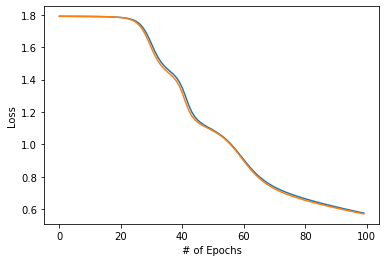

Training complete.
CPU Time:  71.76917147636414 s
Epoch 1, Training Error: 1.791207165024053, Validation Error: 1.791721098561623
Epoch 2, Training Error: 1.791131756914096, Validation Error: 1.791642838279951
Epoch 3, Training Error: 1.791054936211393, Validation Error: 1.791561965113953
Epoch 4, Training Error: 1.790974519580216, Validation Error: 1.791475955053661
Epoch 5, Training Error: 1.790888334205291, Validation Error: 1.791383394322538
Epoch 6, Training Error: 1.790795616112680, Validation Error: 1.791283926231392
Epoch 7, Training Error: 1.790695263745248, Validation Error: 1.791175243166371
Epoch 8, Training Error: 1.790584265835835, Validation Error: 1.791053800760385
Epoch 9, Training Error: 1.790459084270951, Validation Error: 1.790915709371744
Epoch 10, Training Error: 1.790315582228572, Validation Error: 1.790756430333519
Epoch 11, Training Error: 1.790148997142871, Validation Error: 1.790571520823612
Epoch 12, Training Error: 1.789954395556385, Validation Error: 1.790

In [35]:
Case8.train(traindata,trainlabel,100)

Test Accuracy: 72.79%
Class 1: 229 misclassifications
Class 2: 161 misclassifications
Class 3: 145 misclassifications
Class 4: 181 misclassifications
Class 5: 53 misclassifications
Class 6: 20 misclassifications


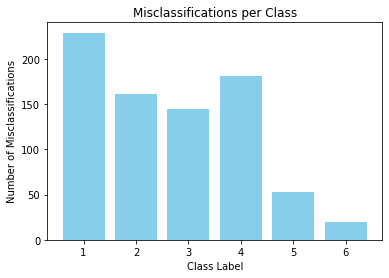

In [36]:
Case8.test_accuracy(testdata,testlabel)

Test Accuracy: 76.54%
Class 1: 451 misclassifications
Class 2: 520 misclassifications
Class 3: 159 misclassifications
Class 4: 453 misclassifications
Class 5: 137 misclassifications
Class 6: 4 misclassifications


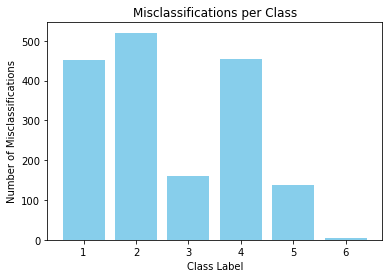

In [37]:
Case8.test_accuracy(traindata,trainlabel)

### Case 9

##### n= 0.01 N1= 300 N2= 100 momentum= 0 batch= 0

In [38]:
Case9= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.01,batch_size=1,momentum=0.0)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.93batch/s]


Epoch:  1
Train error: 0.975621185
Validation Error: 0.561769703


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.59batch/s]


Epoch:  2
Train error: 0.346920694
Validation Error: 0.398097155


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 374.42batch/s]


Epoch:  3
Train error: 0.213755640
Validation Error: 0.211801303


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.95batch/s]


Epoch:  4
Train error: 0.166420357
Validation Error: 0.186261399


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.27batch/s]


Epoch:  5
Train error: 0.136644990
Validation Error: 0.217348708


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.79batch/s]


Epoch:  6
Train error: 0.120058877
Validation Error: 0.216948342


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.24batch/s]


Epoch:  7
Train error: 0.115158157
Validation Error: 0.274729481


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 373.44batch/s]


Epoch:  8
Train error: 0.104250347
Validation Error: 0.175092555


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.63batch/s]


Epoch:  9
Train error: 0.088820177
Validation Error: 0.276797767


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.60batch/s]


Epoch:  10
Train error: 0.087914281
Validation Error: 0.175056122


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.79batch/s]


Epoch:  11
Train error: 0.077795665
Validation Error: 0.160386779


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.89batch/s]


Epoch:  12
Train error: 0.074140894
Validation Error: 0.284696116


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.21batch/s]


Epoch:  13
Train error: 0.083535760
Validation Error: 0.248161755


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.91batch/s]


Epoch:  14
Train error: 0.069642534
Validation Error: 0.221487125


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.07batch/s]


Epoch:  15
Train error: 0.070037421
Validation Error: 0.129663973


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.38batch/s]


Epoch:  16
Train error: 0.064793918
Validation Error: 0.089962542


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.16batch/s]


Epoch:  17
Train error: 0.063619232
Validation Error: 0.340992581


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.40batch/s]


Epoch:  18
Train error: 0.067132416
Validation Error: 0.354268495


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.72batch/s]


Epoch:  19
Train error: 0.059289237
Validation Error: 0.075853838


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.08batch/s]


Epoch:  20
Train error: 0.069446299
Validation Error: 0.315368793


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.88batch/s]


Epoch:  21
Train error: 0.058217852
Validation Error: 0.142925431


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.60batch/s]


Epoch:  22
Train error: 0.060186507
Validation Error: 0.064438196


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.63batch/s]


Epoch:  23
Train error: 0.058189142
Validation Error: 0.076354198


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 352.09batch/s]


Epoch:  24
Train error: 0.065658343
Validation Error: 0.363749371


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 373.71batch/s]


Epoch:  25
Train error: 0.064282228
Validation Error: 0.066856533


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.33batch/s]


Epoch:  26
Train error: 0.054884371
Validation Error: 0.109296044


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.55batch/s]


Epoch:  27
Train error: 0.051708506
Validation Error: 0.082178005


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.58batch/s]


Epoch:  28
Train error: 0.046507581
Validation Error: 0.065165875


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.21batch/s]


Epoch:  29
Train error: 0.050144228
Validation Error: 0.078317021


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.54batch/s]


Epoch:  30
Train error: 0.044028274
Validation Error: 0.179478960


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.66batch/s]


Epoch:  31
Train error: 0.043493880
Validation Error: 0.055410670


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.56batch/s]


Epoch:  32
Train error: 0.054768633
Validation Error: 0.058481194


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.87batch/s]


Epoch:  33
Train error: 0.044405789
Validation Error: 0.062034862


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.37batch/s]


Epoch:  34
Train error: 0.047522970
Validation Error: 0.090315829


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.10batch/s]


Epoch:  35
Train error: 0.047628488
Validation Error: 0.061272972


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.12batch/s]


Epoch:  36
Train error: 0.053505869
Validation Error: 0.079076275


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.46batch/s]


Epoch:  37
Train error: 0.049795255
Validation Error: 0.071116541


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.99batch/s]


Epoch:  38
Train error: 0.041548654
Validation Error: 0.076946825


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.34batch/s]


Epoch:  39
Train error: 0.044393301
Validation Error: 0.068073804


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.92batch/s]


Epoch:  40
Train error: 0.040923898
Validation Error: 0.070318847


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.20batch/s]


Training Stopped


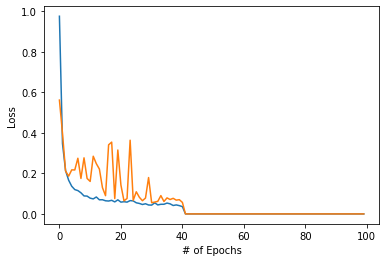

Training complete.
CPU Time:  744.301675081253 s
Epoch 1, Training Error: 0.975621184710913, Validation Error: 0.561769703078053
Epoch 2, Training Error: 0.346920694428366, Validation Error: 0.398097154640926
Epoch 3, Training Error: 0.213755640366592, Validation Error: 0.211801303248482
Epoch 4, Training Error: 0.166420356768963, Validation Error: 0.186261398901273
Epoch 5, Training Error: 0.136644989996698, Validation Error: 0.217348708279595
Epoch 6, Training Error: 0.120058877498796, Validation Error: 0.216948342201796
Epoch 7, Training Error: 0.115158157499870, Validation Error: 0.274729480598116
Epoch 8, Training Error: 0.104250347121195, Validation Error: 0.175092554964385
Epoch 9, Training Error: 0.088820176925575, Validation Error: 0.276797766567826
Epoch 10, Training Error: 0.087914281410578, Validation Error: 0.175056122232533
Epoch 11, Training Error: 0.077795664696084, Validation Error: 0.160386778775997
Epoch 12, Training Error: 0.074140893703592, Validation Error: 0.2846

In [39]:
Case9.train(traindata,trainlabel,100)

Test Accuracy: 93.76%
Class 1: 6 misclassifications
Class 2: 38 misclassifications
Class 3: 40 misclassifications
Class 4: 64 misclassifications
Class 5: 24 misclassifications
Class 6: 12 misclassifications


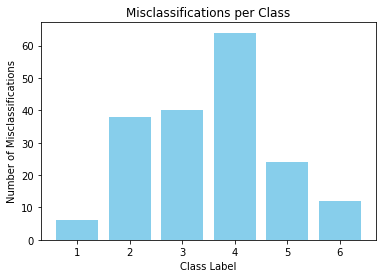

In [40]:
Case9.test_accuracy(testdata,testlabel)

Test Accuracy: 99.25%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 18 misclassifications
Class 5: 35 misclassifications
Class 6: 0 misclassifications


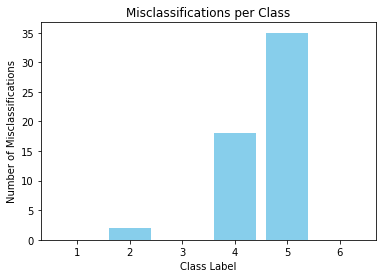

In [41]:
Case9.test_accuracy(traindata,trainlabel)

### Case 10

##### n= 0.01 N1= 300 N2= 100 momentum= 0 batch= 50

In [42]:
Case10= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.01,batch_size=50,momentum=0.0)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.09batch/s]


Epoch:  1
Train error: 1.791063084
Validation Error: 1.791484150


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.29batch/s]

Epoch:  2
Train error: 1.790801542
Validation Error: 1.791143458



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]

Epoch:  3
Train error: 1.790325785
Validation Error: 1.790431779



Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.79batch/s]


Epoch:  4
Train error: 1.789175482
Validation Error: 1.788501721


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.92batch/s]

Epoch:  5
Train error: 1.785397486
Validation Error: 1.781009723



Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.53batch/s]

Epoch:  6
Train error: 1.764483287
Validation Error: 1.729530861



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.14batch/s]

Epoch:  7
Train error: 1.640488802
Validation Error: 1.529879935



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.05batch/s]

Epoch:  8
Train error: 1.480465212
Validation Error: 1.428389370



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.78batch/s]


Epoch:  9
Train error: 1.372219830
Validation Error: 1.252003120


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.71batch/s]


Epoch:  10
Train error: 1.174777185
Validation Error: 1.118922548


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.70batch/s]


Epoch:  11
Train error: 1.096810274
Validation Error: 1.067751341


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.79batch/s]


Epoch:  12
Train error: 1.027150379
Validation Error: 0.980359642


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.27batch/s]

Epoch:  13
Train error: 0.919626484
Validation Error: 0.860481066



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.27batch/s]

Epoch:  14
Train error: 0.818017813
Validation Error: 0.772720113



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.50batch/s]

Epoch:  15
Train error: 0.753930464
Validation Error: 0.720058653



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.02batch/s]

Epoch:  16
Train error: 0.712842665
Validation Error: 0.684486165



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.18batch/s]


Epoch:  17
Train error: 0.681716905
Validation Error: 0.656447006


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.72batch/s]


Epoch:  18
Train error: 0.655132684
Validation Error: 0.631997164


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.57batch/s]


Epoch:  19
Train error: 0.631004527
Validation Error: 0.609545804


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.71batch/s]


Epoch:  20
Train error: 0.608463963
Validation Error: 0.588377502


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.70batch/s]


Epoch:  21
Train error: 0.587209868
Validation Error: 0.568401537


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.97batch/s]

Epoch:  22
Train error: 0.567302315
Validation Error: 0.549625056



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.81batch/s]

Epoch:  23
Train error: 0.548869595
Validation Error: 0.532153837



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 217.01batch/s]

Epoch:  24
Train error: 0.531979118
Validation Error: 0.516041740



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]

Epoch:  25
Train error: 0.516481235
Validation Error: 0.501135320



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 199.96batch/s]

Epoch:  26
Train error: 0.502176254
Validation Error: 0.487552993



Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 170.35batch/s]

Epoch:  27
Train error: 0.488985596
Validation Error: 0.475040227



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 157.35batch/s]


Epoch:  28
Train error: 0.476962404
Validation Error: 0.463615198


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.22batch/s]

Epoch:  29
Train error: 0.465875203
Validation Error: 0.452979634



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.26batch/s]

Epoch:  30
Train error: 0.455539350
Validation Error: 0.443008861



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]

Epoch:  31
Train error: 0.445842066
Validation Error: 0.433553765



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.95batch/s]


Epoch:  32
Train error: 0.436639820
Validation Error: 0.424540291


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]


Epoch:  33
Train error: 0.427826253
Validation Error: 0.415681478


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]

Epoch:  34
Train error: 0.419145035
Validation Error: 0.406981439



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.58batch/s]

Epoch:  35
Train error: 0.410607080
Validation Error: 0.398388541



Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.90batch/s]

Epoch:  36
Train error: 0.402036508
Validation Error: 0.389770815



Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.56batch/s]

Epoch:  37
Train error: 0.393346348
Validation Error: 0.380942596



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.38batch/s]

Epoch:  38
Train error: 0.384464641
Validation Error: 0.371944716



Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.08batch/s]

Epoch:  39
Train error: 0.375097366
Validation Error: 0.363256459



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.36batch/s]

Epoch:  40
Train error: 0.364919046
Validation Error: 0.354052388



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 180.99batch/s]


Epoch:  41
Train error: 0.354002124
Validation Error: 0.343430955


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.23batch/s]

Epoch:  42
Train error: 0.342106045
Validation Error: 0.332089012



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.42batch/s]

Epoch:  43
Train error: 0.328931335
Validation Error: 0.319441497



Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 185.78batch/s]

Epoch:  44
Train error: 0.314096829
Validation Error: 0.305163790



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.81batch/s]

Epoch:  45
Train error: 0.297266496
Validation Error: 0.289028146



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.17batch/s]

Epoch:  46
Train error: 0.279168976
Validation Error: 0.271450782



Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.77batch/s]


Epoch:  47
Train error: 0.259700053
Validation Error: 0.253513986


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.17batch/s]


Epoch:  48
Train error: 0.240086202
Validation Error: 0.236149775


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.12batch/s]

Epoch:  49
Train error: 0.221357882
Validation Error: 0.219956187



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.91batch/s]


Epoch:  50
Train error: 0.204639739
Validation Error: 0.206030707


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.23batch/s]


Epoch:  51
Train error: 0.190728514
Validation Error: 0.194645658


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 216.64batch/s]

Epoch:  52
Train error: 0.179491094
Validation Error: 0.185444097



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]


Epoch:  53
Train error: 0.170542676
Validation Error: 0.178039038


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 199.70batch/s]

Epoch:  54
Train error: 0.163422732
Validation Error: 0.171666301



Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.77batch/s]

Epoch:  55
Train error: 0.157209244
Validation Error: 0.166109100



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.05batch/s]

Epoch:  56
Train error: 0.151886381
Validation Error: 0.161016623



Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.36batch/s]

Epoch:  57
Train error: 0.147026296
Validation Error: 0.156618283



Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.37batch/s]

Epoch:  58
Train error: 0.142610392
Validation Error: 0.152726982



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 220.42batch/s]

Epoch:  59
Train error: 0.138553213
Validation Error: 0.149081553



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.42batch/s]

Epoch:  60
Train error: 0.134802597
Validation Error: 0.145742080



Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.07batch/s]

Epoch:  61
Train error: 0.131093004
Validation Error: 0.142688093



Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.64batch/s]

Epoch:  62
Train error: 0.127864936
Validation Error: 0.139873303



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.26batch/s]

Epoch:  63
Train error: 0.124843350
Validation Error: 0.137219962



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 219.18batch/s]

Epoch:  64
Train error: 0.121957647
Validation Error: 0.134989080



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.41batch/s]


Epoch:  65
Train error: 0.119263404
Validation Error: 0.132633545


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.39batch/s]

Epoch:  66
Train error: 0.116417114
Validation Error: 0.130475590



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.96batch/s]

Epoch:  67
Train error: 0.113893712
Validation Error: 0.128180540



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.07batch/s]

Epoch:  68
Train error: 0.111378781
Validation Error: 0.126174046



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 214.68batch/s]


Epoch:  69
Train error: 0.109283813
Validation Error: 0.124285382


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 216.10batch/s]

Epoch:  70
Train error: 0.107297680
Validation Error: 0.122509898



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]


Epoch:  71
Train error: 0.105415946
Validation Error: 0.120761644


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.66batch/s]

Epoch:  72
Train error: 0.103553279
Validation Error: 0.119102533



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.94batch/s]


Epoch:  73
Train error: 0.101774820
Validation Error: 0.117607471


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.79batch/s]


Epoch:  74
Train error: 0.100031115
Validation Error: 0.115926351


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.61batch/s]

Epoch:  75
Train error: 0.098366979
Validation Error: 0.114420380



Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.54batch/s]

Epoch:  76
Train error: 0.096863053
Validation Error: 0.112962867



Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  77
Train error: 0.095395857
Validation Error: 0.111495761



Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.91batch/s]

Epoch:  78
Train error: 0.093968031
Validation Error: 0.110111996



Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.34batch/s]

Epoch:  79
Train error: 0.092590882
Validation Error: 0.108873457



Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.69batch/s]

Epoch:  80
Train error: 0.091300639
Validation Error: 0.107520041



Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.36batch/s]

Epoch:  81
Train error: 0.090032055
Validation Error: 0.106147784



Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  82
Train error: 0.088828316
Validation Error: 0.104920526



Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.93batch/s]

Epoch:  83
Train error: 0.087657621
Validation Error: 0.103658420



Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.08batch/s]


Epoch:  84
Train error: 0.086551181
Validation Error: 0.102449186


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.37batch/s]


Epoch:  85
Train error: 0.085445459
Validation Error: 0.101354776


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.74batch/s]


Epoch:  86
Train error: 0.084403664
Validation Error: 0.100266228


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 198.91batch/s]

Epoch:  87
Train error: 0.083396126
Validation Error: 0.099124187



Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  88
Train error: 0.082420955
Validation Error: 0.098081842



Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]


Epoch:  89
Train error: 0.081447501
Validation Error: 0.097079560


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.90batch/s]


Epoch:  90
Train error: 0.080533620
Validation Error: 0.096164731


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.24batch/s]

Epoch:  91
Train error: 0.079628027
Validation Error: 0.095168605



Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 187.14batch/s]

Epoch:  92
Train error: 0.078764630
Validation Error: 0.094324288



Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.02batch/s]

Epoch:  93
Train error: 0.077932982
Validation Error: 0.093248738



Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.01batch/s]

Epoch:  94
Train error: 0.077113696
Validation Error: 0.092353516



Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.15batch/s]

Epoch:  95
Train error: 0.076328660
Validation Error: 0.091458169



Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 177.55batch/s]

Epoch:  96
Train error: 0.075574843
Validation Error: 0.090583964



Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.33batch/s]

Epoch:  97
Train error: 0.074820151
Validation Error: 0.089735369



Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.02batch/s]

Epoch:  98
Train error: 0.074090208
Validation Error: 0.088885094



Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 204.33batch/s]

Epoch:  99
Train error: 0.073375161
Validation Error: 0.088068255



Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.39batch/s]

Epoch:  100
Train error: 0.072683495
Validation Error: 0.087246318


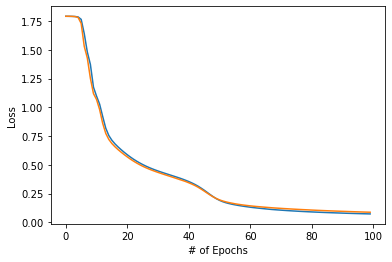

Training complete.
CPU Time:  67.27144980430603 s
Epoch 1, Training Error: 1.791063083931079, Validation Error: 1.791484150207872
Epoch 2, Training Error: 1.790801542032693, Validation Error: 1.791143458248802
Epoch 3, Training Error: 1.790325784776604, Validation Error: 1.790431778653576
Epoch 4, Training Error: 1.789175481734148, Validation Error: 1.788501721050445
Epoch 5, Training Error: 1.785397485585069, Validation Error: 1.781009722511856
Epoch 6, Training Error: 1.764483286937618, Validation Error: 1.729530861404864
Epoch 7, Training Error: 1.640488801710727, Validation Error: 1.529879935437911
Epoch 8, Training Error: 1.480465212469508, Validation Error: 1.428389369780311
Epoch 9, Training Error: 1.372219830098985, Validation Error: 1.252003119668153
Epoch 10, Training Error: 1.174777185155618, Validation Error: 1.118922547725453
Epoch 11, Training Error: 1.096810273726861, Validation Error: 1.067751340846653
Epoch 12, Training Error: 1.027150378990255, Validation Error: 0.980

In [43]:
Case10.train(traindata,trainlabel,100)

Test Accuracy: 93.03%
Class 1: 7 misclassifications
Class 2: 39 misclassifications
Class 3: 34 misclassifications
Class 4: 84 misclassifications
Class 5: 15 misclassifications
Class 6: 23 misclassifications


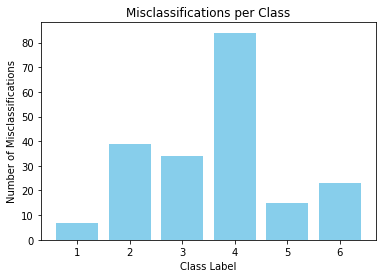

In [44]:
Case10.test_accuracy(testdata,testlabel)

Test Accuracy: 97.84%
Class 1: 1 misclassifications
Class 2: 19 misclassifications
Class 3: 5 misclassifications
Class 4: 99 misclassifications
Class 5: 35 misclassifications
Class 6: 0 misclassifications


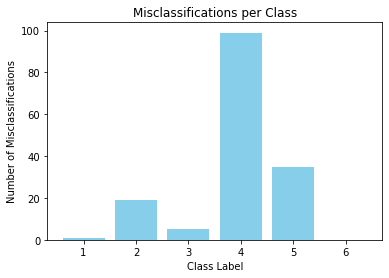

In [45]:
Case10.test_accuracy(traindata,trainlabel)

### Case 11

##### n= 0.01 N1= 300 N2= 100 momentum= 0.9 batch= 0

In [46]:
Case11= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.01,batch_size=1,momentum=0.9)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 366.87batch/s]


Epoch:  1
Train error: 0.787480417
Validation Error: 0.267454657


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.83batch/s]


Epoch:  2
Train error: 0.315149549
Validation Error: 0.213826881


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.07batch/s]


Epoch:  3
Train error: 0.227723040
Validation Error: 0.271566538


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 357.63batch/s]


Epoch:  4
Train error: 0.196483903
Validation Error: 0.204076597


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.29batch/s]


Epoch:  5
Train error: 0.181724797
Validation Error: 0.227815903


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.68batch/s]


Epoch:  6
Train error: 0.156472236
Validation Error: 0.201633995


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.68batch/s]


Epoch:  7
Train error: 0.153567377
Validation Error: 0.196939617


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.97batch/s]


Epoch:  8
Train error: 0.143060698
Validation Error: 0.213536538


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.56batch/s]


Epoch:  9
Train error: 0.138837193
Validation Error: 0.139332227


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.21batch/s]


Epoch:  10
Train error: 0.128300160
Validation Error: 0.131796390


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.99batch/s]


Epoch:  11
Train error: 0.117765618
Validation Error: 0.167554867


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 352.19batch/s]


Epoch:  12
Train error: 0.092505044
Validation Error: 0.152164611


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.97batch/s]


Epoch:  13
Train error: 0.086693867
Validation Error: 0.126966789


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.60batch/s]


Epoch:  14
Train error: 0.125187781
Validation Error: 0.130363670


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.24batch/s]


Epoch:  15
Train error: 0.122305344
Validation Error: 0.115793462


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 368.15batch/s]


Epoch:  16
Train error: 0.090844078
Validation Error: 0.117937242


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.87batch/s]


Epoch:  17
Train error: 0.092773611
Validation Error: 0.120845640


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.91batch/s]


Epoch:  18
Train error: 0.081713010
Validation Error: 0.104163846


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 364.96batch/s]


Epoch:  19
Train error: 0.091584554
Validation Error: 0.148162400


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.65batch/s]


Epoch:  20
Train error: 0.088370444
Validation Error: 0.124868438


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 359.03batch/s]


Epoch:  21
Train error: 0.088322198
Validation Error: 0.146228922


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.00batch/s]


Epoch:  22
Train error: 0.089385101
Validation Error: 0.117514034


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.32batch/s]


Epoch:  23
Train error: 0.070466478
Validation Error: 0.129256652


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.47batch/s]


Epoch:  24
Train error: 0.068147519
Validation Error: 0.232582937


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 358.18batch/s]


Epoch:  25
Train error: 0.070553545
Validation Error: 0.141250689


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 372.09batch/s]


Epoch:  26
Train error: 0.067575448
Validation Error: 0.195031740


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.74batch/s]


Epoch:  27
Train error: 0.087453200
Validation Error: 0.279782214


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 363.11batch/s]


Epoch:  28
Train error: 0.072690505
Validation Error: 0.084748182


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.99batch/s]


Epoch:  29
Train error: 0.088053410
Validation Error: 0.089863910


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 366.87batch/s]


Epoch:  30
Train error: 0.069157551
Validation Error: 0.098283592


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 351.12batch/s]


Epoch:  31
Train error: 0.063186434
Validation Error: 0.090197310


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 373.55batch/s]


Epoch:  32
Train error: 0.059672908
Validation Error: 0.156512882


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.33batch/s]


Epoch:  33
Train error: 0.057159150
Validation Error: 0.086057247


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.17batch/s]


Epoch:  34
Train error: 0.055366783
Validation Error: 0.080825818


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.23batch/s]


Epoch:  35
Train error: 0.060535002
Validation Error: 0.079826823


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.47batch/s]


Epoch:  36
Train error: 0.074974531
Validation Error: 0.145814959


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.68batch/s]


Epoch:  37
Train error: 0.069748668
Validation Error: 0.055602446


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 356.10batch/s]


Epoch:  38
Train error: 0.068420250
Validation Error: 0.070649668


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 370.20batch/s]


Epoch:  39
Train error: 0.052849491
Validation Error: 0.070655552


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 365.37batch/s]


Epoch:  40
Train error: 0.097991125
Validation Error: 0.150641531


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.57batch/s]


Epoch:  41
Train error: 0.093408968
Validation Error: 0.100793118


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.20batch/s]


Epoch:  42
Train error: 0.054171715
Validation Error: 0.076666780


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 371.82batch/s]


Epoch:  43
Train error: 0.085931490
Validation Error: 0.302543460


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 351.00batch/s]


Epoch:  44
Train error: 0.087408858
Validation Error: 0.104017757


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 369.19batch/s]


Epoch:  45
Train error: 0.085130684
Validation Error: 0.080653166


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.59batch/s]


Epoch:  46
Train error: 0.068271521
Validation Error: 0.079341741


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 366.28batch/s]


Training Stopped


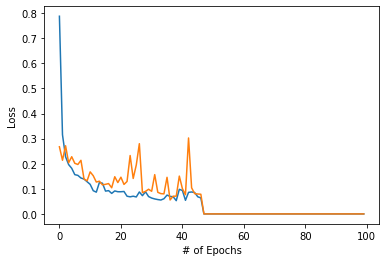

Training complete.
CPU Time:  858.5090000629425 s
Epoch 1, Training Error: 0.787480416958518, Validation Error: 0.267454656680580
Epoch 2, Training Error: 0.315149549384611, Validation Error: 0.213826881281773
Epoch 3, Training Error: 0.227723039920832, Validation Error: 0.271566538234900
Epoch 4, Training Error: 0.196483903321529, Validation Error: 0.204076596824221
Epoch 5, Training Error: 0.181724797057474, Validation Error: 0.227815903358228
Epoch 6, Training Error: 0.156472235799899, Validation Error: 0.201633994571607
Epoch 7, Training Error: 0.153567377336730, Validation Error: 0.196939616580175
Epoch 8, Training Error: 0.143060698224504, Validation Error: 0.213536537896050
Epoch 9, Training Error: 0.138837192501369, Validation Error: 0.139332226649495
Epoch 10, Training Error: 0.128300159700964, Validation Error: 0.131796389951831
Epoch 11, Training Error: 0.117765618299473, Validation Error: 0.167554866605271
Epoch 12, Training Error: 0.092505043980211, Validation Error: 0.152

In [47]:
Case11.train(traindata,trainlabel,100)

Test Accuracy: 91.89%
Class 1: 13 misclassifications
Class 2: 43 misclassifications
Class 3: 37 misclassifications
Class 4: 105 misclassifications
Class 5: 13 misclassifications
Class 6: 28 misclassifications


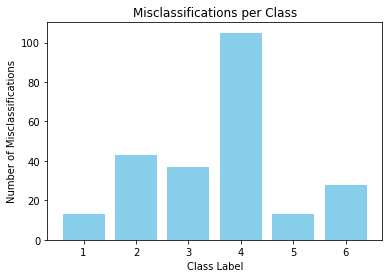

In [48]:
Case11.test_accuracy(testdata,testlabel)

Test Accuracy: 98.27%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 106 misclassifications
Class 5: 19 misclassifications
Class 6: 0 misclassifications


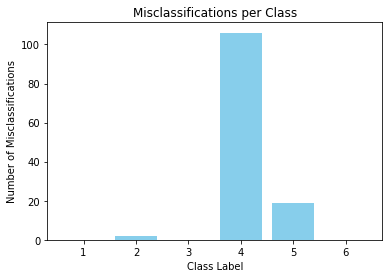

In [49]:
Case11.test_accuracy(traindata,trainlabel)

### Case 12

##### n= 0.01 N1= 300 N2= 100 momentum= 0.9 batch= 50

In [50]:
Case12= HAR(hidden_size_1=300,hidden_size_2=100,learning_coef=0.01,batch_size=50,momentum=0.9)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]


Epoch:  1
Train error: 1.791065282
Validation Error: 1.791383415


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.71batch/s]

Epoch:  2
Train error: 1.790430932
Validation Error: 1.790209808



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]


Epoch:  3
Train error: 1.786800865
Validation Error: 1.779719950


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 196.21batch/s]

Epoch:  4
Train error: 1.704561513
Validation Error: 1.540787811



Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.02batch/s]


Epoch:  5
Train error: 1.460716100
Validation Error: 1.372461393


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.22batch/s]

Epoch:  6
Train error: 1.204126843
Validation Error: 1.101398433



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.17batch/s]

Epoch:  7
Train error: 1.034224703
Validation Error: 0.938184634



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  8
Train error: 0.854555370
Validation Error: 0.765787139



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.26batch/s]

Epoch:  9
Train error: 0.752029335
Validation Error: 0.690510654



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 193.46batch/s]

Epoch:  10
Train error: 0.698152111
Validation Error: 0.640800344



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]

Epoch:  11
Train error: 0.654453051
Validation Error: 0.599091148



Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.27batch/s]

Epoch:  12
Train error: 0.617517722
Validation Error: 0.564206611



Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.40batch/s]

Epoch:  13
Train error: 0.586583113
Validation Error: 0.534182627



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.24batch/s]

Epoch:  14
Train error: 0.560185987
Validation Error: 0.506541455



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.79batch/s]

Epoch:  15
Train error: 0.537445435
Validation Error: 0.483893721



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.41batch/s]

Epoch:  16
Train error: 0.518239998
Validation Error: 0.470127240



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.91batch/s]


Epoch:  17
Train error: 0.501520304
Validation Error: 0.464542782


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.41batch/s]

Epoch:  18
Train error: 0.486669068
Validation Error: 0.463294337



Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.88batch/s]


Epoch:  19
Train error: 0.472790029
Validation Error: 0.459820323


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.26batch/s]

Epoch:  20
Train error: 0.459102854
Validation Error: 0.454775916



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 198.25batch/s]

Epoch:  21
Train error: 0.445959461
Validation Error: 0.443564010



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.57batch/s]

Epoch:  22
Train error: 0.432422170
Validation Error: 0.432120785



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.26batch/s]

Epoch:  23
Train error: 0.416722705
Validation Error: 0.417286004



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.99batch/s]

Epoch:  24
Train error: 0.398674704
Validation Error: 0.391755006



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.05batch/s]

Epoch:  25
Train error: 0.374110084
Validation Error: 0.364498842



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.67batch/s]

Epoch:  26
Train error: 0.341417628
Validation Error: 0.333418442



Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.72batch/s]

Epoch:  27
Train error: 0.301015912
Validation Error: 0.300455988



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.31batch/s]


Epoch:  28
Train error: 0.259191612
Validation Error: 0.264214615


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.54batch/s]

Epoch:  29
Train error: 0.225677705
Validation Error: 0.245570181



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 197.51batch/s]

Epoch:  30
Train error: 0.205330566
Validation Error: 0.221205086



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  31
Train error: 0.190967142
Validation Error: 0.198321544



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.92batch/s]


Epoch:  32
Train error: 0.178673425
Validation Error: 0.169312264


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]

Epoch:  33
Train error: 0.168698314
Validation Error: 0.151615297



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  34
Train error: 0.159689956
Validation Error: 0.139177595



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.92batch/s]


Epoch:  35
Train error: 0.151837595
Validation Error: 0.132151748


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  36
Train error: 0.144785538
Validation Error: 0.127788511



Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.73batch/s]

Epoch:  37
Train error: 0.138872654
Validation Error: 0.124680835



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.04batch/s]


Epoch:  38
Train error: 0.133671518
Validation Error: 0.122326975


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.04batch/s]

Epoch:  39
Train error: 0.128077610
Validation Error: 0.119967250



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.04batch/s]


Epoch:  40
Train error: 0.123432839
Validation Error: 0.117638154


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.37batch/s]

Epoch:  41
Train error: 0.118560899
Validation Error: 0.115421429



Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 220.19batch/s]

Epoch:  42
Train error: 0.114729737
Validation Error: 0.112655088



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.89batch/s]


Epoch:  43
Train error: 0.111118607
Validation Error: 0.109995079


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  44
Train error: 0.107895460
Validation Error: 0.107384302



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 217.22batch/s]

Epoch:  45
Train error: 0.105170805
Validation Error: 0.104873924



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.93batch/s]


Epoch:  46
Train error: 0.102195322
Validation Error: 0.102084813


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.23batch/s]

Epoch:  47
Train error: 0.099851040
Validation Error: 0.099647819



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.42batch/s]

Epoch:  48
Train error: 0.097346498
Validation Error: 0.097329173



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  49
Train error: 0.095328158
Validation Error: 0.094975773



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]

Epoch:  50
Train error: 0.093505080
Validation Error: 0.093030120



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.92batch/s]


Epoch:  51
Train error: 0.091681616
Validation Error: 0.091336186


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.72batch/s]

Epoch:  52
Train error: 0.090023463
Validation Error: 0.089774001



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.24batch/s]

Epoch:  53
Train error: 0.088400358
Validation Error: 0.088677130



Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.57batch/s]


Epoch:  54
Train error: 0.086676212
Validation Error: 0.087383616


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.73batch/s]

Epoch:  55
Train error: 0.085294981
Validation Error: 0.086263450



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 220.20batch/s]

Epoch:  56
Train error: 0.083684298
Validation Error: 0.085123146



Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.90batch/s]


Epoch:  57
Train error: 0.082465441
Validation Error: 0.084374147


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.06batch/s]

Epoch:  58
Train error: 0.081036857
Validation Error: 0.083489718



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.57batch/s]

Epoch:  59
Train error: 0.079669550
Validation Error: 0.082850213



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.18batch/s]

Epoch:  60
Train error: 0.078515685
Validation Error: 0.082330746



Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.95batch/s]


Epoch:  61
Train error: 0.077286711
Validation Error: 0.082060470


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.37batch/s]

Epoch:  62
Train error: 0.076192944
Validation Error: 0.082201614



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.18batch/s]

Epoch:  63
Train error: 0.075157229
Validation Error: 0.081708781



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.89batch/s]

Epoch:  64
Train error: 0.074143590
Validation Error: 0.081598695



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.72batch/s]


Epoch:  65
Train error: 0.073259114
Validation Error: 0.081805893


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.73batch/s]

Epoch:  66
Train error: 0.072183789
Validation Error: 0.081745705



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.41batch/s]

Epoch:  67
Train error: 0.071286596
Validation Error: 0.081606696



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.77batch/s]

Epoch:  68
Train error: 0.070501850
Validation Error: 0.081904182



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.37batch/s]

Epoch:  69
Train error: 0.069618773
Validation Error: 0.082462667



Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.56batch/s]

Epoch:  70
Train error: 0.068779281
Validation Error: 0.082630680



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 221.40batch/s]

Epoch:  71
Train error: 0.068124223
Validation Error: 0.083833647



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 215.75batch/s]

Epoch:  72
Train error: 0.067299311
Validation Error: 0.083887407



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.41batch/s]

Epoch:  73
Train error: 0.066606616
Validation Error: 0.084896680



Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.38batch/s]


Training Stopped


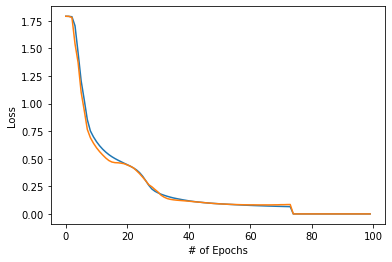

Training complete.
CPU Time:  49.48987078666687 s
Epoch 1, Training Error: 1.791065281645917, Validation Error: 1.791383414637436
Epoch 2, Training Error: 1.790430932188751, Validation Error: 1.790209808293253
Epoch 3, Training Error: 1.786800864797730, Validation Error: 1.779719949763769
Epoch 4, Training Error: 1.704561512920644, Validation Error: 1.540787810939646
Epoch 5, Training Error: 1.460716100267354, Validation Error: 1.372461393435092
Epoch 6, Training Error: 1.204126843416518, Validation Error: 1.101398433375839
Epoch 7, Training Error: 1.034224702894793, Validation Error: 0.938184634039679
Epoch 8, Training Error: 0.854555370375897, Validation Error: 0.765787138830782
Epoch 9, Training Error: 0.752029334897757, Validation Error: 0.690510653935038
Epoch 10, Training Error: 0.698152110675683, Validation Error: 0.640800344045471
Epoch 11, Training Error: 0.654453050712409, Validation Error: 0.599091147550075
Epoch 12, Training Error: 0.617517722004290, Validation Error: 0.564

In [51]:
Case12.train(traindata,trainlabel,100)

Test Accuracy: 92.28%
Class 1: 12 misclassifications
Class 2: 36 misclassifications
Class 3: 35 misclassifications
Class 4: 104 misclassifications
Class 5: 14 misclassifications
Class 6: 23 misclassifications


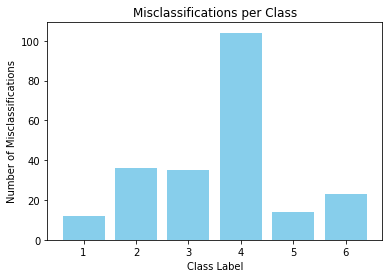

In [52]:
Case12.test_accuracy(testdata,testlabel)

Test Accuracy: 97.92%
Class 1: 0 misclassifications
Class 2: 3 misclassifications
Class 3: 1 misclassifications
Class 4: 128 misclassifications
Class 5: 21 misclassifications
Class 6: 0 misclassifications


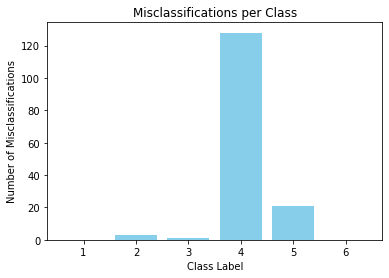

In [53]:
Case12.test_accuracy(traindata,trainlabel)

### Case 13

##### n= 0.01 N1= 300 N2= 200 momentum= 0 batch= 0

In [54]:
Case13= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.01,batch_size=1,momentum=0.0)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.79batch/s]


Epoch:  1
Train error: 0.919604775
Validation Error: 0.438366476


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.02batch/s]


Epoch:  2
Train error: 0.312094734
Validation Error: 0.306734716


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.97batch/s]


Epoch:  3
Train error: 0.209961866
Validation Error: 0.239651563


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.72batch/s]


Epoch:  4
Train error: 0.160529398
Validation Error: 0.214182771


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.87batch/s]


Epoch:  5
Train error: 0.133281670
Validation Error: 0.197276161


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.14batch/s]


Epoch:  6
Train error: 0.112517932
Validation Error: 0.232644467


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 327.28batch/s]


Epoch:  7
Train error: 0.107319883
Validation Error: 0.244558965


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.80batch/s]


Epoch:  8
Train error: 0.106249754
Validation Error: 0.175798569


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.42batch/s]


Epoch:  9
Train error: 0.090328018
Validation Error: 0.160245006


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.29batch/s]


Epoch:  10
Train error: 0.081495830
Validation Error: 0.212672344


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.95batch/s]


Epoch:  11
Train error: 0.073769561
Validation Error: 0.192546138


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.80batch/s]


Epoch:  12
Train error: 0.082795015
Validation Error: 0.224599218


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.51batch/s]


Epoch:  13
Train error: 0.083799990
Validation Error: 0.090954908


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.17batch/s]


Epoch:  14
Train error: 0.068413965
Validation Error: 0.184646628


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 330.08batch/s]


Epoch:  15
Train error: 0.064870029
Validation Error: 0.110474504


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.34batch/s]


Epoch:  16
Train error: 0.071403879
Validation Error: 0.186186355


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.49batch/s]


Epoch:  17
Train error: 0.066453101
Validation Error: 0.190395702


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.43batch/s]


Epoch:  18
Train error: 0.063358108
Validation Error: 0.165291320


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.18batch/s]


Epoch:  19
Train error: 0.062520412
Validation Error: 0.348588845


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.80batch/s]


Epoch:  20
Train error: 0.070849522
Validation Error: 0.308461656


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.90batch/s]


Epoch:  21
Train error: 0.055610370
Validation Error: 0.249738208


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.49batch/s]


Epoch:  22
Train error: 0.054308276
Validation Error: 0.080800409


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.37batch/s]


Epoch:  23
Train error: 0.050862025
Validation Error: 0.165088281


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.60batch/s]


Epoch:  24
Train error: 0.050822509
Validation Error: 0.071682404


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.02batch/s]


Epoch:  25
Train error: 0.051987395
Validation Error: 0.154329771


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.09batch/s]


Epoch:  26
Train error: 0.047626806
Validation Error: 0.089278712


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.76batch/s]


Epoch:  27
Train error: 0.046663792
Validation Error: 0.069066749


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.47batch/s]


Epoch:  28
Train error: 0.041973799
Validation Error: 0.106964940


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.30batch/s]


Epoch:  29
Train error: 0.048203810
Validation Error: 0.081286789


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.89batch/s]


Epoch:  30
Train error: 0.040952029
Validation Error: 0.118828824


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.68batch/s]


Epoch:  31
Train error: 0.044459250
Validation Error: 0.249946913


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.55batch/s]


Epoch:  32
Train error: 0.060813327
Validation Error: 0.077878773


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.96batch/s]


Epoch:  33
Train error: 0.040928422
Validation Error: 0.061992031


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.38batch/s]


Epoch:  34
Train error: 0.039537439
Validation Error: 0.084134987


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.65batch/s]


Epoch:  35
Train error: 0.038450087
Validation Error: 0.064989338


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.18batch/s]


Epoch:  36
Train error: 0.038108300
Validation Error: 0.056843582


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.43batch/s]


Epoch:  37
Train error: 0.037875477
Validation Error: 0.069579767


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.82batch/s]


Epoch:  38
Train error: 0.036574760
Validation Error: 0.107924856


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.66batch/s]


Epoch:  39
Train error: 0.052237385
Validation Error: 0.050328133


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.03batch/s]


Epoch:  40
Train error: 0.039720776
Validation Error: 0.058819570


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.00batch/s]


Epoch:  41
Train error: 0.048589887
Validation Error: 0.231149456


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.72batch/s]


Epoch:  42
Train error: 0.048797382
Validation Error: 0.074219708


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.19batch/s]


Epoch:  43
Train error: 0.040176345
Validation Error: 0.071949998


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.08batch/s]


Epoch:  44
Train error: 0.035914663
Validation Error: 0.055708366


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.23batch/s]


Epoch:  45
Train error: 0.034505507
Validation Error: 0.068062682


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 329.80batch/s]


Epoch:  46
Train error: 0.033456570
Validation Error: 0.055053870


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.44batch/s]


Epoch:  47
Train error: 0.040285661
Validation Error: 0.068498235


Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.72batch/s]


Epoch:  48
Train error: 0.034974177
Validation Error: 0.079605433


Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 327.97batch/s]


Training Stopped


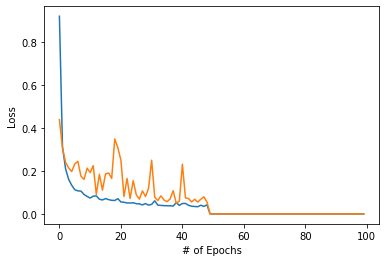

Training complete.
CPU Time:  967.0076775550842 s
Epoch 1, Training Error: 0.919604774809789, Validation Error: 0.438366475803215
Epoch 2, Training Error: 0.312094734042287, Validation Error: 0.306734716282336
Epoch 3, Training Error: 0.209961866315004, Validation Error: 0.239651562669150
Epoch 4, Training Error: 0.160529397722302, Validation Error: 0.214182770651326
Epoch 5, Training Error: 0.133281670262956, Validation Error: 0.197276160607965
Epoch 6, Training Error: 0.112517931896187, Validation Error: 0.232644466817811
Epoch 7, Training Error: 0.107319883130576, Validation Error: 0.244558964766962
Epoch 8, Training Error: 0.106249754391313, Validation Error: 0.175798569375772
Epoch 9, Training Error: 0.090328018402167, Validation Error: 0.160245005633399
Epoch 10, Training Error: 0.081495830071970, Validation Error: 0.212672343547599
Epoch 11, Training Error: 0.073769561328720, Validation Error: 0.192546138150293
Epoch 12, Training Error: 0.082795015446401, Validation Error: 0.224

In [55]:
Case13.train(traindata,trainlabel,100)

Test Accuracy: 93.38%
Class 1: 7 misclassifications
Class 2: 44 misclassifications
Class 3: 42 misclassifications
Class 4: 65 misclassifications
Class 5: 28 misclassifications
Class 6: 9 misclassifications


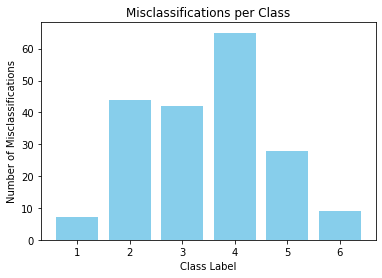

In [56]:
Case13.test_accuracy(testdata,testlabel)

Test Accuracy: 99.10%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 16 misclassifications
Class 5: 48 misclassifications
Class 6: 0 misclassifications


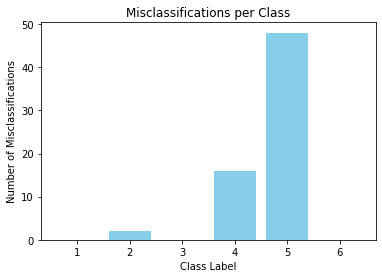

In [57]:
Case13.test_accuracy(traindata,trainlabel)

### Case 14

##### n= 0.01 N1= 300 N2= 200 momentum= 0 batch= 50

In [58]:
Case14= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.01,batch_size=50,momentum=0.0)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.22batch/s]

Epoch:  1
Train error: 1.790971748
Validation Error: 1.791222147



Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.01batch/s]

Epoch:  2
Train error: 1.790342897
Validation Error: 1.790372904



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]


Epoch:  3
Train error: 1.789067045
Validation Error: 1.788306901


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.18batch/s]

Epoch:  4
Train error: 1.785067937
Validation Error: 1.780446363



Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.36batch/s]


Epoch:  5
Train error: 1.763215932
Validation Error: 1.726881815


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.17batch/s]

Epoch:  6
Train error: 1.635383731
Validation Error: 1.522322520



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.12batch/s]

Epoch:  7
Train error: 1.462269083
Validation Error: 1.385680529



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.18batch/s]

Epoch:  8
Train error: 1.278616668
Validation Error: 1.162688295



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.38batch/s]

Epoch:  9
Train error: 1.131053637
Validation Error: 1.098379052



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.50batch/s]

Epoch:  10
Train error: 1.072354184
Validation Error: 1.039012453



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.22batch/s]

Epoch:  11
Train error: 0.986126488
Validation Error: 0.929715887



Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.63batch/s]


Epoch:  12
Train error: 0.869829519
Validation Error: 0.814240538


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.03batch/s]

Epoch:  13
Train error: 0.781086110
Validation Error: 0.741909513



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.19batch/s]

Epoch:  14
Train error: 0.728142755
Validation Error: 0.698020981



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.15batch/s]

Epoch:  15
Train error: 0.692437112
Validation Error: 0.666657455



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.83batch/s]

Epoch:  16
Train error: 0.663958978
Validation Error: 0.640859963



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.68batch/s]

Epoch:  17
Train error: 0.638953266
Validation Error: 0.617804107



Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 174.19batch/s]

Epoch:  18
Train error: 0.616052702
Validation Error: 0.596522578



Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.91batch/s]

Epoch:  19
Train error: 0.594743505
Validation Error: 0.576475204



Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.29batch/s]

Epoch:  20
Train error: 0.574826063
Validation Error: 0.557527155



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.94batch/s]

Epoch:  21
Train error: 0.556236061
Validation Error: 0.539675887



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.00batch/s]

Epoch:  22
Train error: 0.538934236
Validation Error: 0.522971430



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 161.62batch/s]

Epoch:  23
Train error: 0.522907551
Validation Error: 0.507480223



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.45batch/s]

Epoch:  24
Train error: 0.508107212
Validation Error: 0.493173663



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.44batch/s]

Epoch:  25
Train error: 0.494432716
Validation Error: 0.480000234



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]

Epoch:  26
Train error: 0.481727746
Validation Error: 0.467824762



Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 168.34batch/s]

Epoch:  27
Train error: 0.469845162
Validation Error: 0.456295665



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]

Epoch:  28
Train error: 0.458548440
Validation Error: 0.445247539



Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 200.45batch/s]

Epoch:  29
Train error: 0.447594963
Validation Error: 0.434316671



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.93batch/s]

Epoch:  30
Train error: 0.436695286
Validation Error: 0.423283950



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.71batch/s]

Epoch:  31
Train error: 0.425441510
Validation Error: 0.411655526



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.19batch/s]


Epoch:  32
Train error: 0.413276271
Validation Error: 0.398836456


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 174.63batch/s]

Epoch:  33
Train error: 0.399442620
Validation Error: 0.384115173



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.00batch/s]

Epoch:  34
Train error: 0.382762295
Validation Error: 0.366327042



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.04batch/s]


Epoch:  35
Train error: 0.361811666
Validation Error: 0.343878121


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.67batch/s]


Epoch:  36
Train error: 0.335804156
Validation Error: 0.317159907


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.10batch/s]

Epoch:  37
Train error: 0.305572298
Validation Error: 0.288445257



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 173.92batch/s]

Epoch:  38
Train error: 0.275027529
Validation Error: 0.261996301



Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.41batch/s]

Epoch:  39
Train error: 0.248656570
Validation Error: 0.241497162



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.66batch/s]

Epoch:  40
Train error: 0.228103628
Validation Error: 0.225891640



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 157.67batch/s]

Epoch:  41
Train error: 0.212436098
Validation Error: 0.213582488



Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.93batch/s]

Epoch:  42
Train error: 0.200117796
Validation Error: 0.203436807



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.34batch/s]

Epoch:  43
Train error: 0.190049856
Validation Error: 0.194814297



Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.77batch/s]

Epoch:  44
Train error: 0.181605603
Validation Error: 0.187371981



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.45batch/s]


Epoch:  45
Train error: 0.174345001
Validation Error: 0.180826328


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.35batch/s]

Epoch:  46
Train error: 0.167940019
Validation Error: 0.175060481



Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.99batch/s]

Epoch:  47
Train error: 0.162296153
Validation Error: 0.170039990



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.83batch/s]

Epoch:  48
Train error: 0.157257560
Validation Error: 0.165698578



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 161.04batch/s]

Epoch:  49
Train error: 0.152707465
Validation Error: 0.161613202



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 167.33batch/s]

Epoch:  50
Train error: 0.148517283
Validation Error: 0.157903661



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 198.60batch/s]

Epoch:  51
Train error: 0.144684683
Validation Error: 0.154477116



Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 196.33batch/s]

Epoch:  52
Train error: 0.141187996
Validation Error: 0.151528262



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.02batch/s]


Epoch:  53
Train error: 0.137837461
Validation Error: 0.148594065


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.32batch/s]

Epoch:  54
Train error: 0.134643345
Validation Error: 0.145801806



Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.28batch/s]

Epoch:  55
Train error: 0.131663128
Validation Error: 0.143228321



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.71batch/s]


Epoch:  56
Train error: 0.128870236
Validation Error: 0.140856116


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.61batch/s]

Epoch:  57
Train error: 0.126249847
Validation Error: 0.138589578



Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.33batch/s]

Epoch:  58
Train error: 0.123768621
Validation Error: 0.136363319



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.62batch/s]

Epoch:  59
Train error: 0.121390539
Validation Error: 0.134260501



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.63batch/s]

Epoch:  60
Train error: 0.119095026
Validation Error: 0.132249329



Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.19batch/s]

Epoch:  61
Train error: 0.116896649
Validation Error: 0.130330361



Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.54batch/s]

Epoch:  62
Train error: 0.114809911
Validation Error: 0.128490030



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.08batch/s]


Epoch:  63
Train error: 0.112796512
Validation Error: 0.126719049


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.97batch/s]

Epoch:  64
Train error: 0.110856340
Validation Error: 0.125026622



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.65batch/s]

Epoch:  65
Train error: 0.108987306
Validation Error: 0.123342499



Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.77batch/s]

Epoch:  66
Train error: 0.107166665
Validation Error: 0.121769829



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.09batch/s]

Epoch:  67
Train error: 0.105419613
Validation Error: 0.120237535



Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.82batch/s]

Epoch:  68
Train error: 0.103711166
Validation Error: 0.118739341



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.12batch/s]

Epoch:  69
Train error: 0.102106452
Validation Error: 0.117302625



Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.87batch/s]

Epoch:  70
Train error: 0.100538195
Validation Error: 0.115908494



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.29batch/s]

Epoch:  71
Train error: 0.099023368
Validation Error: 0.114518074



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.23batch/s]

Epoch:  72
Train error: 0.097517390
Validation Error: 0.113165866



Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.60batch/s]

Epoch:  73
Train error: 0.096049003
Validation Error: 0.111845815



Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.82batch/s]

Epoch:  74
Train error: 0.094543237
Validation Error: 0.110551766



Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.33batch/s]

Epoch:  75
Train error: 0.093151988
Validation Error: 0.109377700



Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.49batch/s]

Epoch:  76
Train error: 0.091958861
Validation Error: 0.108110404



Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.06batch/s]

Epoch:  77
Train error: 0.090708541
Validation Error: 0.106985159



Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 198.83batch/s]

Epoch:  78
Train error: 0.089516524
Validation Error: 0.105874599



Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.50batch/s]

Epoch:  79
Train error: 0.088371872
Validation Error: 0.104774322



Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]

Epoch:  80
Train error: 0.087254802
Validation Error: 0.103706478



Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.60batch/s]

Epoch:  81
Train error: 0.086146081
Validation Error: 0.102640752



Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.56batch/s]

Epoch:  82
Train error: 0.085081054
Validation Error: 0.101597406



Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.62batch/s]

Epoch:  83
Train error: 0.084033905
Validation Error: 0.100552923



Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.03batch/s]

Epoch:  84
Train error: 0.083021244
Validation Error: 0.099563521



Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.92batch/s]

Epoch:  85
Train error: 0.082045108
Validation Error: 0.098544469



Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 167.26batch/s]

Epoch:  86
Train error: 0.081092901
Validation Error: 0.097606894



Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 158.22batch/s]

Epoch:  87
Train error: 0.080176828
Validation Error: 0.096659664



Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 158.86batch/s]

Epoch:  88
Train error: 0.079287146
Validation Error: 0.095720992



Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 147.31batch/s]

Epoch:  89
Train error: 0.078415902
Validation Error: 0.094837324



Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 158.19batch/s]


Epoch:  90
Train error: 0.077553580
Validation Error: 0.093960809


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.94batch/s]

Epoch:  91
Train error: 0.076746649
Validation Error: 0.093102645



Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 199.25batch/s]

Epoch:  92
Train error: 0.075926325
Validation Error: 0.092261141



Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.87batch/s]

Epoch:  93
Train error: 0.075155705
Validation Error: 0.091430980



Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.52batch/s]

Epoch:  94
Train error: 0.074400860
Validation Error: 0.090612523



Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 149.87batch/s]

Epoch:  95
Train error: 0.073662964
Validation Error: 0.089816790



Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 158.76batch/s]

Epoch:  96
Train error: 0.072948299
Validation Error: 0.089054287



Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.60batch/s]

Epoch:  97
Train error: 0.072258351
Validation Error: 0.088282575



Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.84batch/s]

Epoch:  98
Train error: 0.071552744
Validation Error: 0.087532799



Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.06batch/s]

Epoch:  99
Train error: 0.070905882
Validation Error: 0.086824039



Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.77batch/s]

Epoch:  100
Train error: 0.070273060
Validation Error: 0.086052148


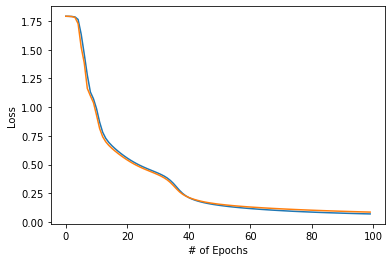

Training complete.
CPU Time:  75.06980037689209 s
Epoch 1, Training Error: 1.790971748105322, Validation Error: 1.791222146989684
Epoch 2, Training Error: 1.790342897076262, Validation Error: 1.790372903965928
Epoch 3, Training Error: 1.789067045327288, Validation Error: 1.788306901037560
Epoch 4, Training Error: 1.785067936976009, Validation Error: 1.780446363223233
Epoch 5, Training Error: 1.763215931808603, Validation Error: 1.726881815226624
Epoch 6, Training Error: 1.635383730748547, Validation Error: 1.522322519697646
Epoch 7, Training Error: 1.462269082656937, Validation Error: 1.385680529464525
Epoch 8, Training Error: 1.278616667920351, Validation Error: 1.162688295127243
Epoch 9, Training Error: 1.131053636632021, Validation Error: 1.098379051653363
Epoch 10, Training Error: 1.072354184246046, Validation Error: 1.039012453160260
Epoch 11, Training Error: 0.986126487930827, Validation Error: 0.929715886612164
Epoch 12, Training Error: 0.869829518749322, Validation Error: 0.814

In [59]:
Case14.train(traindata,trainlabel,100)

Test Accuracy: 93.17%
Class 1: 8 misclassifications
Class 2: 37 misclassifications
Class 3: 38 misclassifications
Class 4: 79 misclassifications
Class 5: 13 misclassifications
Class 6: 23 misclassifications


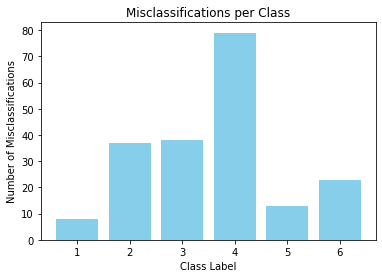

In [60]:
Case14.test_accuracy(testdata,testlabel)

Test Accuracy: 98.04%
Class 1: 1 misclassifications
Class 2: 10 misclassifications
Class 3: 3 misclassifications
Class 4: 95 misclassifications
Class 5: 35 misclassifications
Class 6: 0 misclassifications


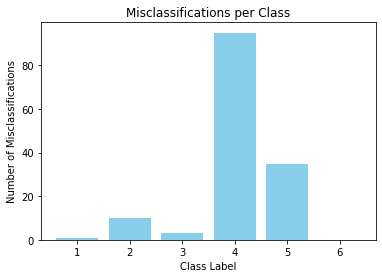

In [61]:
Case14.test_accuracy(traindata,trainlabel)

### Case 15

##### n= 0.01 N1= 300 N2= 200 momentum= 0.9 batch= 0

In [62]:
Case15= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.01,batch_size=1,momentum=0.9)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.56batch/s]


Epoch:  1
Train error: 0.770836789
Validation Error: 0.862668000


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.39batch/s]


Epoch:  2
Train error: 0.313344909
Validation Error: 0.196755007


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.87batch/s]


Epoch:  3
Train error: 0.217846951
Validation Error: 0.204636260


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.36batch/s]


Epoch:  4
Train error: 0.186235885
Validation Error: 0.213343351


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.76batch/s]


Epoch:  5
Train error: 0.166816042
Validation Error: 0.152302400


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.44batch/s]


Epoch:  6
Train error: 0.137672547
Validation Error: 0.196697617


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.95batch/s]


Epoch:  7
Train error: 0.138610235
Validation Error: 0.182029332


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 328.95batch/s]


Epoch:  8
Train error: 0.117356912
Validation Error: 0.399375717


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.65batch/s]


Epoch:  9
Train error: 0.127400624
Validation Error: 0.209427517


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.08batch/s]


Epoch:  10
Train error: 0.104678400
Validation Error: 0.174128558


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.56batch/s]


Epoch:  11
Train error: 0.092585902
Validation Error: 0.149820437


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.61batch/s]


Epoch:  12
Train error: 0.088393691
Validation Error: 0.119382733


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.55batch/s]


Epoch:  13
Train error: 0.106083498
Validation Error: 0.129187086


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.82batch/s]


Epoch:  14
Train error: 0.093341485
Validation Error: 0.157334161


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 339.04batch/s]


Epoch:  15
Train error: 0.117320006
Validation Error: 0.098352670


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.99batch/s]


Epoch:  16
Train error: 0.093220555
Validation Error: 0.191065381


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.41batch/s]


Epoch:  17
Train error: 0.082552337
Validation Error: 0.082443397


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.95batch/s]


Epoch:  18
Train error: 0.086247978
Validation Error: 0.242022922


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.30batch/s]


Epoch:  19
Train error: 0.079904939
Validation Error: 0.082944267


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.10batch/s]


Epoch:  20
Train error: 0.068732196
Validation Error: 0.190509344


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.89batch/s]


Epoch:  21
Train error: 0.081135637
Validation Error: 0.114427915


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.80batch/s]


Epoch:  22
Train error: 0.089922089
Validation Error: 0.089515680


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.21batch/s]


Epoch:  23
Train error: 0.071281416
Validation Error: 0.077904811


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.47batch/s]


Epoch:  24
Train error: 0.071326089
Validation Error: 0.094852321


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.99batch/s]


Epoch:  25
Train error: 0.076127603
Validation Error: 0.220043512


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.73batch/s]


Epoch:  26
Train error: 0.061733657
Validation Error: 0.144440271


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.21batch/s]


Epoch:  27
Train error: 0.075288154
Validation Error: 0.078263407


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.44batch/s]


Epoch:  28
Train error: 0.053391123
Validation Error: 0.081992999


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 347.23batch/s]


Epoch:  29
Train error: 0.062306456
Validation Error: 0.082918276


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.37batch/s]


Epoch:  30
Train error: 0.055816116
Validation Error: 0.080215331


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.76batch/s]


Epoch:  31
Train error: 0.054166841
Validation Error: 0.089350401


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.33batch/s]


Epoch:  32
Train error: 0.063803149
Validation Error: 0.069816714


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.70batch/s]


Epoch:  33
Train error: 0.057989820
Validation Error: 0.086476478


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.97batch/s]


Epoch:  34
Train error: 0.059324997
Validation Error: 0.156939854


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.29batch/s]


Epoch:  35
Train error: 0.052473143
Validation Error: 0.064771091


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.44batch/s]


Epoch:  36
Train error: 0.061595368
Validation Error: 0.076416747


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.47batch/s]


Epoch:  37
Train error: 0.051524058
Validation Error: 0.083365720


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.68batch/s]


Epoch:  38
Train error: 0.049662576
Validation Error: 0.090645940


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.00batch/s]


Epoch:  39
Train error: 0.045254495
Validation Error: 0.099628840


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.33batch/s]


Epoch:  40
Train error: 0.047226652
Validation Error: 0.080363798


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 329.21batch/s]


Epoch:  41
Train error: 0.046721777
Validation Error: 0.069898641


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 345.37batch/s]


Epoch:  42
Train error: 0.051068609
Validation Error: 0.261681356


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.56batch/s]


Epoch:  43
Train error: 0.043595709
Validation Error: 0.068823482


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 342.57batch/s]


Epoch:  44
Train error: 0.042161324
Validation Error: 0.088087817


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.94batch/s]


Training Stopped


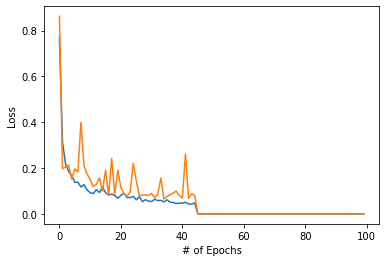

Training complete.
CPU Time:  884.8955538272858 s
Epoch 1, Training Error: 0.770836788994066, Validation Error: 0.862668000250103
Epoch 2, Training Error: 0.313344909302680, Validation Error: 0.196755006522362
Epoch 3, Training Error: 0.217846951457804, Validation Error: 0.204636259514862
Epoch 4, Training Error: 0.186235884730591, Validation Error: 0.213343350871661
Epoch 5, Training Error: 0.166816041815614, Validation Error: 0.152302399549542
Epoch 6, Training Error: 0.137672546998123, Validation Error: 0.196697616958035
Epoch 7, Training Error: 0.138610235344837, Validation Error: 0.182029331968156
Epoch 8, Training Error: 0.117356911889365, Validation Error: 0.399375716812219
Epoch 9, Training Error: 0.127400623953905, Validation Error: 0.209427516896965
Epoch 10, Training Error: 0.104678399913881, Validation Error: 0.174128557906269
Epoch 11, Training Error: 0.092585901504747, Validation Error: 0.149820437467589
Epoch 12, Training Error: 0.088393691305501, Validation Error: 0.119

In [63]:
Case15.train(traindata,trainlabel,100)

Test Accuracy: 90.74%
Class 1: 8 misclassifications
Class 2: 70 misclassifications
Class 3: 62 misclassifications
Class 4: 87 misclassifications
Class 5: 17 misclassifications
Class 6: 29 misclassifications


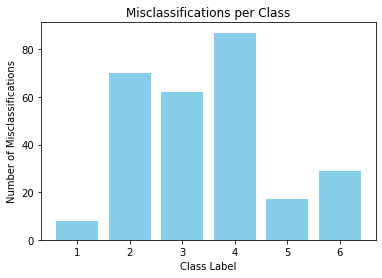

In [64]:
Case15.test_accuracy(testdata,testlabel)

Test Accuracy: 98.75%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 0 misclassifications
Class 4: 52 misclassifications
Class 5: 29 misclassifications
Class 6: 9 misclassifications


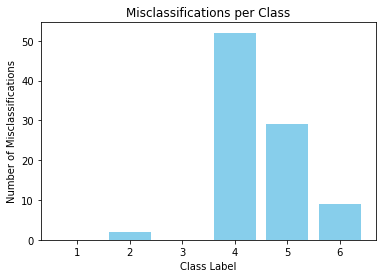

In [65]:
Case15.test_accuracy(traindata,trainlabel)

### Case 16

##### n= 0.01 N1= 300 N2= 200 momentum= 0.9 batch= 50

In [66]:
Case16= HAR(hidden_size_1=300,hidden_size_2=200,learning_coef=0.01,batch_size=50,momentum=0.9)

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 185.70batch/s]

Epoch:  1
Train error: 1.790563832
Validation Error: 1.790062199



Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 178.67batch/s]

Epoch:  2
Train error: 1.785945286
Validation Error: 1.776779025



Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.06batch/s]

Epoch:  3
Train error: 1.686893354
Validation Error: 1.514688686



Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.22batch/s]


Epoch:  4
Train error: 1.395268590
Validation Error: 1.195702710


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.04batch/s]

Epoch:  5
Train error: 1.121390937
Validation Error: 1.065584624



Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 162.64batch/s]

Epoch:  6
Train error: 0.971131524
Validation Error: 0.856862844



Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.80batch/s]

Epoch:  7
Train error: 0.795858858
Validation Error: 0.722210833



Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.43batch/s]

Epoch:  8
Train error: 0.715062786
Validation Error: 0.660166032



Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 170.96batch/s]

Epoch:  9
Train error: 0.667138135
Validation Error: 0.614789402



Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.18batch/s]

Epoch:  10
Train error: 0.629002717
Validation Error: 0.576667193



Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.32batch/s]

Epoch:  11
Train error: 0.596475958
Validation Error: 0.545121425



Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.52batch/s]

Epoch:  12
Train error: 0.567983812
Validation Error: 0.517030383



Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.45batch/s]

Epoch:  13
Train error: 0.543147374
Validation Error: 0.491077486



Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 177.48batch/s]

Epoch:  14
Train error: 0.521264130
Validation Error: 0.470295230



Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.97batch/s]

Epoch:  15
Train error: 0.501738047
Validation Error: 0.458161260



Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 155.41batch/s]

Epoch:  16
Train error: 0.484168748
Validation Error: 0.452668837



Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 153.03batch/s]

Epoch:  17
Train error: 0.467260807
Validation Error: 0.450598509



Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 155.37batch/s]

Epoch:  18
Train error: 0.450032405
Validation Error: 0.444106457



Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.78batch/s]

Epoch:  19
Train error: 0.431705552
Validation Error: 0.429618903



Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.63batch/s]

Epoch:  20
Train error: 0.408146013
Validation Error: 0.402044773



Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.61batch/s]

Epoch:  21
Train error: 0.373249120
Validation Error: 0.360241145



Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.24batch/s]

Epoch:  22
Train error: 0.326136868
Validation Error: 0.308899927



Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.48batch/s]

Epoch:  23
Train error: 0.277161228
Validation Error: 0.270194231



Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.97batch/s]

Epoch:  24
Train error: 0.240800820
Validation Error: 0.247446047



Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 171.67batch/s]

Epoch:  25
Train error: 0.216029777
Validation Error: 0.229774840



Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 161.85batch/s]


Epoch:  26
Train error: 0.199503063
Validation Error: 0.209392920


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.18batch/s]

Epoch:  27
Train error: 0.187031927
Validation Error: 0.186811804



Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.76batch/s]

Epoch:  28
Train error: 0.177491903
Validation Error: 0.166686562



Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.60batch/s]

Epoch:  29
Train error: 0.169503991
Validation Error: 0.151262197



Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.17batch/s]

Epoch:  30
Train error: 0.160415386
Validation Error: 0.140375079



Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.77batch/s]

Epoch:  31
Train error: 0.152821343
Validation Error: 0.133792100



Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]

Epoch:  32
Train error: 0.146903199
Validation Error: 0.129328545



Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.59batch/s]

Epoch:  33
Train error: 0.140677161
Validation Error: 0.125583247



Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.36batch/s]

Epoch:  34
Train error: 0.134674914
Validation Error: 0.122165471



Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.10batch/s]

Epoch:  35
Train error: 0.130165685
Validation Error: 0.118913442



Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.63batch/s]

Epoch:  36
Train error: 0.125869026
Validation Error: 0.116328893



Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.66batch/s]

Epoch:  37
Train error: 0.121456575
Validation Error: 0.113624272



Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 177.94batch/s]

Epoch:  38
Train error: 0.117308455
Validation Error: 0.110929658



Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.25batch/s]

Epoch:  39
Train error: 0.113461763
Validation Error: 0.108580073



Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.62batch/s]

Epoch:  40
Train error: 0.110360087
Validation Error: 0.106070516



Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.60batch/s]

Epoch:  41
Train error: 0.106866308
Validation Error: 0.103717545



Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]

Epoch:  42
Train error: 0.104129163
Validation Error: 0.101443234



Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.20batch/s]

Epoch:  43
Train error: 0.101303784
Validation Error: 0.099324870



Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.40batch/s]

Epoch:  44
Train error: 0.098776620
Validation Error: 0.097070929



Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 186.93batch/s]

Epoch:  45
Train error: 0.096605838
Validation Error: 0.095142496



Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.21batch/s]

Epoch:  46
Train error: 0.094541154
Validation Error: 0.093459287



Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.34batch/s]

Epoch:  47
Train error: 0.092760853
Validation Error: 0.091808414



Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 175.20batch/s]

Epoch:  48
Train error: 0.091132538
Validation Error: 0.090450155



Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 183.03batch/s]

Epoch:  49
Train error: 0.089347598
Validation Error: 0.089090184



Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.04batch/s]

Epoch:  50
Train error: 0.087623965
Validation Error: 0.087905167



Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 192.16batch/s]

Epoch:  51
Train error: 0.085952207
Validation Error: 0.086919823



Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 179.04batch/s]

Epoch:  52
Train error: 0.084576320
Validation Error: 0.085776698



Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.99batch/s]

Epoch:  53
Train error: 0.083108090
Validation Error: 0.084802609



Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 190.23batch/s]

Epoch:  54
Train error: 0.081832885
Validation Error: 0.084016277



Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 174.33batch/s]

Epoch:  55
Train error: 0.080415745
Validation Error: 0.083365936



Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 189.76batch/s]

Epoch:  56
Train error: 0.079223344
Validation Error: 0.082909896



Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.52batch/s]

Epoch:  57
Train error: 0.077980570
Validation Error: 0.082707201



Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.01batch/s]

Epoch:  58
Train error: 0.076849989
Validation Error: 0.082162536



Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 174.20batch/s]

Epoch:  59
Train error: 0.075824783
Validation Error: 0.081922907



Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 161.15batch/s]


Epoch:  60
Train error: 0.074794294
Validation Error: 0.081861025


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.58batch/s]


Epoch:  61
Train error: 0.073745166
Validation Error: 0.081692797


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 195.62batch/s]

Epoch:  62
Train error: 0.072751554
Validation Error: 0.081657809



Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 170.81batch/s]

Epoch:  63
Train error: 0.071776732
Validation Error: 0.081963989



Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 161.74batch/s]

Epoch:  64
Train error: 0.070889485
Validation Error: 0.082146971



Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 181.78batch/s]

Epoch:  65
Train error: 0.069905314
Validation Error: 0.083210834



Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 191.21batch/s]

Epoch:  66
Train error: 0.069070305
Validation Error: 0.083674375



Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 172.54batch/s]


Epoch:  67
Train error: 0.068233883
Validation Error: 0.084346047


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 192.63batch/s]

Epoch:  68
Train error: 0.067471231
Validation Error: 0.085189246



Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 182.83batch/s]

Epoch:  69
Train error: 0.066731058
Validation Error: 0.085112425



Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 167.91batch/s]

Epoch:  70
Train error: 0.066015590
Validation Error: 0.086076029



Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 164.97batch/s]

Epoch:  71
Train error: 0.065418497
Validation Error: 0.087164033



Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 194.94batch/s]


Training Stopped


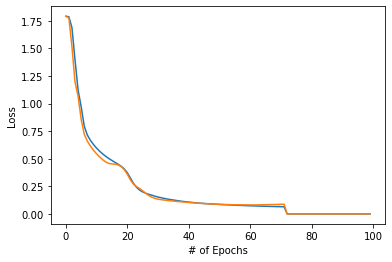

Training complete.
CPU Time:  54.30467915534973 s
Epoch 1, Training Error: 1.790563831891590, Validation Error: 1.790062198740151
Epoch 2, Training Error: 1.785945285582067, Validation Error: 1.776779025344036
Epoch 3, Training Error: 1.686893353770064, Validation Error: 1.514688686088727
Epoch 4, Training Error: 1.395268590257450, Validation Error: 1.195702710005915
Epoch 5, Training Error: 1.121390937147318, Validation Error: 1.065584624235709
Epoch 6, Training Error: 0.971131524450315, Validation Error: 0.856862844401530
Epoch 7, Training Error: 0.795858858240493, Validation Error: 0.722210832803435
Epoch 8, Training Error: 0.715062785750160, Validation Error: 0.660166031677605
Epoch 9, Training Error: 0.667138135394905, Validation Error: 0.614789402224775
Epoch 10, Training Error: 0.629002716730321, Validation Error: 0.576667192761408
Epoch 11, Training Error: 0.596475958031196, Validation Error: 0.545121424935390
Epoch 12, Training Error: 0.567983812087948, Validation Error: 0.517

In [67]:
Case16.train(traindata,trainlabel,100)

Test Accuracy: 92.41%
Class 1: 10 misclassifications
Class 2: 30 misclassifications
Class 3: 39 misclassifications
Class 4: 106 misclassifications
Class 5: 11 misclassifications
Class 6: 24 misclassifications


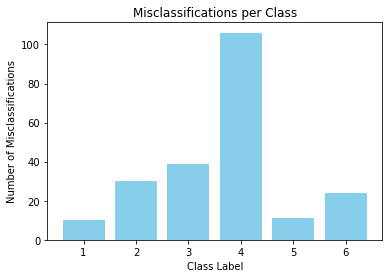

In [68]:
Case16.test_accuracy(testdata,testlabel)

Test Accuracy: 97.84%
Class 1: 0 misclassifications
Class 2: 2 misclassifications
Class 3: 1 misclassifications
Class 4: 136 misclassifications
Class 5: 20 misclassifications
Class 6: 0 misclassifications


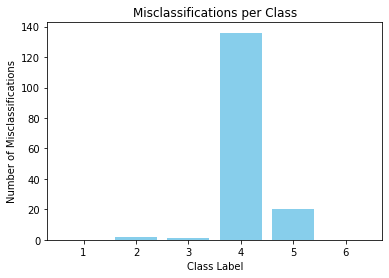

In [69]:
Case16.test_accuracy(traindata,trainlabel)

# DROPOUT

In [11]:
class HAR2:
    
    def __init__(self,hidden_size_1,hidden_size_2,learning_coef,batch_size,momentum):
        
        self.H1_weight = np.random.uniform(-0.01, 0.01, size=(hidden_size_1, 561))
        self.H2_weight = np.random.uniform(-0.01, 0.01, size=(hidden_size_2, hidden_size_1))
        self.O_weight = np.random.uniform(-0.01, 0.01, size=(6, hidden_size_2))
        self.learning_coef = learning_coef
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.batch_size= batch_size
        self.feedbackh1 = np.zeros((hidden_size_1, 561))
        self.feedbackh2 = np.zeros((hidden_size_2, hidden_size_1))
        self.feedbackO = np.zeros((6, hidden_size_2))
        self.momentum=momentum
        
        return
    
    def Softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=-1, keepdims=True)

    def Relu(self,x):
        return np.maximum(0,x)
    
    def Relu_derivative(self,x):
        return np.where(x > 0, 1, 0)
    
    
    
    def forward(self, data, label, training=False):
        Epsilon= 1e-15
        self.v_1 = np.dot(data,self.H1_weight.T)
        self.o_1 = self.Relu(self.v_1)
        self.v_2 = np.dot(self.o_1,self.H2_weight.T)
        self.o_2 = self.Relu(self.v_2)
        if training:
            self.dropout_mask = np.random.binomial(1, 0.5, self.o_2.shape)  # Dropout rate of 0.5
            self.o_2 *= self.dropout_mask  # Apply dropout
        self.v_3 = np.dot(self.o_2,self.O_weight.T)
        self.o_3 = self.Softmax(self.v_3)
        
        cross_entropy_loss= -np.sum(label*np.log(self.o_3+ Epsilon))
        
        avarage_loss=np.mean(cross_entropy_loss)
        return avarage_loss
        
    def gradient_calculation(self,data,label):
        v3grad = self.o_3 -label
        outgrad = np.dot(v3grad.T,self.o_2)
        v2grad = np.dot(v3grad, self.O_weight)
        if hasattr(self, 'dropout_mask'):
            v2grad *= self.dropout_mask  # Scale gradients by the dropout mask

        hidden2grad = np.dot((v2grad * self.Relu_derivative(self.v_2)).T, self.o_1)
        
        # ... [calculations for the first hidden layer and output layer] ...
        v1grad = np.dot(v2grad*self.Relu_derivative(self.o_2), self.H2_weight)
        hidden1grad = np.dot((v1grad*self.Relu_derivative(self.o_1)).T, data)
        
        
        return outgrad,hidden2grad,hidden1grad
    
    def train(self, traindata, trainlabel, epochs, dropout=False):
        start = time.time()
        data=traindata[:len(traindata)-750]
        label=trainlabel[:len(trainlabel)-750]
        validationdata=traindata[len(traindata)-750:]
        validationlabel=trainlabel[len(trainlabel)-750:]
        
        train_error=np.zeros((epochs,1))
        valid_error=np.zeros((epochs,1))
        
        earlystopilk=float('inf')
        hatalimiti=10
        hatagüncel=0
        
        for epoch in range(epochs):
            train_error_epoch=0
            val_error_epoch=0
            
            with tqdm(total=len(data) // self.batch_size, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
                for idx in range(int(len(data) / self.batch_size)):
                    data_idx = data[self.batch_size * idx: self.batch_size * (idx + 1)]
                    label_idx = label[self.batch_size * idx: self.batch_size * (idx + 1)]
                    one_hot_array = [[1 if i == idx-1 else 0 for i in range(6)] for idx in label_idx]
                    one_hot_vector = np.array(one_hot_array)
                    loss = self.forward(data_idx, one_hot_vector, training=dropout)
                    train_error_epoch += loss / len(data)
                    outgrad, hidden2grad, hidden1grad = self.gradient_calculation(data_idx, one_hot_vector)
                    self.O_weight -= self.learning_coef * (self.momentum * self.feedbackO + outgrad) / self.batch_size
                    self.feedbackO = outgrad
                    self.H2_weight -= self.learning_coef * (self.momentum * self.feedbackh2 + hidden2grad) / self.batch_size
                    self.feedbackh2 = hidden2grad
                    self.H1_weight -= self.learning_coef * (self.momentum * self.feedbackh1 + hidden1grad) / self.batch_size
                    self.feedbackh1 = hidden1grad

                    pbar.update(1)  # Update progress bar
                
            for idx in range(int(len(validationdata)/self.batch_size)):
                data_idx=validationdata[self.batch_size*idx:self.batch_size*(idx+1)]
                label_idx=validationlabel[self.batch_size*idx:self.batch_size*(idx+1)]
                one_hot_array = [[1 if i == idx-1 else 0 for i in range(6)] for idx in label_idx]
                one_hot_vector = np.array(one_hot_array)
                loss= self.forward(data_idx, one_hot_vector)
                val_error_epoch+= loss/ len(validationdata)
                
            train_error[epoch]= train_error_epoch
            valid_error[epoch]= val_error_epoch
            
            if val_error_epoch < earlystopilk:
                earlystopilk= val_error_epoch
                hatagüncel=0
            else:
                hatagüncel+=1
            
            if hatagüncel >= hatalimiti:
                print("Training Stopped")
                break
            
            print("Epoch: ", epoch+1)
            print("Train error: {:.9f}".format(train_error_epoch))
            print("Validation Error: {:.9f}".format(val_error_epoch))
            sys.stdout.flush()
            
        plt.plot(train_error , label='Training Error')
        plt.plot(valid_error , label='Validation Error')

        # Add axis titles
        plt.xlabel('# of Epochs')
        plt.ylabel('Loss')
        plt.show()
        print("Training complete.")
        stop = time.time()
        print("CPU Time: ", stop - start, "s")
        training_error_list = train_error.tolist()
        validation_error_list = valid_error.tolist()
        for i in range(epoch+1):
            train_error_formatted = "{:.15f}".format(training_error_list[i][0])
            valid_error_formatted = "{:.15f}".format(validation_error_list[i][0])
            print(f"Epoch {i+1}, Training Error: {train_error_formatted}, Validation Error: {valid_error_formatted}")
        return
    
    def test_accuracy(self, test_data, test_labels):
        total_accuracy = 0
        misclassified_counts = {i: 0 for i in range(1, 7)}  # Assuming class labels are 1-6

        for i in range(len(test_data) // self.batch_size):
            data_idx = test_data[self.batch_size * i: self.batch_size * (i + 1)]
            label_idx = test_labels[self.batch_size * i: self.batch_size * (i + 1)]
            one_hot_array = [[1 if i == idx-1 else 0 for i in range(6)] for idx in label_idx]
            one_hot_vector = np.array(one_hot_array)
            loss = self.forward(data_idx, one_hot_vector, False)
            predicted_labels=self.o_3
            true_labels = np.argmax(one_hot_vector, axis=1)
            batch_predictions = np.argmax(predicted_labels, axis=1)

            correct_predictions = np.sum(batch_predictions == true_labels)
            batch_accuracy = correct_predictions / len(true_labels)
            total_accuracy += batch_accuracy

            # Update misclassification counts
            for label, prediction in zip(true_labels, batch_predictions):
                if label != prediction:
                    misclassified_counts[label + 1] += 1  # Adjusting index for 1-6 range

        # Calculate overall accuracy
        overall_accuracy = total_accuracy / (len(test_data) // self.batch_size)
        print(f"Test Accuracy: {overall_accuracy * 100:.2f}%")

        # Print misclassification counts
        for label, count in misclassified_counts.items():
            print(f"Class {label}: {count} misclassifications")
        
        classes = list(misclassified_counts.keys())
        counts = [misclassified_counts[c] for c in classes]


        plt.bar(classes, counts, color='skyblue')
        plt.xlabel('Class Label')
        plt.ylabel('Number of Misclassifications')
        plt.title('Misclassifications per Class')
        plt.xticks(classes)
        plt.show()
        
        return

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 315.31batch/s]


Epoch:  1
Train error: 1.184386284
Validation Error: 0.628228978


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.31batch/s]


Epoch:  2
Train error: 0.497686777
Validation Error: 0.411963923


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 325.99batch/s]


Epoch:  3
Train error: 0.293269786
Validation Error: 0.129441264


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 321.63batch/s]


Epoch:  4
Train error: 0.234354909
Validation Error: 0.087641629


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 316.73batch/s]


Epoch:  5
Train error: 0.190154154
Validation Error: 0.095683669


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.54batch/s]


Epoch:  6
Train error: 0.160378872
Validation Error: 0.074553598


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 367.11batch/s]


Epoch:  7
Train error: 0.140256138
Validation Error: 0.057072661


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 362.44batch/s]


Epoch:  8
Train error: 0.117438827
Validation Error: 0.063744011


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 355.47batch/s]


Epoch:  9
Train error: 0.114611063
Validation Error: 0.054108477


Epoch 10/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 344.23batch/s]


Epoch:  10
Train error: 0.115237471
Validation Error: 0.047756736


Epoch 11/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 360.37batch/s]


Epoch:  11
Train error: 0.108302581
Validation Error: 0.047744429


Epoch 12/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 343.33batch/s]


Epoch:  12
Train error: 0.109229757
Validation Error: 0.058304324


Epoch 13/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 331.67batch/s]


Epoch:  13
Train error: 0.097777031
Validation Error: 0.127882513


Epoch 14/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.71batch/s]


Epoch:  14
Train error: 0.095372188
Validation Error: 0.044395894


Epoch 15/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.67batch/s]


Epoch:  15
Train error: 0.098454353
Validation Error: 0.046593912


Epoch 16/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.07batch/s]


Epoch:  16
Train error: 0.078994007
Validation Error: 0.047270363


Epoch 17/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.33batch/s]


Epoch:  17
Train error: 0.086971026
Validation Error: 0.038288509


Epoch 18/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 333.97batch/s]


Epoch:  18
Train error: 0.074092411
Validation Error: 0.041429597


Epoch 19/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.75batch/s]


Epoch:  19
Train error: 0.078628038
Validation Error: 0.045970015


Epoch 20/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.04batch/s]


Epoch:  20
Train error: 0.078427838
Validation Error: 0.045107138


Epoch 21/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 324.32batch/s]


Epoch:  21
Train error: 0.076777800
Validation Error: 0.083638999


Epoch 22/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 326.80batch/s]


Epoch:  22
Train error: 0.072430385
Validation Error: 0.035959486


Epoch 23/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 320.82batch/s]


Epoch:  23
Train error: 0.064901792
Validation Error: 0.057188332


Epoch 24/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 329.84batch/s]


Epoch:  24
Train error: 0.065938409
Validation Error: 0.035883170


Epoch 25/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.68batch/s]


Epoch:  25
Train error: 0.064911309
Validation Error: 0.043337355


Epoch 26/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 330.89batch/s]


Epoch:  26
Train error: 0.069545743
Validation Error: 0.062704185


Epoch 27/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.40batch/s]


Epoch:  27
Train error: 0.069998470
Validation Error: 0.054733160


Epoch 28/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.71batch/s]


Epoch:  28
Train error: 0.062049683
Validation Error: 0.031035798


Epoch 29/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 325.41batch/s]


Epoch:  29
Train error: 0.066151832
Validation Error: 0.135896466


Epoch 30/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 355.73batch/s]


Epoch:  30
Train error: 0.081837532
Validation Error: 0.034072290


Epoch 31/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.85batch/s]


Epoch:  31
Train error: 0.065841722
Validation Error: 0.031354033


Epoch 32/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 341.35batch/s]


Epoch:  32
Train error: 0.063291501
Validation Error: 0.184652885


Epoch 33/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:25<00:00, 258.81batch/s]


Epoch:  33
Train error: 0.061570923
Validation Error: 0.033925850


Epoch 34/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:23<00:00, 275.62batch/s]


Epoch:  34
Train error: 0.056520583
Validation Error: 0.030232336


Epoch 35/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 318.31batch/s]


Epoch:  35
Train error: 0.078528817
Validation Error: 0.025604893


Epoch 36/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.14batch/s]


Epoch:  36
Train error: 0.073702023
Validation Error: 0.023348626


Epoch 37/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 379.51batch/s]


Epoch:  37
Train error: 0.067033234
Validation Error: 0.032970199


Epoch 38/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 361.92batch/s]


Epoch:  38
Train error: 0.055625259
Validation Error: 0.031917899


Epoch 39/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 378.09batch/s]


Epoch:  39
Train error: 0.060052681
Validation Error: 0.069647531


Epoch 40/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:17<00:00, 375.77batch/s]


Epoch:  40
Train error: 0.054131489
Validation Error: 0.231528041


Epoch 41/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 292.65batch/s]


Epoch:  41
Train error: 0.058436355
Validation Error: 0.164784464


Epoch 42/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 302.11batch/s]


Epoch:  42
Train error: 0.052128836
Validation Error: 0.022991692


Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 340.95batch/s]


Epoch:  43
Train error: 0.058741809
Validation Error: 0.061699656


Epoch 44/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 317.23batch/s]


Epoch:  44
Train error: 0.051205155
Validation Error: 0.035122665


Epoch 45/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.67batch/s]


Epoch:  45
Train error: 0.050556486
Validation Error: 0.032977236


Epoch 46/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 334.35batch/s]


Epoch:  46
Train error: 0.056311985
Validation Error: 0.136432905


Epoch 47/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 294.71batch/s]


Epoch:  47
Train error: 0.045622905
Validation Error: 0.024874601


Epoch 48/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:23<00:00, 284.11batch/s]


Epoch:  48
Train error: 0.048601510
Validation Error: 0.068999919


Epoch 49/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 294.09batch/s]


Epoch:  49
Train error: 0.046831630
Validation Error: 0.060214887


Epoch 50/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 315.79batch/s]


Epoch:  50
Train error: 0.049654207
Validation Error: 0.018473320


Epoch 51/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 295.77batch/s]


Epoch:  51
Train error: 0.049110458
Validation Error: 0.030221020


Epoch 52/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 298.50batch/s]


Epoch:  52
Train error: 0.048153649
Validation Error: 0.042963145


Epoch 53/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 324.48batch/s]


Epoch:  53
Train error: 0.052231607
Validation Error: 0.037568947


Epoch 54/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 303.56batch/s]


Epoch:  54
Train error: 0.043600232
Validation Error: 0.047457546


Epoch 55/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 332.78batch/s]


Epoch:  55
Train error: 0.047721847
Validation Error: 0.046862454


Epoch 56/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 297.26batch/s]


Epoch:  56
Train error: 0.040164422
Validation Error: 0.071058658


Epoch 57/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:22<00:00, 299.72batch/s]


Epoch:  57
Train error: 0.048657801
Validation Error: 0.028962925


Epoch 58/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 308.14batch/s]


Epoch:  58
Train error: 0.047514261
Validation Error: 0.228486587


Epoch 59/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 337.60batch/s]


Epoch:  59
Train error: 0.040525349
Validation Error: 0.018095366


Epoch 60/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:18<00:00, 350.98batch/s]


Epoch:  60
Train error: 0.045513576
Validation Error: 0.034032021


Epoch 61/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.12batch/s]


Epoch:  61
Train error: 0.047420718
Validation Error: 0.026648770


Epoch 62/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 328.01batch/s]


Epoch:  62
Train error: 0.039903553
Validation Error: 0.031130126


Epoch 63/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 346.89batch/s]


Epoch:  63
Train error: 0.037415386
Validation Error: 0.083618355


Epoch 64/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 336.96batch/s]


Epoch:  64
Train error: 0.042299518
Validation Error: 0.027162395


Epoch 65/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 335.88batch/s]


Epoch:  65
Train error: 0.038592338
Validation Error: 0.040787636


Epoch 66/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 303.37batch/s]


Epoch:  66
Train error: 0.041656629
Validation Error: 0.011499753


Epoch 67/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 303.38batch/s]


Epoch:  67
Train error: 0.041621901
Validation Error: 0.021823351


Epoch 68/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 313.50batch/s]


Epoch:  68
Train error: 0.032640576
Validation Error: 0.015440008


Epoch 69/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 309.57batch/s]


Epoch:  69
Train error: 0.042677130
Validation Error: 0.032430972


Epoch 70/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:23<00:00, 279.61batch/s]


Epoch:  70
Train error: 0.033715577
Validation Error: 0.037164995


Epoch 71/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 308.33batch/s]


Epoch:  71
Train error: 0.034430514
Validation Error: 0.016497630


Epoch 72/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 307.55batch/s]


Epoch:  72
Train error: 0.051349011
Validation Error: 0.017151877


Epoch 73/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:19<00:00, 338.02batch/s]


Epoch:  73
Train error: 0.032147430
Validation Error: 0.019978617


Epoch 74/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 319.00batch/s]


Epoch:  74
Train error: 0.030866504
Validation Error: 0.028452737


Epoch 75/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:20<00:00, 316.90batch/s]


Epoch:  75
Train error: 0.039345746
Validation Error: 0.053112036


Epoch 76/100: 100%|████████████████████████████████████████████████████████████| 6602/6602 [00:21<00:00, 314.23batch/s]


Training Stopped


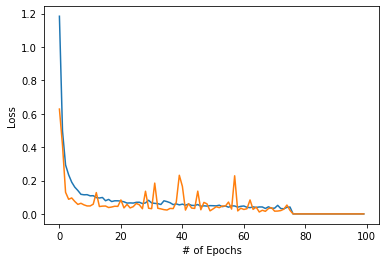

Training complete.
CPU Time:  1552.8471291065216 s
Epoch 1, Training Error: 1.184386284159182, Validation Error: 0.628228978156416
Epoch 2, Training Error: 0.497686776651498, Validation Error: 0.411963923341011
Epoch 3, Training Error: 0.293269786142196, Validation Error: 0.129441263735198
Epoch 4, Training Error: 0.234354908549843, Validation Error: 0.087641629048188
Epoch 5, Training Error: 0.190154154498883, Validation Error: 0.095683668638475
Epoch 6, Training Error: 0.160378871834679, Validation Error: 0.074553598411928
Epoch 7, Training Error: 0.140256138305598, Validation Error: 0.057072660871932
Epoch 8, Training Error: 0.117438826750410, Validation Error: 0.063744011057423
Epoch 9, Training Error: 0.114611062999863, Validation Error: 0.054108476846738
Epoch 10, Training Error: 0.115237471166466, Validation Error: 0.047756735864714
Epoch 11, Training Error: 0.108302581058736, Validation Error: 0.047744429017000
Epoch 12, Training Error: 0.109229757449763, Validation Error: 0.05

In [25]:
model = HAR2(hidden_size_1=300, hidden_size_2=100, learning_coef=0.01, batch_size=1, momentum=0.0)
model.train(traindata, trainlabel, epochs=100, dropout=True)

Test Accuracy: 93.89%
Class 1: 11 misclassifications
Class 2: 40 misclassifications
Class 3: 44 misclassifications
Class 4: 58 misclassifications
Class 5: 17 misclassifications
Class 6: 10 misclassifications


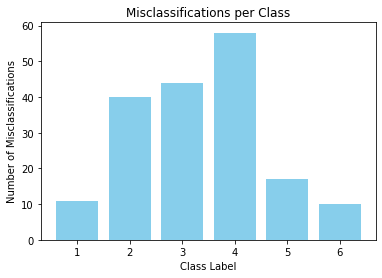

In [26]:
model.test_accuracy(testdata,testlabel)

Test Accuracy: 99.22%
Class 1: 0 misclassifications
Class 2: 0 misclassifications
Class 3: 0 misclassifications
Class 4: 33 misclassifications
Class 5: 24 misclassifications
Class 6: 0 misclassifications


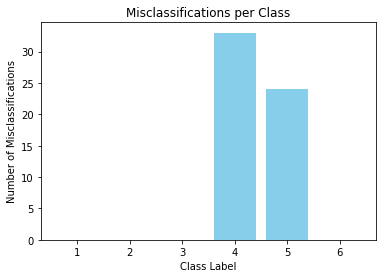

In [27]:
model.test_accuracy(traindata,trainlabel)